In [2]:
!pip install "numpy<2.4"

In [3]:
# ============================================================
# 서울 경매 낙찰가 예측 프로젝트
# 올인원 초기 설정 및 데이터 로드
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [4]:
# 1-5. 랜덤 시드 고정
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
import koreanize_matplotlib

In [6]:
df = pd.read_csv("../data/train_test_2020-2025_euckr.csv", encoding='cp949') 

In [7]:
df.rename({
    'm_code': 'm_code',
    '사건번호': 'case_id',
    '연도': 'year',
    '감정일': 'appraisal_date',
    '매각일': 'sale_date',
    '구': 'district',
    '동': 'dong',
    '용도': 'purpose',
    '층': 'floor',
    '토지면적': 'land_area',
    '건물면적': 'building_area',
    '감정가': 'appraisal_price',
    '최저가': 'minimum_price',
    '낙찰가': 'winning_bid_price',
    '유찰횟수': 'failed_bid_count',
    '낙찰가율': 'winning_bid_ratio',
    '보증금': 'deposit',
    '등기부_인수금액': 'registry_amount',
    '선순위_여부': 'is_senior',
    '교통_키워드_개수': 'traffic_keyword_count',
    '교통환경_불량여부': 'is_bad_traffic',
    '학교_키워드_개수': 'school_keyword_count',
    '엘리베이터_여부': 'has_elevator',
    '최고층수_제한_여부': 'has_height_limit',
    '재개발_여부': 'is_redevelopment',
    '과밀억제권역_여부': 'is_overcrowding_zone'
}, axis=1, inplace=True)

In [8]:
print(f"\n✅ STEP 3 완료: 데이터 로드 완료!")

# ============================================================
# STEP 4: 데이터 기본 정보 확인
# ============================================================

print("\n" + "=" * 80)
print("📋 STEP 4: 데이터 기본 정보")
print("=" * 80)

# 4-1. 데이터 크기
print(f"\n[4-1] 데이터 크기")
print(f"   - 행(건수): {len(df):,}개")
print(f"   - 열(변수): {len(df.columns)}개")

# 4-2. 컬럼 목록
print(f"\n[4-2] 컬럼 목록 ({len(df.columns)}개)")
print(f"   {df.columns.tolist()}")

# 4-3. 데이터 샘플
print(f"\n[4-3] 데이터 샘플 (첫 3행)")
display(df.head(3))

# 4-4. 데이터 타입
print(f"\n[4-4] 데이터 타입")
print(df.dtypes)



✅ STEP 3 완료: 데이터 로드 완료!

📋 STEP 4: 데이터 기본 정보

[4-1] 데이터 크기
   - 행(건수): 17,194개
   - 열(변수): 26개

[4-2] 컬럼 목록 (26개)
   ['m_code', 'case_id', 'year', 'appraisal_date', 'sale_date', 'district', 'dong', 'purpose', 'floor', 'land_area', 'building_area', 'appraisal_price', 'minimum_price', 'winning_bid_price', 'failed_bid_count', 'winning_bid_ratio', 'deposit', 'registry_amount', 'is_senior', 'traffic_keyword_count', 'is_bad_traffic', 'school_keyword_count', 'has_elevator', 'has_height_limit', 'is_redevelopment', 'is_overcrowding_zone']

[4-3] 데이터 샘플 (첫 3행)


,m_code,case_id,year,appraisal_date,sale_date,district,dong,purpose,floor,land_area,...,deposit,registry_amount,is_senior,traffic_keyword_count,is_bad_traffic,school_keyword_count,has_elevator,has_height_limit,is_redevelopment,is_overcrowding_zone
0,2.200000e+14,2019타경50677,2020,2019-03-04,2020-09-14,성동구,성수동1가,아파트,8,36.4,...,0,2300000000,1,0,0,0,0,0,0,0
1,1.200000e+14,2019타경3173,2020,2019-05-16,2020-10-13,관악구,신림동,다가구,1,126.0,...,35000000,0,0,0,0,0,0,0,0,0
2,3.200000e+14,2019타경5280,2020,2019-10-11,2020-09-22,서대문구,연희동,아파트,3,45.0,...,150000000,0,1,1,0,1,1,1,0,1



[4-4] 데이터 타입
m_code                   float64
case_id                      str
year                       int64
appraisal_date               str
sale_date                    str
district                     str
dong                         str
purpose                      str
floor                      int64
land_area                float64
building_area            float64
appraisal_price            int64
minimum_price              int64
winning_bid_price          int64
failed_bid_count           int64
winning_bid_ratio        float64
deposit                    int64
registry_amount            int64
is_senior                  int64
traffic_keyword_count      int64
is_bad_traffic             int64
school_keyword_count       int64
has_elevator               int64
has_height_limit           int64
is_redevelopment           int64
is_overcrowding_zone       int64
dtype: object


In [9]:
# ============================================================
# STEP 5: 데이터 품질 체크 (Data Quality Check)
# ============================================================

print("\n" + "=" * 80)
print("🔍 STEP 5: 데이터 품질 체크")
print("=" * 80)

# 5-1. 결측치 확인
print("\n[5-1] 결측치 현황")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    '결측 개수': missing,
    '결측 비율(%)': missing_pct
}).sort_values('결측 개수', ascending=False)

print("\n결측치가 있는 컬럼:")
display(missing_df[missing_df['결측 개수'] > 0])

# 5-2. 타겟 변수 확인
print("\n[5-2] 타겟 변수 (낙찰가: winning_bid_price) 현황")
n_sold = df['winning_bid_price'].notna().sum()
n_unsold = df['winning_bid_price'].isna().sum()
sold_rate = n_sold / len(df) * 100

print(f"   - 낙찰 건수: {n_sold:,}개")
print(f"   - 유찰 건수: {n_unsold:,}개")
print(f"   - 낙찰률: {sold_rate:.2f}%")

# 5-3. 범주형 변수 분포
print("\n[5-3] 범주형 변수 분포")

print("\n   ① 용도 (purpose)")
print(df['purpose'].value_counts())

print("\n   ② 구 (district) - 상위 10개")
print(df['district'].value_counts().head(10))

print(f"\n   ③ 동 (dong)")
print(f"      - 고유값: {df['dong'].nunique()}개")
print(f"      - 상위 5개:")
print(df['dong'].value_counts().head(5))

# 5-4. 수치형 변수 통계
print("\n[5-4] 주요 수치 변수 범위")

numeric_cols = [
    'floor', 'land_area', 'building_area', 'appraisal_price', 
    'minimum_price', 'failed_bid_count', 'winning_bid_price', 'deposit'
]

stats_list = []
for col in numeric_cols:
    if col in df.columns:
        data = df[col].dropna()
        if len(data) > 0:
            stats_list.append({
                '변수': col,
                '최소': f"{data.min():,.0f}",
                '평균': f"{data.mean():,.0f}",
                '중앙값': f"{data.median():,.0f}",
                '최대': f"{data.max():,.0f}",
                '결측': f"{df[col].isna().sum():,}개"
            })

stats_df = pd.DataFrame(stats_list)
display(stats_df)

# 5-5. 연도별 분포
print("\n[5-5] 연도별 데이터 분포 (year)")
year_dist = df.groupby('year').agg({
    'case_id': 'count',
    'winning_bid_price': lambda x: x.notna().sum()
}).rename(columns={'case_id': '전체', 'winning_bid_price': '낙찰'})
year_dist['낙찰률(%)'] = (year_dist['낙찰'] / year_dist['전체'] * 100).round(2)
display(year_dist)

# ============================================================
# 최종 요약
# ============================================================

print("\n" + "=" * 80)
print("✅ 초기 데이터 로드 및 분석 완료!")
print("=" * 80)

print(f"""
📊 데이터 요약:
   - 전체 건수: {len(df):,}개
   - 기간: {df['year'].min()}년 ~ {df['year'].max()}년
   - 낙찰 건수: {n_sold:,}개 ({sold_rate:.1f}%)
   - 유찰 건수: {n_unsold:,}개
   - 컬럼 수: {len(df.columns)}개

🎯 다음 단계:
   1. EDA (탐색적 데이터 분석)
   2. 피처 엔지니어링
   3. 모델링
""")

print("=" * 80)


🔍 STEP 5: 데이터 품질 체크

[5-1] 결측치 현황

결측치가 있는 컬럼:


,결측 개수,결측 비율(%)



[5-2] 타겟 변수 (낙찰가: winning_bid_price) 현황
   - 낙찰 건수: 17,194개
   - 유찰 건수: 0개
   - 낙찰률: 100.00%

[5-3] 범주형 변수 분포

   ① 용도 (purpose)
purpose
다세대         11459
아파트          4089
연립            535
단독주택          522
오피스텔(주거)      292
다가구           270
근린주택           27
Name: count, dtype: int64

   ② 구 (district) - 상위 10개
district
강서구    3538
양천구    1373
구로구    1129
관악구    1046
은평구     955
금천구     885
동작구     715
강북구     694
성북구     685
도봉구     641
Name: count, dtype: int64

   ③ 동 (dong)
      - 고유값: 328개
      - 상위 5개:
dong
화곡동    2858
신월동     701
신림동     537
독산동     475
봉천동     444
Name: count, dtype: int64

[5-4] 주요 수치 변수 범위


,변수,최소,평균,중앙값,최대,결측
0,floor,1,4,3,58,0개
1,land_area,0,36,24,"13,528",0개
2,building_area,0,60,43,"5,066",0개
3,appraisal_price,"2,900,000","507,459,210","286,000,000","24,034,400,000",0개
4,minimum_price,"1,397,000","378,953,150","210,200,000","14,791,484,040",0개
5,failed_bid_count,0,2,1,21,0개
6,winning_bid_price,"1,629,999","431,132,588","236,750,000","15,200,200,000",0개
7,deposit,0,"147,241,013","150,000,000","5,000,000,000",0개



[5-5] 연도별 데이터 분포 (year)


,전체,낙찰,낙찰률(%)
year,,,
2020,1433,1433,100.0
2021,1518,1518,100.0
2022,1420,1420,100.0
2023,2130,2130,100.0
2024,5196,5196,100.0
2025,5497,5497,100.0



✅ 초기 데이터 로드 및 분석 완료!

📊 데이터 요약:
   - 전체 건수: 17,194개
   - 기간: 2020년 ~ 2025년
   - 낙찰 건수: 17,194개 (100.0%)
   - 유찰 건수: 0개
   - 컬럼 수: 26개

🎯 다음 단계:
   1. EDA (탐색적 데이터 분석)
   2. 피처 엔지니어링
   3. 모델링



In [10]:
# ============================================================
# STEP 6: 탐색적 데이터 분석 (EDA)
# ============================================================

print("\n" + "=" * 80)
print("📊 STEP 6: 탐색적 데이터 분석 (EDA)")
print("=" * 80)

# 6-1. 타겟 변수 확인 (낙찰가율: winning_bid_ratio)
print("\n[6-1] 타겟 변수 확인: 낙찰가율 (winning_bid_ratio)")

# 낙찰된 데이터만 필터링
df_sold = df[df['winning_bid_price'].notna()].copy()

# 만약 winning_bid_ratio가 계산되어 있지 않다면 재계산 (낙찰가 / 감정가)
if 'winning_bid_ratio' not in df.columns:
    df_sold['winning_bid_ratio'] = (df_sold['winning_bid_price'] / df_sold['appraisal_price'])

print(f"   - 낙찰가율 범위: {df_sold['winning_bid_ratio'].min():.2f} ~ {df_sold['winning_bid_ratio'].max():.2f}")
print(f"   - 낙찰가율 평균: {df_sold['winning_bid_ratio'].mean():.2f} ({df_sold['winning_bid_ratio'].mean()*100:.1f}%)")
print(f"   - 낙찰가율 중앙: {df_sold['winning_bid_ratio'].median():.2f} ({df_sold['winning_bid_ratio'].median()*100:.1f}%)")



📊 STEP 6: 탐색적 데이터 분석 (EDA)

[6-1] 타겟 변수 확인: 낙찰가율 (winning_bid_ratio)
   - 낙찰가율 범위: 1.08 ~ 198.41
   - 낙찰가율 평균: 82.58 (8258.5%)
   - 낙찰가율 중앙: 84.06 (8406.2%)



[6-2] 낙찰가율 분포 시각화


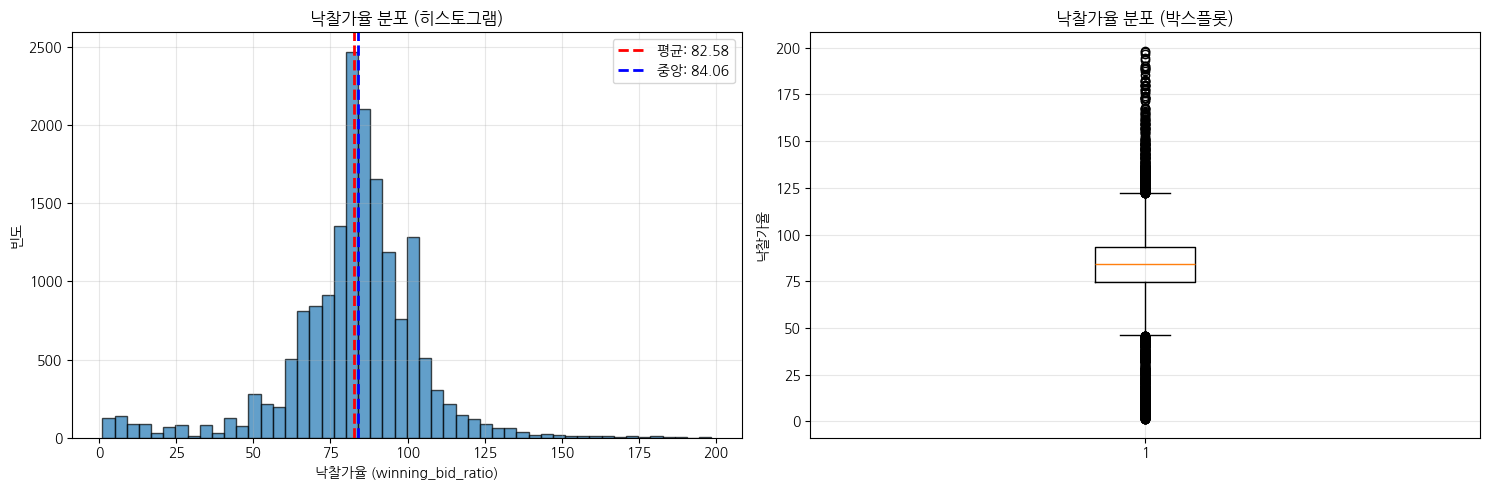

In [11]:
# 6-2. 낙찰가율 분포 시각화
print("\n[6-2] 낙찰가율 분포 시각화")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 히스토그램
axes[0].hist(df_sold['winning_bid_ratio'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df_sold['winning_bid_ratio'].mean(), color='red',
                linestyle='--', linewidth=2, label=f'평균: {df_sold["winning_bid_ratio"].mean():.2f}')
axes[0].axvline(df_sold['winning_bid_ratio'].median(), color='blue',
                linestyle='--', linewidth=2, label=f'중앙: {df_sold["winning_bid_ratio"].median():.2f}')
axes[0].set_xlabel('낙찰가율 (winning_bid_ratio)')
axes[0].set_ylabel('빈도')
axes[0].set_title('낙찰가율 분포 (히스토그램)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 박스플롯
axes[1].boxplot(df_sold['winning_bid_ratio'], vert=True)
axes[1].set_ylabel('낙찰가율')
axes[1].set_title('낙찰가율 분포 (박스플롯)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 낙찰가율 이상치에 대한 추가 분석
- 진행예정


[6-3] 유찰횟수(failed_bid_count)별 낙찰가율 분석
                 winning_bid_ratio                                  
                             count     mean     std     min      max
failed_bid_count                                                    
0                             2221  110.536  15.698  16.851  198.408
1                             6965   89.102   8.488   8.828  190.259
2                             3830   76.440   9.717  10.371  182.128
3                             1456   67.730  15.620  10.629  179.823
4                              596   67.229  20.505  36.724  149.217
5                              424   71.058  21.430  32.768  134.688
6                              307   65.229  24.577  26.214  122.316
7                              292   62.164  26.046  20.971  103.311
8                              221   63.849  28.078  16.777  139.003
9                              161   60.978  31.379  13.421  125.758
10                             154   53.577  34.256   9.508  111

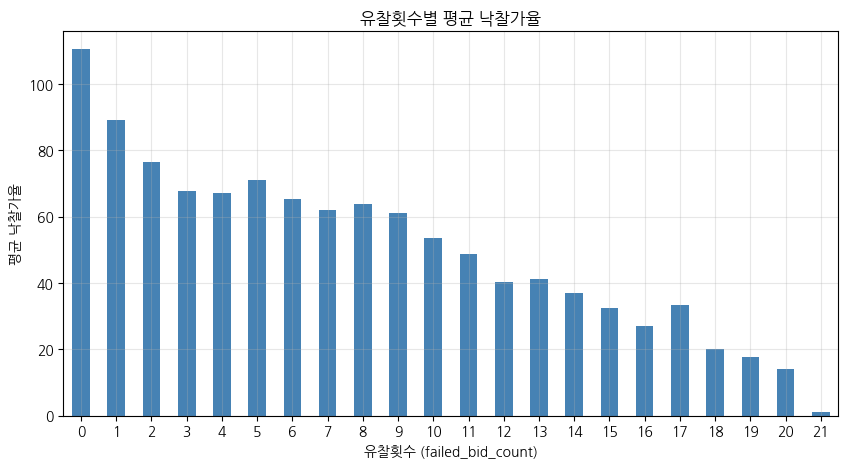

<Figure size 1000x500 with 0 Axes>

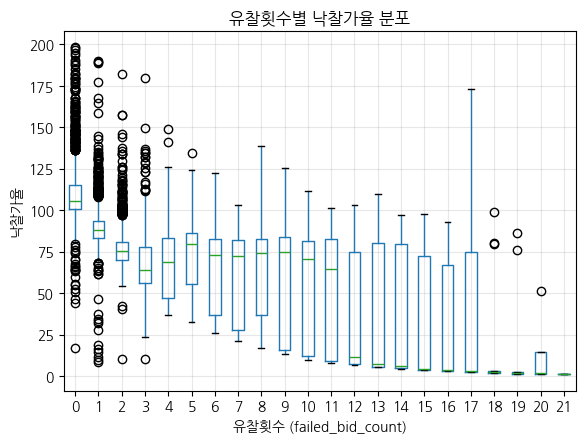

In [12]:
# 6-3. 유찰횟수(failed_bid_count)별 낙찰가율
print("\n[6-3] 유찰횟수(failed_bid_count)별 낙찰가율 분석")

auction_analysis = df_sold.groupby('failed_bid_count').agg({
    'winning_bid_ratio': ['count', 'mean', 'std', 'min', 'max']
}).round(3)

print(auction_analysis)

# 시각화
# 1. 유찰횟수별 평균 낙찰가율 (Bar Chart)
plt.figure(figsize=(10, 5))
df_sold.groupby('failed_bid_count')['winning_bid_ratio'].mean().plot(kind='bar', color='steelblue')
plt.xlabel('유찰횟수 (failed_bid_count)')
plt.ylabel('평균 낙찰가율')
plt.title('유찰횟수별 평균 낙찰가율')
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.show()

# 2. 유찰횟수별 낙찰가율 분포 (Boxplot)
plt.figure(figsize=(10, 5))
df_sold.boxplot(column='winning_bid_ratio', by='failed_bid_count')
plt.xlabel('유찰횟수 (failed_bid_count)')
plt.ylabel('낙찰가율')
plt.title('유찰횟수별 낙찰가율 분포')
plt.suptitle('') # pandas boxplot의 기본 상단 타이틀 제거
plt.grid(alpha=0.3)
plt.show()

In [13]:
def remove_auction_outliers(df, column='winning_bid_ratio', group_col='failed_bid_count'):
    """
    유찰횟수별로 그룹화하여 IQR 방식으로 이상치를 제거하고, 
    경매 상식 범위를 벗어나는 글로벌 이상치를 처리합니다.
    """
    before_cnt = len(df)
    
    # 1. 글로벌 필터링 (경매 상식: 낙찰가율이 10% 미만이거나 200% 초과인 경우 제거)
    # 데이터 단위가 0.84 같은 비율이라면 0.1 ~ 2.0으로 수정하세요.
    df = df[(df[column] >= 10) & (df[column] <= 200)].copy()
    
    # 2. 그룹별 IQR 필터링 (유찰횟수별 분포에 맞춤)
    def get_group_bounds(x):
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        # 경매 데이터 특성상 상단 이상치가 치명적이므로 상단 경계(1.5배)를 엄격히 적용
        return q1 - 1.5 * iqr, q3 + 1.5 * iqr

    # 각 그룹별로 경계값을 계산하여 필터링
    filtered_df = pd.DataFrame()
    for name, group in df.groupby(group_col):
        lower, upper = get_group_bounds(group[column])
        # 그룹 내 정상 범위 데이터만 추출
        cleaned_group = group[(group[column] >= lower) & (group[column] <= upper)]
        filtered_df = pd.concat([filtered_df, cleaned_group])
    
    after_cnt = len(filtered_df)
    print(f"제거된 이상치 건수: {before_cnt - after_cnt:,}개 (전체의 {(before_cnt - after_cnt)/before_cnt*100:.2f}%)")
    
    return filtered_df


제거된 이상치 건수: 754개 (전체의 4.39%)


<Figure size 1200x600 with 0 Axes>

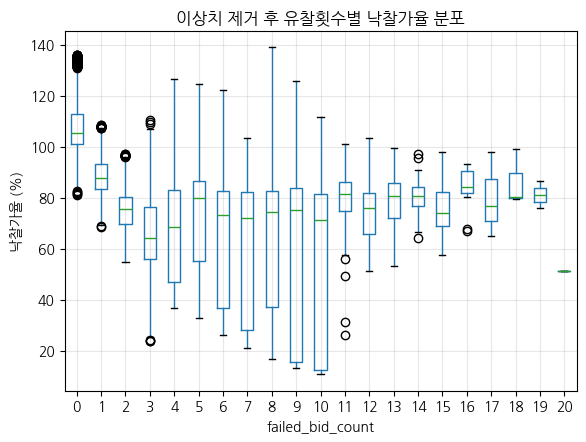

In [14]:
# 이상치 제거 실행
df_sold_cleaned = remove_auction_outliers(df_sold)

# 제거 후 시각화 확인
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
df_sold_cleaned.boxplot(column='winning_bid_ratio', by='failed_bid_count')
plt.title('이상치 제거 후 유찰횟수별 낙찰가율 분포')
plt.suptitle('')
plt.ylabel('낙찰가율 (%)')
plt.grid(alpha=0.3)
plt.show()

In [15]:
df_sold = df_sold_cleaned


[6-4] 지역(district)별 낙찰가율 분석

상위 10개 구:
           건수  평균_낙찰가율
district              
용산구       164   93.174
성동구       170   90.878
광진구       336   90.553
강남구       369   88.303
마포구       402   87.871
송파구       519   87.726
영등포구      329   86.999
서초구       335   86.668
중구        106   86.396
동작구       680   86.197

하위 10개 구:
            건수  평균_낙찰가율
district               
양천구       1309   83.469
구로구       1081   82.995
중랑구        554   82.879
금천구        846   82.644
도봉구        627   81.467
은평구        911   81.398
종로구        195   81.163
강북구        658   80.836
관악구        984   80.635
강서구       3415   78.490


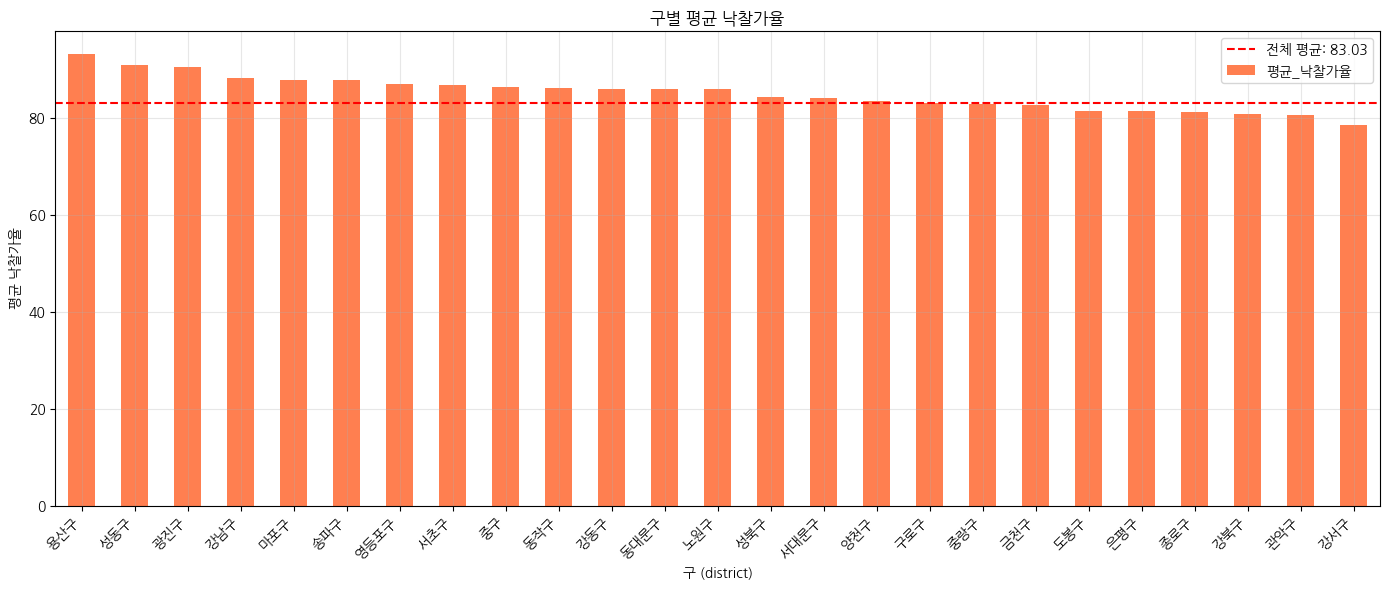

In [16]:

# 6-4. 지역(district)별 낙찰가율
print("\n[6-4] 지역(district)별 낙찰가율 분석")

district_analysis = df_sold.groupby('district').agg({
    'winning_bid_ratio': ['count', 'mean']
}).round(3)
district_analysis.columns = ['건수', '평균_낙찰가율']
district_analysis = district_analysis.sort_values('평균_낙찰가율', ascending=False)

print("\n상위 10개 구:")
print(district_analysis.head(10))

print("\n하위 10개 구:")
print(district_analysis.tail(10))

# 시각화
plt.figure(figsize=(14, 6))
district_analysis['평균_낙찰가율'].plot(kind='bar', color='coral')
plt.xlabel('구 (district)')
plt.ylabel('평균 낙찰가율')
plt.title('구별 평균 낙찰가율')
plt.xticks(rotation=45, ha='right')
plt.axhline(df_sold['winning_bid_ratio'].mean(), color='red',
            linestyle='--', label=f'전체 평균: {df_sold["winning_bid_ratio"].mean():.2f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



[6-5] 용도(purpose)별 낙찰가율 분석
         winning_bid_ratio                
                     count    mean     std
purpose                                   
근린주택                    26  77.224  15.723
다가구                    263  78.516  17.109
다세대                  10881  80.714  17.593
단독주택                   498  78.982  19.860
아파트                   3984  89.991  15.847
연립                     513  86.922  16.081
오피스텔(주거)               275  78.726  18.386


<Figure size 1000x600 with 0 Axes>

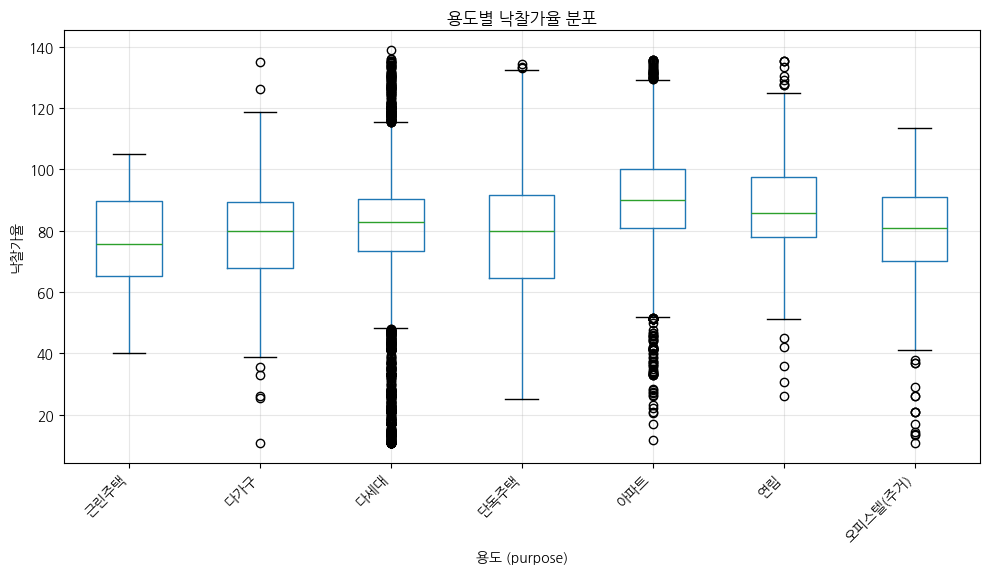

In [17]:
# 6-5. 용도(purpose)별 낙찰가율
print("\n[6-5] 용도(purpose)별 낙찰가율 분석")

purpose_analysis = df_sold.groupby('purpose').agg({
    'winning_bid_ratio': ['count', 'mean', 'std']
}).round(3)

print(purpose_analysis)

# 시각화
plt.figure(figsize=(10, 6))
df_sold.boxplot(column='winning_bid_ratio', by='purpose', figsize=(10, 6))
plt.xlabel('용도 (purpose)')
plt.ylabel('낙찰가율')
plt.title('용도별 낙찰가율 분포')
plt.suptitle('')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:

# 6-6. 보증금(deposit) 영향 분석
print("\n[6-6] 보증금 영향 분석")

# 보증금비율 생성
df_sold['deposit_ratio'] = df_sold['deposit'] / df_sold['appraisal_price']

# 보증금 유무별 비교
with_deposit = df_sold[df_sold['deposit'].notna() & (df_sold['deposit'] > 0)]
without_deposit = df_sold[df_sold['deposit'].isna() | (df_sold['deposit'] == 0)]

print(f"\n보증금 있음: {len(with_deposit):,}개")
print(f"   - 평균 낙찰가율: {with_deposit['winning_bid_ratio'].mean():.3f}")
print(f"\n보증금 없음: {len(without_deposit):,}개")
print(f"   - 평균 낙찰가율: {without_deposit['winning_bid_ratio'].mean():.3f}")



[6-6] 보증금 영향 분석

보증금 있음: 11,103개
   - 평균 낙찰가율: 81.283

보증금 없음: 5,337개
   - 평균 낙찰가율: 86.664


In [19]:
# t-test
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(with_deposit['winning_bid_ratio'],
                             without_deposit['winning_bid_ratio'])
print(f"\nt-test 결과:")
print(f"   - t-통계량: {t_stat:.3f}")
print(f"   - p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"   → 보증금 유무에 따른 낙찰가율 차이 통계적으로 유의미! ✅")



t-test 결과:
   - t-통계량: -18.440
   - p-value: 0.0000
   → 보증금 유무에 따른 낙찰가율 차이 통계적으로 유의미! ✅



[6-7] 연도(year)별 낙찰가율 트렌드
     winning_bid_ratio                
                 count    mean     std
year                                  
2020              1352  89.063  17.984
2021              1416  88.177  21.686
2022              1359  84.021  21.433
2023              2011  77.286  17.413
2024              4995  82.816  14.811
2025              5307  82.242  17.155


<Figure size 1000x500 with 0 Axes>

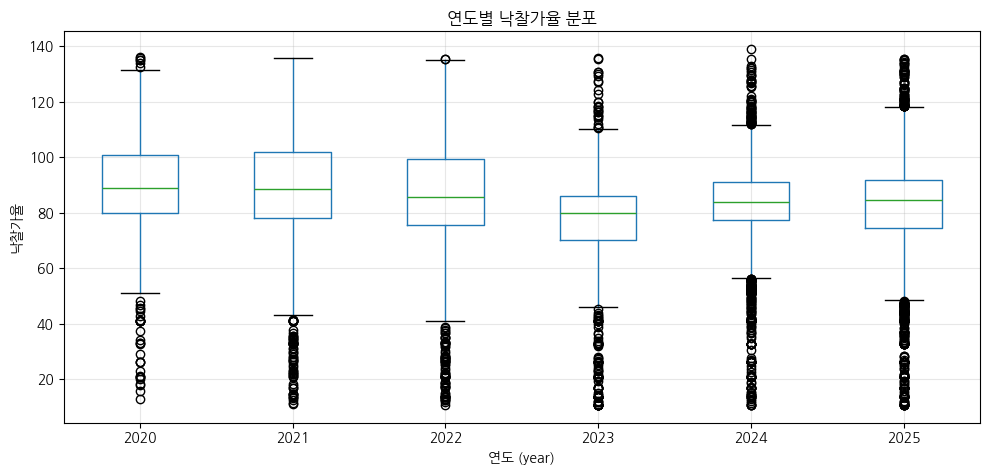


✅ EDA 완료!


In [20]:
# 6-7. 연도(year)별 트렌드
print("\n[6-7] 연도(year)별 낙찰가율 트렌드")

year_trend = df_sold.groupby('year').agg({
    'winning_bid_ratio': ['count', 'mean', 'std']
}).round(3)

print(year_trend)

plt.figure(figsize=(10, 5))
df_sold.boxplot(column='winning_bid_ratio', by='year', figsize=(10, 5))
plt.xlabel('연도 (year)')
plt.ylabel('낙찰가율')
plt.title('연도별 낙찰가율 분포')
plt.suptitle('')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("✅ EDA 완료!")
print("=" * 80)


📊 낙찰가율 분포 상세 (winning_bid_ratio)

낙찰가율 백분위수:
    50.0%ile:   84.04%
    75.0%ile:   92.91%
    90.0%ile:  102.04%
    95.0%ile:  108.01%
    99.0%ile:  124.73%
    99.5%ile:  129.90%
    99.9%ile:  135.05%
   100.0%ile:  139.00%

낙찰가율 구간별 분포:
winning_bid_ratio_bin
<50%         629
50-70%      2334
70-90%      8186
90-100%     2909
100-120%    2110
120-150%     272
150-200%       0
>200%          0
Name: count, dtype: int64


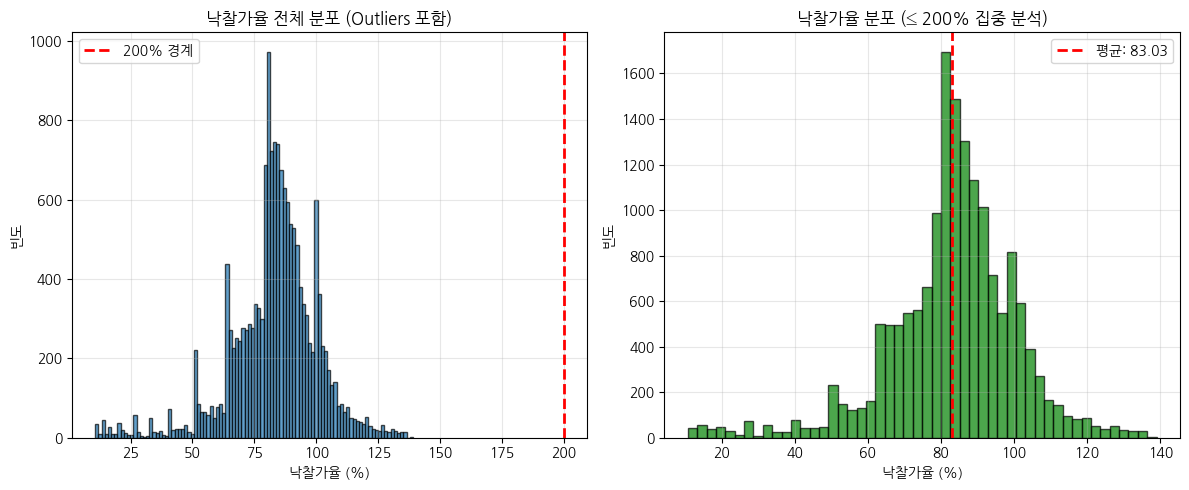


[데이터 품질 요약]
   - 정상 범위 (≤ 200%): 16,440개 (100.00%)
   - 이상치 범위 (> 200%): 0개 (0.00%)


In [21]:
# ============================================================
# 낙찰가율 분포 상세 분석 (Detailed Analysis of winning_bid_ratio)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("📊 낙찰가율 분포 상세 (winning_bid_ratio)")
print("=" * 80)

# 백분위수 확인
percentiles = [50, 75, 90, 95, 99, 99.5, 99.9, 100]
print("\n낙찰가율 백분위수:")
for p in percentiles:
    value = np.percentile(df_sold['winning_bid_ratio'], p)
    # 데이터가 % 단위(예: 86.12)이므로 그대로 출력
    print(f"   {p:5.1f}%ile: {value:7.2f}%")

# 구간별 개수 (데이터가 % 단위이므로 단위를 100배 조정하여 구간 설정)
print("\n낙찰가율 구간별 분포:")
bins = [0, 50, 70, 90, 100, 120, 150, 200, 10000]
labels = ['<50%', '50-70%', '70-90%', '90-100%', '100-120%', '120-150%', '150-200%', '>200%']

df_sold['winning_bid_ratio_bin'] = pd.cut(df_sold['winning_bid_ratio'], bins=bins, labels=labels)
print(df_sold['winning_bid_ratio_bin'].value_counts().sort_index())

# 시각화
plt.figure(figsize=(12, 5))

# 전체 분포 (Scale 이슈 확인용)
plt.subplot(1, 2, 1)
plt.hist(df_sold['winning_bid_ratio'], bins=100, edgecolor='black', alpha=0.7)
plt.axvline(200.0, color='red', linestyle='--', linewidth=2, label='200% 경계')
plt.xlabel('낙찰가율 (%)')
plt.ylabel('빈도')
plt.title('낙찰가율 전체 분포 (Outliers 포함)')
plt.legend()
plt.grid(alpha=0.3)

# 확대 (정상 범위 0~200%)
plt.subplot(1, 2, 2)
df_sold_normal = df_sold[df_sold['winning_bid_ratio'] <= 200.0]
plt.hist(df_sold_normal['winning_bid_ratio'], bins=50, edgecolor='black', alpha=0.7, color='green')
plt.axvline(df_sold_normal['winning_bid_ratio'].mean(), color='red',
            linestyle='--', linewidth=2, label=f'평균: {df_sold_normal["winning_bid_ratio"].mean():.2f}')
plt.xlabel('낙찰가율 (%)')
plt.ylabel('빈도')
plt.title('낙찰가율 분포 (≤ 200% 집중 분석)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 요약 통계
outliers_count = len(df_sold[df_sold['winning_bid_ratio'] > 200.0])
print(f"\n[데이터 품질 요약]")
print(f"   - 정상 범위 (≤ 200%): {len(df_sold_normal):,}개 ({len(df_sold_normal)/len(df_sold)*100:.2f}%)")
print(f"   - 이상치 범위 (> 200%): {outliers_count:,}개 ({outliers_count/len(df_sold)*100:.2f}%)")

In [22]:
# ============================================================
# STEP 7: 피처 엔지니어링 & 전처리 (English Schema Version)
# ============================================================

print("\n" + "=" * 80)
print("🔧 STEP 7: 피처 엔지니어링 & 전처리")
print("=" * 80)


🔧 STEP 7: 피처 엔지니어링 & 전처리


In [ ]:
from typing import Optional

# ============================================
# 피처 엔지니어링 함수들 (최종 영문 스키마 기준)
# ============================================

def add_basic_ratio_features(df: pd.DataFrame) -> pd.DataFrame:
    """1. 기본 비율 피처 추가"""
    df = df.copy()
    eps = 1e-10
    
    # 최저가율 (min_price_ratio)
    df['min_price_ratio'] = df['minimum_price'] / (df['appraisal_price'] + eps) * 100
    
    # 보증금비율 (deposit_ratio)
    df['deposit_ratio'] = df['deposit'] / (df['appraisal_price'] + eps) * 100
    
    # 인수금액비율 (registry_ratio)
    df['registry_ratio'] = df['registry_amount'] / (df['appraisal_price'] + eps) * 100
    
    return df


def add_teammate_insight_features(df: pd.DataFrame) -> pd.DataFrame:
    """2. 팀원 인사이트 피처 추가"""
    df = df.copy()
    eps = 1e-10
    
    # 신건여부 (is_new_case)
    df['is_new_case'] = (df['failed_bid_count'] == 0).astype(int)
    
    # 평수 (pyeong_building, pyeong_land)
    df['pyeong_building'] = df['building_area'] / 3.305785
    df['pyeong_land'] = df['land_area'] / 3.305785
    
    # 경매횟수 (auction_count)
    df['auction_count'] = df['failed_bid_count'] + 1
    
    # 평당 가격 (appraisal_price_per_pyeong, min_price_per_pyeong)
    df['appraisal_price_per_pyeong'] = df['appraisal_price'] / (df['pyeong_building'] + eps)
    df['min_price_per_pyeong'] = df['minimum_price'] / (df['pyeong_building'] + eps)
    
    return df


def add_priority_deposit_features(df: pd.DataFrame) -> pd.DataFrame:
    """3. 보증금/인수금액/선순위 통합 피처 추가"""
    df = df.copy()
    eps = 1e-10
    
    # 필요한 기본 비율이 없으면 계산
    if 'min_price_ratio' not in df.columns:
        df['min_price_ratio'] = df['minimum_price'] / (df['appraisal_price'] + eps) * 100
    if 'registry_ratio' not in df.columns:
        df['registry_ratio'] = df['registry_amount'] / (df['appraisal_price'] + eps) * 100
    
    # 실제_인수부담 여부 (is_actual_burden)
    df['is_actual_burden'] = ((df['is_senior'] == 1) & (df['registry_amount'] > 0)).astype(int)
    
    # 실질_투자비율 (actual_investment_ratio)
    df['actual_investment_ratio'] = np.where(
        df['is_senior'] == 1,
        df['min_price_ratio'] + df['registry_ratio'],
        df['min_price_ratio']
    )
    
    # 실질부담_100초과 (is_burden_over_100)
    df['is_burden_over_100'] = (df['actual_investment_ratio'] > 100).astype(int)
    
    # 보증금-인수금액 일치 여부 (is_deposit_registry_match)
    df['is_deposit_registry_match'] = (df['deposit'] == df['registry_amount']).astype(int)
    
    # 보증금유무 (has_deposit)
    df['has_deposit'] = (df['deposit'] > 0).astype(int)
    
    # 선순위초과 (is_senior_over_appraisal: 보증금이 감정가 초과)
    df['is_senior_over_appraisal'] = (df['deposit'] > df['appraisal_price']).astype(int)
    
    # 인수금액_감정가_초과 (is_registry_over_appraisal)
    df['is_registry_over_appraisal'] = (df['registry_amount'] > df['appraisal_price']).astype(int)
    
    return df


def add_target_encoding(
    df: pd.DataFrame, 
    target_col: str = 'winning_bid_ratio',
    train_mask: Optional[np.ndarray] = None
) -> pd.DataFrame:
    """4. Target Encoding 추가 (district_avg_ratio, dong_avg_ratio)"""
    df = df.copy()
    
    # Train 데이터 기준으로 평균 낙찰가율 계산
    if train_mask is not None:
        df_train = df[train_mask]
        district_mean = df_train.groupby('district')[target_col].mean()
        dong_mean = df_train.groupby('dong')[target_col].mean()
        global_mean = df_train[target_col].mean()
    else:
        district_mean = df.groupby('district')[target_col].mean()
        dong_mean = df.groupby('dong')[target_col].mean()
        global_mean = df[target_col].mean()
    
    # 인코딩 적용
    df['district_avg_ratio'] = df['district'].map(district_mean).fillna(global_mean)
    df['dong_avg_ratio'] = df['dong'].map(dong_mean).fillna(global_mean)
    
    return df


def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    """5. 날짜 관련 피처 추가"""
    df = df.copy()
    
    df['appraisal_date'] = pd.to_datetime(df['appraisal_date'], errors='coerce')
    df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')
    
    # 매각 시점 정보
    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month
    df['sale_quarter'] = df['sale_date'].dt.quarter
    
    # 경과일 (elapsed_days)
    df['elapsed_days'] = (df['sale_date'] - df['appraisal_date']).dt.days
    
    return df


def add_all_features(
    df: pd.DataFrame,
    add_target_enc: bool = True,
    train_mask: Optional[np.ndarray] = None
) -> pd.DataFrame:
    """6. 모든 피처 엔지니어링 통합 적용"""
    df = df.copy()
    
    # 1. 기본 비율 피처
    df = add_basic_ratio_features(df)
    
    # 2. 팀원 인사이트 피처
    df = add_teammate_insight_features(df)
    
    # 3. 보증금/인수금액 통합 피처
    df = add_priority_deposit_features(df)
    
    # 4. 날짜 피처
    df = add_date_features(df)
    
    # 5. Target Encoding
    if add_target_enc:
        df = add_target_encoding(df, train_mask=train_mask)
        
    # 6. 복합 위험 지표 (선택적 추가)
    df['combined_risk_index'] = (
        df['is_senior'] + 
        df['is_actual_burden'] + 
        (df['failed_bid_count'] >= 5).astype(int) +
        df['is_burden_over_100']
    )
    
    return df

In [24]:
# ============================================
# 최종 컬럼 목록 리스트 업데이트 (KeyError 방지)
# ============================================
def get_feature_columns() -> dict:
    """실제로 생성된 영문 피처명들에 기반한 분류"""
    return {
        'id_columns': ['m_code', 'case_id'],
        'date_columns': ['appraisal_date', 'sale_date'],
        'categorical_columns': ['district', 'dong', 'purpose'],
        
        'numeric_original': [
            'year', 'floor', 'land_area', 'building_area',
            'appraisal_price', 'minimum_price', 'winning_bid_price',
            'failed_bid_count', 'deposit', 'registry_amount'
        ],
        
        'binary_original': [
            'is_senior', 'is_bad_traffic', 'has_elevator',
            'has_height_limit', 'is_redevelopment', 'is_overcrowding_zone'
        ],
        
        'count_original': [
            'traffic_keyword_count', 'school_keyword_count'
        ],
        
        'target': ['winning_bid_ratio'],
        
        'engineered_ratio': [
            'min_price_ratio',       # (기존: minimum_price_ratio)
            'deposit_ratio', 
            'registry_ratio',        # (기존: registry_amount_ratio)
            'actual_investment_ratio' # (기존: real_investment_ratio)
        ],
        
        'engineered_teammate': [
            'is_new_case', 
            'pyeong_building',       # (기존: pyeong)
            'pyeong_land',           # (기존: land_pyeong)
            'auction_count', 
            'appraisal_price_per_pyeong' # (기존: price_per_pyeong)
        ],
        
        'engineered_burden': [
            'is_actual_burden',      # (기존: has_real_burden)
            'is_burden_over_100',    # (기존: is_over_100_burden)
            'is_deposit_registry_match', # (기존: is_deposit_registry_equal)
            'has_deposit', 
            'is_senior_over_appraisal', # (기존: is_deposit_over_appraisal)
            'is_registry_over_appraisal'
        ],
        
        'engineered_date': [
            'sale_year',              # (중요: 매각 시점 반영)
            'sale_month', 
            'sale_quarter',           # (신규)
            'elapsed_days'            # (기존: days_to_sale)
        ],
        
        'engineered_encoding': [
            'district_avg_ratio',     # (기존: district_encoded)
            'dong_avg_ratio'          # (기존: dong_encoded)
        ]
    }
def get_model_features() -> list:
    """모델 학습에 사용할 피처 목록 (존재하는 것만 필터링)"""
    cols = get_feature_columns()
    
    # 7-2 단계에서 분리한 ID 및 타겟을 제외한 순수 학습용 피처들
    all_potential_features = (
        cols['numeric_original'] +
        cols['binary_original'] +
        cols['count_original'] +
        cols['engineered_ratio'] +
        cols['engineered_teammate'] +
        cols['engineered_burden'] +
        cols['engineered_date'] +
        cols['engineered_encoding']
    )
    
    # 중복 제거 및 불필요한 컬럼 최종 제외
    exclude_list = ['m_code', 'case_id', 'winning_bid_price', 'winning_bid_ratio', 'appraisal_date', 'sale_date']
    model_features = [f for f in all_potential_features if f not in exclude_list]
    
    return model_features

In [25]:
print(df.columns)

Index(['m_code', 'case_id', 'year', 'appraisal_date', 'sale_date', 'district',
       'dong', 'purpose', 'floor', 'land_area', 'building_area',
       'appraisal_price', 'minimum_price', 'winning_bid_price',
       'failed_bid_count', 'winning_bid_ratio', 'deposit', 'registry_amount',
       'is_senior', 'traffic_keyword_count', 'is_bad_traffic',
       'school_keyword_count', 'has_elevator', 'has_height_limit',
       'is_redevelopment', 'is_overcrowding_zone'],
      dtype='str')


In [44]:
if __name__ == "__main__":
    print("=" * 70)
    print("🚀 필수 피처 엔지니어링 및 모델 학습 세트 준비 프로세스")
    print("=" * 70)

    # 1. 분리 마스크 생성 (2025년을 테스트 데이터로 고정)
    train_mask = (df['year'] < 2025).values
    print(f"\n[1] 데이터 분리 확인: Train {train_mask.sum():,}건 / Test {(~train_mask).sum():,}건")

    # 2. 통합 피처 엔지니어링 수행 (비율/인사이트/부담/날짜/타겟인코딩 통합)
    df_featured = add_all_features(df, add_target_enc=True, train_mask=train_mask)
    print(f"[2] 피처 생성 완료: 총 {df_featured.shape[1]}개 컬럼")

    # -------------------------------------------------------------
    # [추가] 모델 학습을 위한 최종 X(피처) 및 y(타겟) 데이터셋 구성
    # -------------------------------------------------------------
    print("\n[3] 모델 학습용 데이터셋(X, y) 생성 중...")
    df_train = df_featured[train_mask].copy()
    df_test = df_featured[~train_mask].copy()

    # 1) 타겟 데이터(y) 추출
    y_train = df_train['winning_bid_ratio']
    y_test = df_test['winning_bid_ratio']

    # 2) 학습 피처(X) 추출
    # 미리 정의한 get_model_features() 함수를 호출하여 필수 피처 목록을 가져옵니다.
    model_features = get_model_features()
    
    # 데이터프레임 내에 실제로 존재하는 수치형 피처만 골라냅니다 (에러 방지)
    X_train = df_train[model_features].select_dtypes(include=[np.number]).astype(float)
    X_test = df_test[X_train.columns].astype(float)
    # -------------------------------------------------------------

    # 3. 중요 피처 상관관계 분석
    print("\n[4] 타겟(낙찰가율)과 상관관계가 높은 변수 Top 15")
    corrs = X_train.join(y_train).corr()['winning_bid_ratio'].abs().sort_values(ascending=False).head(16)
    print(corrs.iloc[1:]) # 자기 자신 제외

    # 4. 최종 데이터셋 저장
    output_filename = 'seoul_auction_featured_dataset_final_0128.csv'
    df_featured.to_csv(output_filename, index=False, encoding='utf-8-sig')

    print("\n" + "=" * 70)
    print(f"✅ 완료! 최종 데이터셋 준비가 모두 끝났습니다.")
    print(f"   - 변수 활용 가능: X_train, X_test, y_train, y_test")
    print(f"💾 최종 파일 저장: {output_filename}")
    print("=" * 70)

# 전역 변수 백업 (노트북 편의성용)
df_final = df_featured.copy()

🚀 필수 피처 엔지니어링 및 모델 학습 세트 준비 프로세스

[1] 데이터 분리 확인: Train 11,697건 / Test 5,497건
[2] 피처 생성 완료: 총 49개 컬럼

[3] 모델 학습용 데이터셋(X, y) 생성 중...

[4] 타겟(낙찰가율)과 상관관계가 높은 변수 Top 15
min_price_ratio            0.812431
failed_bid_count           0.611618
auction_count              0.611618
is_new_case                0.511906
actual_investment_ratio    0.476209
elapsed_days               0.342875
dong_avg_ratio             0.302098
is_senior                  0.214303
district_avg_ratio         0.204853
minimum_price              0.196963
deposit_ratio              0.187911
year                       0.183394
sale_year                  0.183394
has_deposit                0.179227
has_height_limit           0.144072
Name: winning_bid_ratio, dtype: float64

✅ 완료! 최종 데이터셋 준비가 모두 끝났습니다.
   - 변수 활용 가능: X_train, X_test, y_train, y_test
💾 최종 파일 저장: seoul_auction_featured_dataset_final_0128.csv


In [27]:
# df(또는 현재 데이터프레임 변수명)을 입력으로 넣습니다.
df_featured = add_all_features(df) 

# 7-2. PRIMARY KEY (식별자) 별도 저장
# 예측 결과와 실제 경매 물건을 매칭하기 위해 ID 컬럼들을 보관합니다.
df_id = df_featured[['m_code', 'case_id']].copy()

# 학습에 사용되지 않는 식별자 컬럼 제거
df_featured = df_featured.drop(columns=['m_code', 'case_id'])

print(f"식별자 저장 완료: {df_id.columns.tolist()}")
print(f"학습 데이터 Shape: {df_featured.shape}")

식별자 저장 완료: ['m_code', 'case_id']
학습 데이터 Shape: (17194, 47)


In [28]:
# # DONG 데이터 제거
# df_featured = df_featured.drop(columns=['dong'])

In [29]:
# [df_train.groupby(col).agg('size') for col in df_train.select_dtypes(include=['object']).columns]

In [30]:
# # ============================================================
# # 7-4. 범주형 변수 인코딩 (Encoding)
# # ============================================================

# print("\n[7-4] 범주형 변수 인코딩 (Target Encoding)")

# # ① 용도(purpose) -> One-Hot Encoding
# purpose_train = pd.get_dummies(df_train['purpose'], prefix='purpose')
# purpose_test = pd.get_dummies(df_test['purpose'], prefix='purpose')

# # 구(district) -> One-Hot Encoding
# district_train = pd.get_dummies(df_train['district'], prefix='district')
# district_test = pd.get_dummies(df_test['district'], prefix='district')


In [31]:
# ============================================================
# STEP 8: 베이스라인 모델 (Naive Mean)
# ============================================================

print("\n" + "=" * 80)
print("📊 STEP 8: 베이스라인 모델 (Naive Mean)")
print("=" * 80)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 베이스라인 예측: Train 평균값
baseline_pred = np.full(len(y_test), y_train.mean())

# 평가
mae_baseline = mean_absolute_error(y_test, baseline_pred)
rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_pred))
r2_baseline = r2_score(y_test, baseline_pred)

print(f"\n베이스라인 (평균 예측: {y_train.mean():.3f})")
print(f"   - MAE:  {mae_baseline:.4f}")
print(f"   - RMSE: {rmse_baseline:.4f}")
print(f"   - R²:   {r2_baseline:.4f}")


📊 STEP 8: 베이스라인 모델 (Naive Mean)

베이스라인 (평균 예측: 83.012)
   - MAE:  13.9445
   - RMSE: 20.6522
   - R²:   -0.0042


In [32]:
# ============================================================
# STEP 8: 베이스라인 모델 (Naive Mean Baseline)
# ============================================================

print("\n" + "=" * 80)
print("📊 STEP 8: 베이스라인 모델 (단순 평균 예측)")
print("=" * 80)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. 베이스라인 구축: Train 데이터 낙찰가율(winning_bid_ratio)의 평균값 계산
train_mean_value = y_train.mean()
# 테스트 데이터 개수만큼 평균값을 채운 예측값 생성
baseline_pred = np.full(len(y_test), train_mean_value)

# 2. 성능 지표 평가
mae_baseline = mean_absolute_error(y_test, baseline_pred)
rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_pred))
r2_baseline = r2_score(y_test, baseline_pred)

print(f"\n[베이스라인 성능 요약]")
print(f"   - 기준 예측값(Train Mean): {train_mean_value:.4f}")
print(f"   - MAE  (평균 절대 오차):  {mae_baseline:.4f}")
print(f"   - RMSE (평균 제곱근 오차): {rmse_baseline:.4f}")
print(f"   - R²   (결정 계수):       {r2_baseline:.4f}")

print("\n💡 Tip: 이후 모델들이 위 MAE/RMSE보다 낮고 R²는 높아야 성능 개선이 있었다고 볼 수 있습니다.")


📊 STEP 8: 베이스라인 모델 (단순 평균 예측)

[베이스라인 성능 요약]
   - 기준 예측값(Train Mean): 83.0123
   - MAE  (평균 절대 오차):  13.9445
   - RMSE (평균 제곱근 오차): 20.6522
   - R²   (결정 계수):       -0.0042

💡 Tip: 이후 모델들이 위 MAE/RMSE보다 낮고 R²는 높아야 성능 개선이 있었다고 볼 수 있습니다.


회귀모델 선정

In [42]:
"""
선형 모델 간 성능 비교 - 포괄적 통계적 검정
어떤 모델이 통계적으로 유의하게 가장 나은지 검정
"""

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import (
    ttest_rel,           # 대응표본 t검정
    wilcoxon,            # Wilcoxon signed-rank test
    friedmanchisquare,   # Friedman test
    shapiro,             # 정규성 검정
    rankdata,            # 순위 변환
)
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor,
    BayesianRidge, SGDRegressor, RANSACRegressor, TheilSenRegressor,
    ARDRegression, Lars, LassoLars, OrthogonalMatchingPursuit,
    PassiveAggressiveRegressor
)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


In [45]:

# =============================================================================
# 데이터 로드 및 전처리
# =============================================================================
print("=" * 80)
print("선형 모델 성능 비교 - 포괄적 통계적 검정")
print("=" * 80)

target = 'winning_bid_ratio'
exclude_cols = ['m_code', 'case_id', 'appraisal_date', 'sale_date', 'district', 'dong', 'purpose', target]
feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['int64', 'float64']]

df_clean = df[feature_cols + [target, 'year']].dropna()

X_train = df_train[feature_cols].values
y_train = df_train[target].values
X_test = df_test[feature_cols].values
y_test = df_test[target].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 교차검증용 (train 데이터만 사용)
X_scaled = X_train_scaled
y = y_train

print(f"Train 데이터 (2020-2024): {X_train_scaled.shape[0]:,} 샘플")
print(f"Test 데이터 (2025): {X_test_scaled.shape[0]:,} 샘플")
print(f"특성 수: {X_train_scaled.shape[1]}\n")

# =============================================================================
# 모델 정의
# =============================================================================
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Huber': HuberRegressor(epsilon=1.35, max_iter=200),
    'Bayesian Ridge': BayesianRidge(),
    'SGD': SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    'RANSAC': RANSACRegressor(random_state=42),
    'Theil-Sen': TheilSenRegressor(random_state=42, n_subsamples=200),
    'ARD': ARDRegression(),
    'Lars': Lars(),
    'Lasso Lars': LassoLars(alpha=0.1),
    'OMP': OrthogonalMatchingPursuit(),
    'Passive Aggressive': PassiveAggressiveRegressor(max_iter=1000, random_state=42),
}

# 다항 회귀 추가
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear', LinearRegression())
])
models['Polynomial (deg=2)'] = poly_pipeline

model_names = list(models.keys())
n_models = len(models)

print(f"비교할 모델 수: {n_models}개\n")

# =============================================================================
# 1. 반복 교차검증으로 각 모델의 성능 수집
# =============================================================================
print("=" * 80)
print("1. 반복 교차검증 (10-Fold x 3회 = 30개 점수/모델)")
print("=" * 80)

n_splits = 10
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# 각 모델의 CV 점수 저장 (R² 사용)
cv_results = {}

print("\n모델별 교차검증 진행 중...")
for name, model in models.items():
    try:
        scores = cross_val_score(model, X_scaled, y, cv=rkf, scoring='r2', n_jobs=-1)
        cv_results[name] = scores
        print(f"  ✓ {name}: R² = {scores.mean():.4f} ± {scores.std():.4f}")
    except Exception as e:
        print(f"  ✗ {name}: 오류 - {str(e)[:40]}")

# DataFrame으로 변환
cv_df = pd.DataFrame(cv_results)
print(f"\n교차검증 결과 shape: {cv_df.shape} (30 folds x {len(cv_results)} models)")

# =============================================================================
# 2. 기술통계량
# =============================================================================
print("\n" + "=" * 80)
print("2. 모델별 기술통계량 (R² Score)")
print("=" * 80)

stats_summary = pd.DataFrame({
    'Mean': cv_df.mean(),
    'Std': cv_df.std(),
    'Min': cv_df.min(),
    'Max': cv_df.max(),
    'Median': cv_df.median(),
    'IQR': cv_df.quantile(0.75) - cv_df.quantile(0.25)
}).round(4)

stats_summary = stats_summary.sort_values('Mean', ascending=False)
print(stats_summary)

best_model = stats_summary.index[0]
print(f"\n▶ 평균 R² 기준 최고 모델: {best_model} (Mean R² = {stats_summary.loc[best_model, 'Mean']:.4f})")

# =============================================================================
# 3. 정규성 검정 (각 모델의 CV 점수 분포)
# =============================================================================
print("\n" + "=" * 80)
print("3. 정규성 검정 (Shapiro-Wilk) - CV 점수 분포")
print("=" * 80)

normality_results = []
for name in cv_df.columns:
    stat, p = shapiro(cv_df[name])
    normality_results.append({
        'Model': name,
        'Statistic': stat,
        'p-value': p,
        'Normal (α=0.05)': 'Yes' if p > 0.05 else 'No'
    })

normality_df = pd.DataFrame(normality_results)
print(normality_df.to_string(index=False))

all_normal = all(normality_df['Normal (α=0.05)'] == 'Yes')
print(f"\n▶ 모든 모델 정규성 충족: {'Yes' if all_normal else 'No'}")
print(f"  → {'모수적 검정(t-test) 사용 가능' if all_normal else '비모수적 검정(Wilcoxon) 권장'}")

# =============================================================================
# 4. Friedman Test (다중 모델 비교 - 비모수)
# =============================================================================
print("\n" + "=" * 80)
print("4. Friedman Test (모든 모델 동시 비교)")
print("=" * 80)
print("   H0: 모든 모델의 성능이 동일하다")
print("   H1: 적어도 하나의 모델 성능이 다르다")

# Friedman test
friedman_stat, friedman_p = friedmanchisquare(*[cv_df[col] for col in cv_df.columns])

print(f"\n   Friedman 통계량: {friedman_stat:.4f}")
print(f"   p-value: {friedman_p:.4e}")
print(f"\n   ▶ 결론: ", end="")
if friedman_p < 0.05:
    print("모델 간 유의한 성능 차이가 있음 (H0 기각)")
    print("   → 사후검정(Post-hoc test) 필요")
else:
    print("모델 간 유의한 성능 차이 없음 (H0 채택)")

# =============================================================================
# 5. Nemenyi Post-hoc Test (Friedman 사후검정)
# =============================================================================
print("\n" + "=" * 80)
print("5. Nemenyi Post-hoc Test (모델 쌍별 비교)")
print("=" * 80)

def nemenyi_test(data, alpha=0.05):
    """Nemenyi post-hoc test 구현"""
    n_samples, n_models = data.shape
    
    # 각 샘플(fold)에서 모델 순위 계산
    ranks = np.zeros_like(data)
    for i in range(n_samples):
        ranks[i] = rankdata(-data[i])  # 높을수록 좋으므로 음수
    
    avg_ranks = ranks.mean(axis=0)
    
    # Critical difference 계산
    q_alpha = {0.05: 3.102, 0.10: 2.780}  # k=15 모델용 근사값
    k = n_models
    cd = q_alpha.get(alpha, 3.102) * np.sqrt(k * (k + 1) / (6 * n_samples))
    
    return avg_ranks, cd

avg_ranks, cd = nemenyi_test(cv_df.values)
rank_df = pd.DataFrame({
    'Model': cv_df.columns,
    'Avg Rank': avg_ranks
}).sort_values('Avg Rank')

print(f"\n모델별 평균 순위 (낮을수록 좋음):")
print(rank_df.to_string(index=False))
print(f"\nCritical Difference (CD) at α=0.05: {cd:.4f}")
print("→ 평균 순위 차이가 CD보다 크면 유의한 차이")

# 최고 모델과 다른 모델 비교
best_rank_model = rank_df.iloc[0]['Model']
best_rank = rank_df.iloc[0]['Avg Rank']

print(f"\n최고 순위 모델 '{best_rank_model}'과의 비교:")
for _, row in rank_df.iterrows():
    diff = abs(row['Avg Rank'] - best_rank)
    sig = "유의한 차이" if diff > cd else "유의한 차이 없음"
    if row['Model'] != best_rank_model:
        print(f"  vs {row['Model']}: 순위차={diff:.2f} → {sig}")


선형 모델 성능 비교 - 포괄적 통계적 검정
Train 데이터 (2020-2024): 11,697 샘플
Test 데이터 (2025): 5,497 샘플
특성 수: 18

비교할 모델 수: 15개

1. 반복 교차검증 (10-Fold x 3회 = 30개 점수/모델)

모델별 교차검증 진행 중...
  ✓ Linear Regression: R² = 0.5296 ± 0.0607
  ✓ Ridge: R² = 0.5301 ± 0.0597
  ✓ Lasso: R² = 0.5420 ± 0.0334
  ✓ Elastic Net: R² = 0.4729 ± 0.0238
  ✓ Huber: R² = 0.4736 ± 0.1022
  ✓ Bayesian Ridge: R² = 0.5300 ± 0.0598
  ✓ SGD: R² = -16634.1551 ± 27034.6847
  ✓ RANSAC: R² = -4.5073 ± 8.8354
  ✓ Theil-Sen: R² = 0.4385 ± 0.1139
  ✓ ARD: R² = 0.5313 ± 0.0589
  ✓ Lars: R² = 0.5287 ± 0.0611
  ✓ Lasso Lars: R² = 0.5420 ± 0.0334
  ✓ OMP: R² = 0.3723 ± 0.0291
  ✓ Passive Aggressive: R² = 0.1463 ± 0.2327
  ✓ Polynomial (deg=2): R² = -0.9848 ± 5.3447

교차검증 결과 shape: (30, 15) (30 folds x 15 models)

2. 모델별 기술통계량 (R² Score)
                          Mean         Std          Min     Max     Median  \
Lasso                   0.5420      0.0340       0.4718  0.6020     0.5473   
Lasso Lars              0.5420      0.0340       0.4718  0.

In [47]:

# =============================================================================
# 6. Paired t-test (최고 모델 vs 각 모델)
# =============================================================================
print("\n" + "=" * 80)
print(f"6. Paired t-test ('{best_model}' vs 각 모델)")
print("=" * 80)

ttest_results = []
for name in cv_df.columns:
    if name != best_model:
        t_stat, t_p = ttest_rel(cv_df[best_model], cv_df[name])
        mean_diff = cv_df[best_model].mean() - cv_df[name].mean()
        ttest_results.append({
            'Model': name,
            'Mean Diff': mean_diff,
            't-statistic': t_stat,
            'p-value': t_p,
            'Significant (α=0.05)': 'Yes' if t_p < 0.05 else 'No',
            'Better': best_model if mean_diff > 0 else name
        })

df_test = pd.DataFrame(ttest_results).sort_values('p-value')
print(df_test.to_string(index=False))

# =============================================================================
# 7. Wilcoxon Signed-Rank Test (비모수 - 최고 모델 vs 각 모델)
# =============================================================================
print("\n" + "=" * 80)
print(f"7. Wilcoxon Signed-Rank Test ('{best_model}' vs 각 모델)")
print("=" * 80)

wilcox_results = []
for name in cv_df.columns:
    if name != best_model:
        try:
            w_stat, w_p = wilcoxon(cv_df[best_model], cv_df[name])
            mean_diff = cv_df[best_model].mean() - cv_df[name].mean()
            wilcox_results.append({
                'Model': name,
                'Mean Diff': mean_diff,
                'W-statistic': w_stat,
                'p-value': w_p,
                'Significant (α=0.05)': 'Yes' if w_p < 0.05 else 'No'
            })
        except Exception as e:
            wilcox_results.append({
                'Model': name,
                'Mean Diff': np.nan,
                'W-statistic': np.nan,
                'p-value': np.nan,
                'Significant (α=0.05)': 'Error'
            })

wilcox_df = pd.DataFrame(wilcox_results).sort_values('p-value')
print(wilcox_df.to_string(index=False))

# =============================================================================
# 8. Bonferroni 보정 (다중 비교 문제)
# =============================================================================
print("\n" + "=" * 80)
print("8. Bonferroni 보정 (다중 비교 보정)")
print("=" * 80)

n_comparisons = len(df_test)
bonferroni_alpha = 0.05 / n_comparisons

print(f"   비교 횟수: {n_comparisons}")
print(f"   원래 α: 0.05")
print(f"   Bonferroni 보정 α: {bonferroni_alpha:.4f}")

df_test['Bonferroni Sig'] = df_test['p-value'].apply(
    lambda p: 'Yes' if p < bonferroni_alpha else 'No'
)
print(f"\nBonferroni 보정 후 유의한 차이:")
print(df_test[['Model', 'p-value', 'Significant (α=0.05)', 'Bonferroni Sig']].to_string(index=False))

# =============================================================================
# 9. Holm-Bonferroni 보정 (Step-down 방법)
# =============================================================================
print("\n" + "=" * 80)
print("9. Holm-Bonferroni 보정 (Step-down method)")
print("=" * 80)

ttest_sorted = df_test.sort_values('p-value').reset_index(drop=True)
holm_results = []

for i, row in ttest_sorted.iterrows():
    holm_alpha = 0.05 / (n_comparisons - i)
    significant = row['p-value'] < holm_alpha
    holm_results.append({
        'Model': row['Model'],
        'p-value': row['p-value'],
        'Holm α': holm_alpha,
        'Significant': 'Yes' if significant else 'No'
    })
    if not significant:
        # Holm 방법: 처음 기각 실패하면 나머지도 기각 안함
        for j in range(i+1, len(ttest_sorted)):
            holm_results.append({
                'Model': ttest_sorted.iloc[j]['Model'],
                'p-value': ttest_sorted.iloc[j]['p-value'],
                'Holm α': 0.05 / (n_comparisons - j),
                'Significant': 'No'
            })
        break

holm_df = pd.DataFrame(holm_results)
print(holm_df.to_string(index=False))

# =============================================================================
# 10. 5x2 CV Paired t-test (권장되는 모델 비교 방법)
# =============================================================================
print("\n" + "=" * 80)
print("10. 5x2 CV Paired t-test (Dietterich, 1998)")
print("=" * 80)
print("    가장 신뢰할 수 있는 모델 비교 방법")

def five_two_cv_paired_ttest(model1, model2, X, y):
    """5x2 CV paired t-test 구현"""
    p_values = []
    variances = []
    
    for i in range(5):
        # 무작위 50-50 분할
        kf = KFold(n_splits=2, shuffle=True, random_state=i)
        
        diffs = []
        for train_idx, test_idx in kf:
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # 모델 1
            m1 = model1.__class__(**model1.get_params())
            m1.fit(X_train, y_train)
            score1 = m1.score(X_test, y_test)
            
            # 모델 2
            m2 = model2.__class__(**model2.get_params())
            m2.fit(X_train, y_train)
            score2 = m2.score(X_test, y_test)
            
            diffs.append(score1 - score2)
        
        p_values.append(diffs[0])
        variances.append((diffs[0] - np.mean(diffs))**2 + (diffs[1] - np.mean(diffs))**2)
    
    # t 통계량 계산
    t_stat = p_values[0] / np.sqrt(np.mean(variances) + 1e-10)
    p_value = 2 * stats.t.sf(abs(t_stat), df=5)
    
    return t_stat, p_value

# 상위 5개 모델에 대해 5x2 CV t-test 수행
top_5_models = stats_summary.head(5).index.tolist()
print(f"\n상위 5개 모델: {top_5_models}")

# Pipeline 제외 (get_params 호환 문제)
top_5_simple = [m for m in top_5_models if 'Polynomial' not in m][:4]
best_simple = top_5_simple[0]

print(f"\n'{best_simple}' vs 다른 상위 모델:")
for model_name in top_5_simple[1:]:
    try:
        t_stat, p_val = five_two_cv_paired_ttest(
            models[best_simple], models[model_name], X_scaled, y
        )
        sig = "유의한 차이" if p_val < 0.05 else "유의한 차이 없음"
        print(f"  vs {model_name}: t={t_stat:.4f}, p={p_val:.4f} → {sig}")
    except Exception as e:
        print(f"  vs {model_name}: 오류 - {str(e)[:30]}")

# =============================================================================
# 11. Effect Size (Cohen's d)
# =============================================================================
print("\n" + "=" * 80)
print("11. Effect Size (Cohen's d)")
print("=" * 80)
print("    |d| < 0.2: 작은 효과, 0.2-0.8: 중간 효과, > 0.8: 큰 효과")

def cohens_d(x, y):
    """Cohen's d 계산"""
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / (pooled_std + 1e-10)

effect_results = []
for name in cv_df.columns:
    if name != best_model:
        d = cohens_d(cv_df[best_model], cv_df[name])
        if abs(d) < 0.2:
            interpretation = "작은 효과"
        elif abs(d) < 0.8:
            interpretation = "중간 효과"
        else:
            interpretation = "큰 효과"
        effect_results.append({
            'Model': name,
            "Cohen's d": d,
            'Interpretation': interpretation
        })

effect_df = pd.DataFrame(effect_results).sort_values("Cohen's d", ascending=False)
print(effect_df.to_string(index=False))

# =============================================================================
# 12. Bootstrap Confidence Interval
# =============================================================================
print("\n" + "=" * 80)
print("12. Bootstrap 95% 신뢰구간")
print("=" * 80)

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    """Bootstrap 신뢰구간 계산"""
    boot_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_means.append(np.mean(sample))
    lower = np.percentile(boot_means, (1-ci)/2 * 100)
    upper = np.percentile(boot_means, (1+ci)/2 * 100)
    return lower, upper

bootstrap_results = []
for name in cv_df.columns:
    lower, upper = bootstrap_ci(cv_df[name].values)
    bootstrap_results.append({
        'Model': name,
        'Mean R²': cv_df[name].mean(),
        '95% CI Lower': lower,
        '95% CI Upper': upper,
        'CI Width': upper - lower
    })

bootstrap_df = pd.DataFrame(bootstrap_results).sort_values('Mean R²', ascending=False)
print(bootstrap_df.round(4).to_string(index=False))



6. Paired t-test ('Lasso' vs 각 모델)
             Model    Mean Diff  t-statistic      p-value Significant (α=0.05)     Better
               OMP     0.169716    38.952964 1.351192e-26                  Yes      Lasso
       Elastic Net     0.069086    17.187936 9.540625e-17                  Yes      Lasso
Passive Aggressive     0.395712     9.844963 9.396550e-11                  Yes      Lasso
         Theil-Sen     0.103506     6.071690 1.308643e-06                  Yes      Lasso
             Huber     0.068445     4.571830 8.324179e-05                  Yes      Lasso
               SGD 16634.697095     3.313541 2.478692e-03                  Yes      Lasso
            RANSAC     5.049269     3.076895 4.534927e-03                  Yes      Lasso
        Lasso Lars    -0.000020    -2.726488 1.074598e-02                  Yes Lasso Lars
              Lars     0.013271     1.681705 1.033659e-01                   No      Lasso
 Linear Regression     0.012368     1.589110 1.228799e-01       

In [48]:

# =============================================================================
# 13. 최종 결론
# =============================================================================
print("\n" + "=" * 80)
print("최종 결론")
print("=" * 80)

# 통계적으로 유의하게 더 나은 모델 찾기
sig_better = df_test[df_test['Significant (α=0.05)'] == 'Yes']
bonf_better = df_test[df_test['Bonferroni Sig'] == 'Yes']

print(f"\n1. 평균 R² 기준 최고 모델: {best_model}")
print(f"   - Mean R²: {stats_summary.loc[best_model, 'Mean']:.4f}")
print(f"   - Std: {stats_summary.loc[best_model, 'Std']:.4f}")

print(f"\n2. Friedman Test 결과:")
print(f"   - p-value: {friedman_p:.4e}")
print(f"   - 결론: {'모델 간 유의한 차이 있음' if friedman_p < 0.05 else '모델 간 유의한 차이 없음'}")

print(f"\n3. Nemenyi 순위 기준 최고 모델: {best_rank_model}")
print(f"   - 평균 순위: {rank_df.iloc[0]['Avg Rank']:.2f}")

print(f"\n4. Paired t-test 결과 (α=0.05):")
print(f"   - '{best_model}'이 유의하게 나은 모델 수: {len(sig_better)}/{n_comparisons}")

print(f"\n5. Bonferroni 보정 후 (α={bonferroni_alpha:.4f}):")
print(f"   - '{best_model}'이 유의하게 나은 모델 수: {len(bonf_better)}/{n_comparisons}")

# 신뢰구간이 겹치지 않는 모델 확인
best_lower = bootstrap_df[bootstrap_df['Model'] == best_model]['95% CI Lower'].values[0]
non_overlap = bootstrap_df[bootstrap_df['95% CI Upper'] < best_lower]['Model'].tolist()

print(f"\n6. 95% 신뢰구간이 '{best_model}'과 겹치지 않는 모델:")
if non_overlap:
    for m in non_overlap:
        print(f"   - {m}")
else:
    print("   - 없음 (모든 모델의 신뢰구간이 겹침)")

print("\n" + "=" * 80)
print("▶ 최종 권장 모델:", best_model)
print("=" * 80)

# 결과 저장 경로
SAVE_PATH = r'C:\Users\Administrator\workspace\seoul-auction-prediction\data'

# 결과 저장
cv_df.to_csv(f'{SAVE_PATH}/model_cv_scores.csv', index=False)
stats_summary.to_csv(f'{SAVE_PATH}/model_statistics.csv')
df_test.to_csv(f'{SAVE_PATH}/ttest_results.csv', index=False)
bootstrap_df.to_csv(f'{SAVE_PATH}/bootstrap_ci.csv', index=False)



최종 결론

1. 평균 R² 기준 최고 모델: Lasso
   - Mean R²: 0.5420
   - Std: 0.0340

2. Friedman Test 결과:
   - p-value: 1.9071e-50
   - 결론: 모델 간 유의한 차이 있음

3. Nemenyi 순위 기준 최고 모델: Polynomial (deg=2)
   - 평균 순위: 4.33

4. Paired t-test 결과 (α=0.05):
   - 'Lasso'이 유의하게 나은 모델 수: 8/14

5. Bonferroni 보정 후 (α=0.0036):
   - 'Lasso'이 유의하게 나은 모델 수: 6/14

6. 95% 신뢰구간이 'Lasso'과 겹치지 않는 모델:
   - Huber
   - Elastic Net
   - Theil-Sen
   - OMP
   - Passive Aggressive
   - RANSAC
   - SGD

▶ 최종 권장 모델: Lasso


In [49]:

# =============================================================================
# 14. Test 데이터 (2025) 최종 성능 평가
# =============================================================================
print("\n" + "=" * 80)
print("14. Test 데이터 (2025년) 최종 성능 평가")
print("=" * 80)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

test_results = []
for name, model in models.items():
    try:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        test_results.append({
            'Model': name,
            'R² (Test)': r2,
            'RMSE (Test)': rmse,
            'MAE (Test)': mae
        })
    except Exception as e:
        pass

df_test = pd.DataFrame(test_results).sort_values('R² (Test)', ascending=False)
print(df_test.round(4).to_string(index=False))

best_test_model = df_test.iloc[0]['Model']
print(f"\n▶ 2025년 Test 데이터 기준 최고 모델: {best_test_model}")
print(f"   - R²: {df_test.iloc[0]['R² (Test)']:.4f}")
print(f"   - RMSE: {df_test.iloc[0]['RMSE (Test)']:.4f}")
print(f"   - MAE: {df_test.iloc[0]['MAE (Test)']:.4f}")

df_test.to_csv(f'{SAVE_PATH}/test_results_2025.csv', index=False)



14. Test 데이터 (2025년) 최종 성능 평가
             Model  R² (Test)  RMSE (Test)  MAE (Test)
       Elastic Net     0.4873      14.7573     10.0977
               OMP     0.3997      15.9669     11.6061
        Lasso Lars     0.3637      16.4394      9.0624
             Lasso     0.3635      16.4415      9.0626
             Ridge     0.3359      16.7952      8.9701
    Bayesian Ridge     0.3358      16.7959      8.9700
              Lars     0.3357      16.7974      8.9278
 Linear Regression     0.3344      16.8131      8.9669
               ARD     0.3334      16.8263      8.9552
             Huber    -0.1744      22.3338      8.6405
         Theil-Sen    -0.3273      23.7427      8.9556
            RANSAC    -0.9870      29.0502     13.6992
Passive Aggressive    -1.1006      29.8691     11.0802
Polynomial (deg=2)    -7.6574      60.6382      5.9870
               SGD -2814.3175    1093.4957    317.9670

▶ 2025년 Test 데이터 기준 최고 모델: Elastic Net
   - R²: 0.4873
   - RMSE: 14.7573
   - MAE: 10.0


15. 시각화 생성


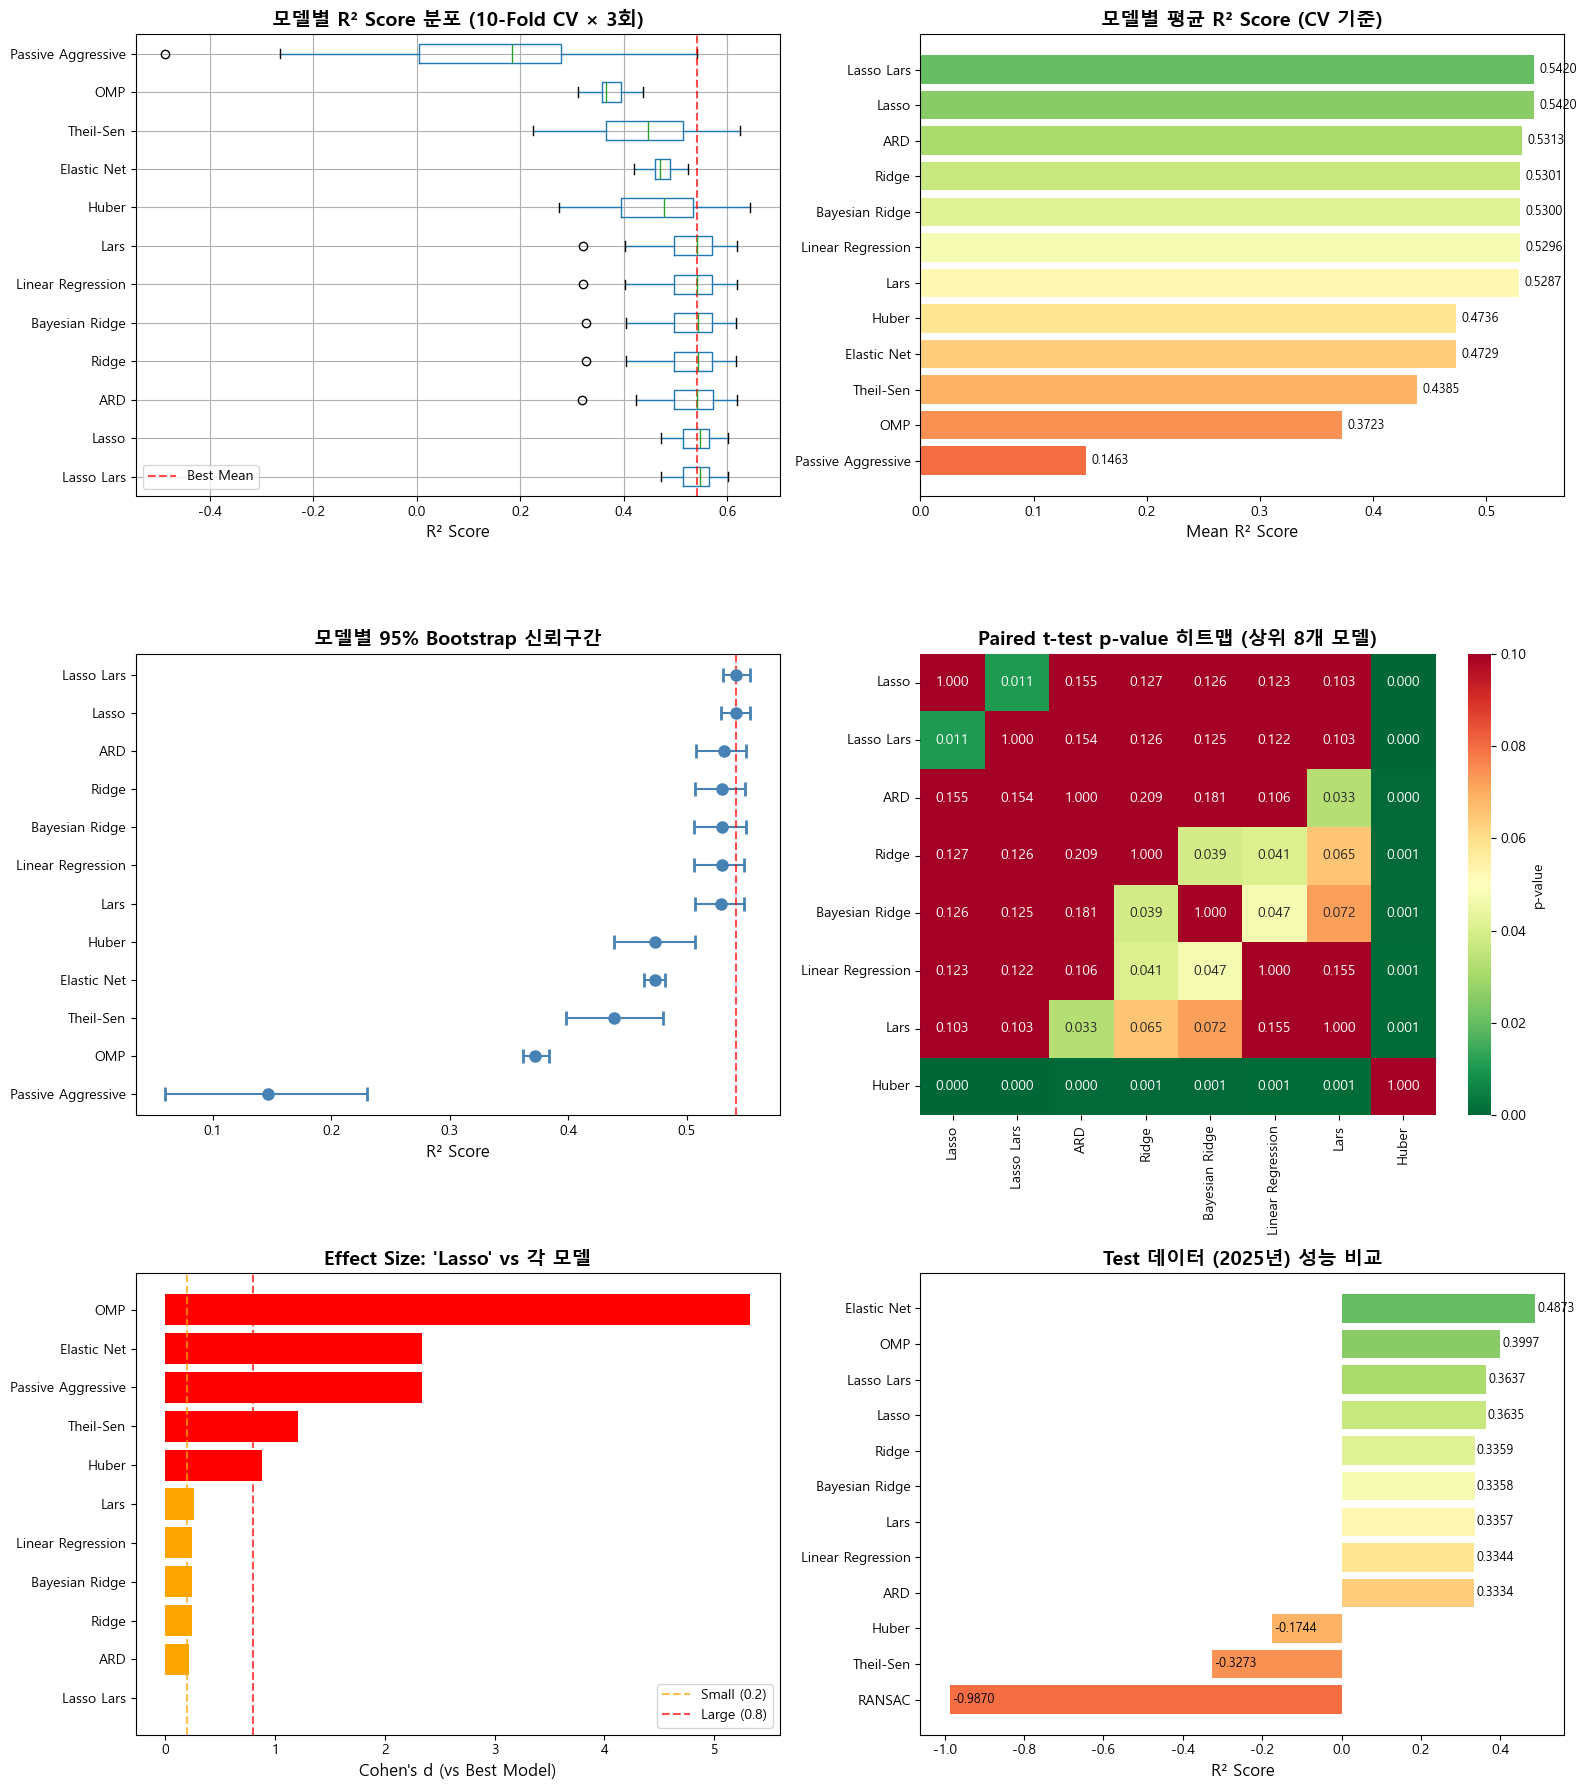


시각화 저장: C:\Users\Administrator\workspace\seoul-auction-prediction\data/model_comparison_visualization.png


In [50]:

# =============================================================================
# 15. 시각화
# =============================================================================
print("\n" + "=" * 80)
print("15. 시각화 생성")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 안정적인 모델만 필터링 (R² > 0인 모델)
stable_models = [col for col in cv_df.columns if cv_df[col].mean() > 0]
cv_df_stable = cv_df[stable_models]

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1) 모델별 R² Score 박스플롯
ax1 = axes[0, 0]
cv_df_stable_sorted = cv_df_stable[cv_df_stable.mean().sort_values(ascending=False).index]
cv_df_stable_sorted.boxplot(ax=ax1, vert=False)
ax1.set_xlabel('R² Score', fontsize=12)
ax1.set_title('모델별 R² Score 분포 (10-Fold CV × 3회)', fontsize=14, fontweight='bold')
ax1.axvline(x=cv_df_stable_sorted.mean().max(), color='red', linestyle='--', alpha=0.7, label='Best Mean')
ax1.legend()

# 2) 평균 R² Score 막대그래프
ax2 = axes[0, 1]
mean_scores = cv_df_stable.mean().sort_values(ascending=True)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(mean_scores)))
bars = ax2.barh(mean_scores.index, mean_scores.values, color=colors)
ax2.set_xlabel('Mean R² Score', fontsize=12)
ax2.set_title('모델별 평균 R² Score (CV 기준)', fontsize=14, fontweight='bold')
for i, (idx, val) in enumerate(mean_scores.items()):
    ax2.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=9)

# 3) 95% 신뢰구간 플롯
ax3 = axes[1, 0]
bootstrap_stable = bootstrap_df[bootstrap_df['Mean R²'] > 0].sort_values('Mean R²', ascending=True)
y_pos = range(len(bootstrap_stable))
ax3.errorbar(bootstrap_stable['Mean R²'], y_pos, 
             xerr=[bootstrap_stable['Mean R²'] - bootstrap_stable['95% CI Lower'],
                   bootstrap_stable['95% CI Upper'] - bootstrap_stable['Mean R²']],
             fmt='o', capsize=5, capthick=2, color='steelblue', markersize=8)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(bootstrap_stable['Model'])
ax3.set_xlabel('R² Score', fontsize=12)
ax3.set_title('모델별 95% Bootstrap 신뢰구간', fontsize=14, fontweight='bold')
ax3.axvline(x=bootstrap_stable['Mean R²'].max(), color='red', linestyle='--', alpha=0.7)

# 4) Paired t-test p-value 히트맵 (상위 모델들)
ax4 = axes[1, 1]
top_models = stats_summary.head(8).index.tolist()
pvalue_matrix = pd.DataFrame(index=top_models, columns=top_models, dtype=float)

for m1 in top_models:
    for m2 in top_models:
        if m1 == m2:
            pvalue_matrix.loc[m1, m2] = 1.0
        else:
            _, p = ttest_rel(cv_df[m1], cv_df[m2])
            pvalue_matrix.loc[m1, m2] = p

sns.heatmap(pvalue_matrix.astype(float), annot=True, fmt='.3f', cmap='RdYlGn_r', 
            ax=ax4, vmin=0, vmax=0.1, cbar_kws={'label': 'p-value'})
ax4.set_title('Paired t-test p-value 히트맵 (상위 8개 모델)', fontsize=14, fontweight='bold')

# 5) Effect Size (Cohen's d) 막대그래프
ax5 = axes[2, 0]
effect_stable = effect_df[effect_df['Model'].isin(stable_models)].sort_values("Cohen's d", ascending=True)
colors_effect = ['green' if d < 0.2 else 'orange' if d < 0.8 else 'red' for d in effect_stable["Cohen's d"].abs()]
ax5.barh(effect_stable['Model'], effect_stable["Cohen's d"], color=colors_effect)
ax5.axvline(x=0.2, color='orange', linestyle='--', alpha=0.7, label='Small (0.2)')
ax5.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='Large (0.8)')
ax5.set_xlabel("Cohen's d (vs Best Model)", fontsize=12)
ax5.set_title(f"Effect Size: '{best_model}' vs 각 모델", fontsize=14, fontweight='bold')
ax5.legend(loc='lower right')

# 6) Test 데이터 (2025) 성능 비교
ax6 = axes[2, 1]
test_stable = df_test[df_test['R² (Test)'] > -1].sort_values('R² (Test)', ascending=True)
colors_test = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(test_stable)))
ax6.barh(test_stable['Model'], test_stable['R² (Test)'], color=colors_test)
ax6.set_xlabel('R² Score', fontsize=12)
ax6.set_title('Test 데이터 (2025년) 성능 비교', fontsize=14, fontweight='bold')
for i, (idx, row) in enumerate(test_stable.iterrows()):
    ax6.text(row['R² (Test)'] + 0.005, i, f'{row["R² (Test)"]:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/model_comparison_visualization.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print(f"\n시각화 저장: {SAVE_PATH}/model_comparison_visualization.png")


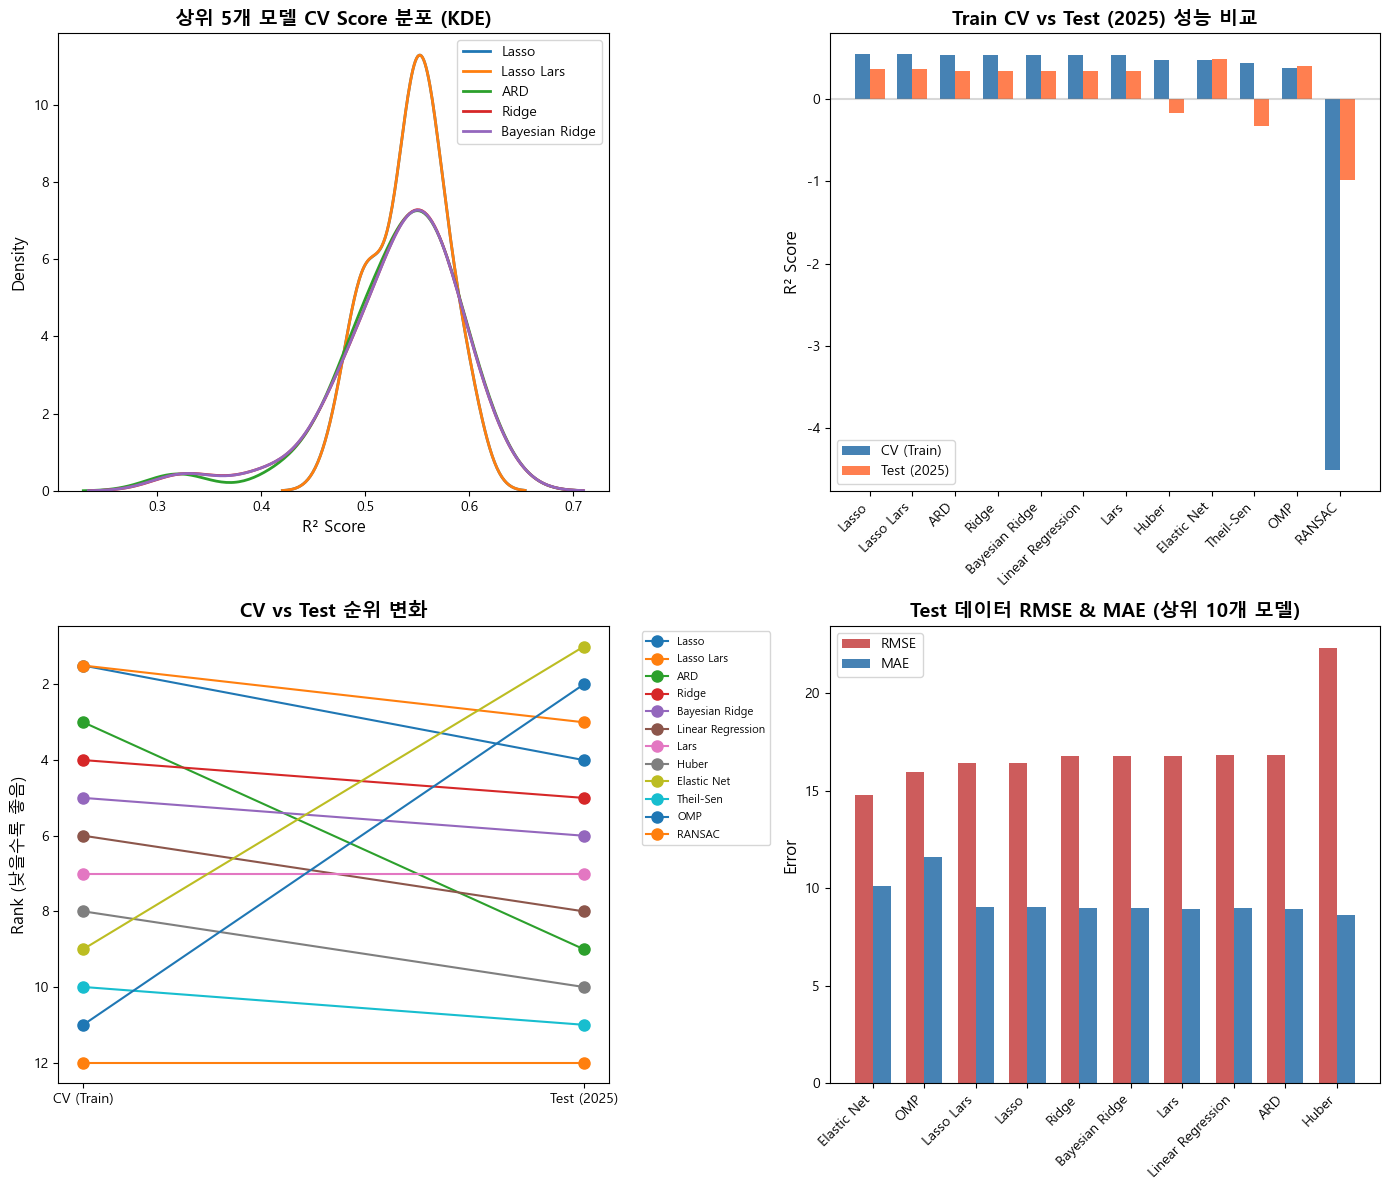

시각화 저장: C:\Users\Administrator\workspace\seoul-auction-prediction\data/model_comparison_visualization_2.png

결과 파일 저장 완료:
  - C:\Users\Administrator\workspace\seoul-auction-prediction\data/model_cv_scores.csv
  - C:\Users\Administrator\workspace\seoul-auction-prediction\data/model_statistics.csv
  - C:\Users\Administrator\workspace\seoul-auction-prediction\data/ttest_results.csv
  - C:\Users\Administrator\workspace\seoul-auction-prediction\data/bootstrap_ci.csv
  - C:\Users\Administrator\workspace\seoul-auction-prediction\data/test_results_2025.csv
  - C:\Users\Administrator\workspace\seoul-auction-prediction\data/model_comparison_visualization.png
  - C:\Users\Administrator\workspace\seoul-auction-prediction\data/model_comparison_visualization_2.png


In [51]:

# =============================================================================
# 16. 추가 시각화: CV Score 분포 비교
# =============================================================================
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 12))

# 1) 상위 5개 모델 KDE 플롯
ax1 = axes2[0, 0]
top_5 = stats_summary.head(5).index.tolist()
for model in top_5:
    if model in cv_df.columns:
        sns.kdeplot(cv_df[model], ax=ax1, label=model, linewidth=2)
ax1.set_xlabel('R² Score', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('상위 5개 모델 CV Score 분포 (KDE)', fontsize=14, fontweight='bold')
ax1.legend()

# 2) Train CV vs Test 성능 비교
ax2 = axes2[0, 1]
comparison_df = pd.merge(
    stats_summary.reset_index().rename(columns={'index': 'Model', 'Mean': 'CV Mean R²'})[['Model', 'CV Mean R²']],
    df_test[['Model', 'R² (Test)']],
    on='Model'
)
comparison_df = comparison_df[comparison_df['R² (Test)'] > -1].sort_values('CV Mean R²', ascending=False)

x = np.arange(len(comparison_df))
width = 0.35
ax2.bar(x - width/2, comparison_df['CV Mean R²'], width, label='CV (Train)', color='steelblue')
ax2.bar(x + width/2, comparison_df['R² (Test)'], width, label='Test (2025)', color='coral')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('Train CV vs Test (2025) 성능 비교', fontsize=14, fontweight='bold')
ax2.legend()
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# 3) 모델 순위 비교 (CV vs Test)
ax3 = axes2[1, 0]
comparison_df['CV Rank'] = comparison_df['CV Mean R²'].rank(ascending=False)
comparison_df['Test Rank'] = comparison_df['R² (Test)'].rank(ascending=False)
for _, row in comparison_df.iterrows():
    ax3.plot([0, 1], [row['CV Rank'], row['Test Rank']], 'o-', markersize=8, label=row['Model'])
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['CV (Train)', 'Test (2025)'])
ax3.set_ylabel('Rank (낮을수록 좋음)', fontsize=12)
ax3.set_title('CV vs Test 순위 변화', fontsize=14, fontweight='bold')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.invert_yaxis()

# 4) RMSE & MAE 비교 (Test)
ax4 = axes2[1, 1]
test_metrics = df_test[df_test['R² (Test)'] > -1].sort_values('RMSE (Test)', ascending=True).head(10)
x = np.arange(len(test_metrics))
width = 0.35
ax4.bar(x - width/2, test_metrics['RMSE (Test)'], width, label='RMSE', color='indianred')
ax4.bar(x + width/2, test_metrics['MAE (Test)'], width, label='MAE', color='steelblue')
ax4.set_xticks(x)
ax4.set_xticklabels(test_metrics['Model'], rotation=45, ha='right')
ax4.set_ylabel('Error', fontsize=12)
ax4.set_title('Test 데이터 RMSE & MAE (상위 10개 모델)', fontsize=14, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/model_comparison_visualization_2.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print(f"시각화 저장: {SAVE_PATH}/model_comparison_visualization_2.png")

print("\n결과 파일 저장 완료:")
print(f"  - {SAVE_PATH}/model_cv_scores.csv")
print(f"  - {SAVE_PATH}/model_statistics.csv")
print(f"  - {SAVE_PATH}/ttest_results.csv")
print(f"  - {SAVE_PATH}/bootstrap_ci.csv")
print(f"  - {SAVE_PATH}/test_results_2025.csv")
print(f"  - {SAVE_PATH}/model_comparison_visualization.png")
print(f"  - {SAVE_PATH}/model_comparison_visualization_2.png")

In [52]:
"""
================================================================================
서울 경매 데이터셋 - Tree 계열 모델 전체 비교 실험
================================================================================
포함 모델:
  [Basic] Decision Tree
  [Bagging] Bagging, Random Forest, Extra Trees
  [Boosting] AdaBoost, Gradient Boosting, HistGradient Boosting
  [External] XGBoost, LightGBM, CatBoost, NGBoost
================================================================================
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    mean_absolute_percentage_error
)
import time

# ============================================================
# 1. 데이터 로드 및 전처리
# ============================================================
print("=" * 70)
print("1. 데이터 로드 및 전처리")
print("=" * 70)

# 데이터 로드

# 타겟 변수 설정
TARGET = 'winning_bid_ratio'

# 제외할 컬럼 (ID, 날짜, 문자열 컬럼)
EXCLUDE_COLS = [
    'm_code', 'case_id', 'appraisal_date', 'sale_date', 
    'district', 'dong', 'purpose',
    TARGET
]

# 피처 선택
feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]
print(f"피처 수: {len(feature_cols)}")
print(f"피처 목록: {feature_cols}")

# X, y 분리
X = df[feature_cols].copy()
y = df[TARGET].copy()

# Train/Test 분리
print(f"Train set: {len(X_train)}, Test set: {len(X_test)}")


1. 데이터 로드 및 전처리
피처 수: 18
피처 목록: ['year', 'floor', 'land_area', 'building_area', 'appraisal_price', 'minimum_price', 'winning_bid_price', 'failed_bid_count', 'deposit', 'registry_amount', 'is_senior', 'traffic_keyword_count', 'is_bad_traffic', 'school_keyword_count', 'has_elevator', 'has_height_limit', 'is_redevelopment', 'is_overcrowding_zone']
Train set: 11697, Test set: 5497


In [60]:
!uv add ngboost

Resolved 35 packages in 4.47s
   Building autograd-gamma==0.5.0
      Built autograd-gamma==0.5.0
Prepared 7 packages in 2.12s
Installed 7 packages in 65ms
 + autograd==1.8.0
 + autograd-gamma==0.5.0
 + formulaic==1.2.1
 + interface-meta==1.3.0
 + lifelines==0.30.0
 + ngboost==0.5.8
 + wrapt==2.0.1


In [61]:
# ============================================================
# 2. 모델 정의
# ============================================================
print("\n" + "=" * 70)
print("2. Tree 계열 모델 정의")
print("=" * 70)

# ──────────────────────────────────────────────────────────────
# Scikit-learn 기본 모델
# ──────────────────────────────────────────────────────────────
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    AdaBoostRegressor,
    BaggingRegressor
)

# ──────────────────────────────────────────────────────────────
# 외부 라이브러리 (선택적 로드)
# ──────────────────────────────────────────────────────────────
xgb_available = False
lgbm_available = False
catboost_available = False
ngboost_available = False

try:
    from xgboost import XGBRegressor
    xgb_available = True
    print("✓ XGBoost 사용 가능")
except ImportError:
    print("✗ XGBoost 미설치 → pip install xgboost")

try:
    from lightgbm import LGBMRegressor
    lgbm_available = True
    print("✓ LightGBM 사용 가능")
except ImportError:
    print("✗ LightGBM 미설치 → pip install lightgbm")

try:
    from catboost import CatBoostRegressor
    catboost_available = True
    print("✓ CatBoost 사용 가능")
except ImportError:
    print("✗ CatBoost 미설치 → pip install catboost")

try:
    from ngboost import NGBRegressor
    ngboost_available = True
    print("✓ NGBoost 사용 가능")
except ImportError:
    print("✗ NGBoost 미설치 → pip install ngboost")


2. Tree 계열 모델 정의
✓ XGBoost 사용 가능
✓ LightGBM 사용 가능
✓ CatBoost 사용 가능
✓ NGBoost 사용 가능


In [62]:
# ──────────────────────────────────────────────────────────────
# 모델 딕셔너리 구성
# ──────────────────────────────────────────────────────────────
models = {}

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [A] Decision Tree 변형
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
models['DecisionTree_default'] = DecisionTreeRegressor(
    random_state=42
)

models['DecisionTree_shallow'] = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

models['DecisionTree_medium'] = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

models['DecisionTree_deep'] = DecisionTreeRegressor(
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [B] Bagging 계열
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
models['Bagging_default'] = BaggingRegressor(
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

models['Bagging_tuned'] = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=15),
    n_estimators=100,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

models['Bagging_large'] = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=20),
    n_estimators=200,
    max_samples=0.7,
    max_features=0.7,
    random_state=42,
    n_jobs=-1
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [C] Random Forest 변형
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
models['RandomForest_default'] = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

models['RandomForest_shallow'] = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

models['RandomForest_tuned'] = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

models['RandomForest_deep'] = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    min_samples_split=2,
    max_features=0.5,
    random_state=42,
    n_jobs=-1
)

models['RandomForest_large'] = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [D] Extra Trees 변형
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
models['ExtraTrees_default'] = ExtraTreesRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

models['ExtraTrees_tuned'] = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

models['ExtraTrees_deep'] = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=25,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [E] AdaBoost 변형
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
models['AdaBoost_default'] = AdaBoostRegressor(
    n_estimators=50,
    random_state=42
)

models['AdaBoost_weak'] = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

models['AdaBoost_medium'] = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=150,
    learning_rate=0.05,
    random_state=42
)

models['AdaBoost_strong'] = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=8),
    n_estimators=200,
    learning_rate=0.01,
    random_state=42
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [F] Gradient Boosting (sklearn) 변형
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
models['GradientBoosting_default'] = GradientBoostingRegressor(
    n_estimators=100,
    random_state=42
)

models['GradientBoosting_fast'] = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.2,
    subsample=1.0,
    random_state=42
)

models['GradientBoosting_tuned'] = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=3,
    subsample=0.8,
    random_state=42
)

models['GradientBoosting_slow'] = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    max_features='sqrt',
    random_state=42
)

models['GradientBoosting_large'] = GradientBoostingRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.02,
    subsample=0.7,
    random_state=42
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [G] HistGradientBoosting (sklearn) 변형
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
models['HistGradientBoosting_default'] = HistGradientBoostingRegressor(
    random_state=42
)

models['HistGradientBoosting_fast'] = HistGradientBoostingRegressor(
    max_iter=100,
    max_depth=6,
    learning_rate=0.2,
    random_state=42
)

models['HistGradientBoosting_tuned'] = HistGradientBoostingRegressor(
    max_iter=200,
    max_depth=10,
    learning_rate=0.1,
    min_samples_leaf=20,
    l2_regularization=0.1,
    random_state=42
)

models['HistGradientBoosting_slow'] = HistGradientBoostingRegressor(
    max_iter=300,
    max_depth=8,
    learning_rate=0.05,
    min_samples_leaf=10,
    l2_regularization=0.2,
    random_state=42
)

models['HistGradientBoosting_large'] = HistGradientBoostingRegressor(
    max_iter=500,
    max_depth=12,
    learning_rate=0.03,
    l2_regularization=0.05,
    random_state=42
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [H] XGBoost 변형 (설치된 경우)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
if xgb_available:
    models['XGBoost_default'] = XGBRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    models['XGBoost_fast'] = XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.2,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    models['XGBoost_tuned'] = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    models['XGBoost_slow'] = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.5,
        reg_lambda=2.0,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    models['XGBoost_large'] = XGBRegressor(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    # XGBoost DART (Dropout)
    models['XGBoost_DART'] = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        booster='dart',
        rate_drop=0.1,
        skip_drop=0.5,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [I] LightGBM 변형 (설치된 경우)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
if lgbm_available:
    models['LightGBM_default'] = LGBMRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    models['LightGBM_fast'] = LGBMRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.2,
        num_leaves=31,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    models['LightGBM_tuned'] = LGBMRegressor(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        num_leaves=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    models['LightGBM_slow'] = LGBMRegressor(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.05,
        num_leaves=40,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    models['LightGBM_large'] = LGBMRegressor(
        n_estimators=500,
        max_depth=12,
        learning_rate=0.02,
        num_leaves=100,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # LightGBM DART
    models['LightGBM_DART'] = LGBMRegressor(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        boosting_type='dart',
        num_leaves=50,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # LightGBM GOSS (Gradient-based One-Side Sampling)
    models['LightGBM_GOSS'] = LGBMRegressor(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        boosting_type='goss',
        num_leaves=50,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [J] CatBoost 변형 (설치된 경우)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
if catboost_available:
    models['CatBoost_default'] = CatBoostRegressor(
        iterations=100,
        random_state=42,
        verbose=0
    )
    
    models['CatBoost_fast'] = CatBoostRegressor(
        iterations=100,
        depth=4,
        learning_rate=0.2,
        random_state=42,
        verbose=0
    )
    
    models['CatBoost_tuned'] = CatBoostRegressor(
        iterations=200,
        depth=6,
        learning_rate=0.1,
        l2_leaf_reg=3,
        subsample=0.8,
        random_state=42,
        verbose=0
    )
    
    models['CatBoost_slow'] = CatBoostRegressor(
        iterations=300,
        depth=5,
        learning_rate=0.05,
        l2_leaf_reg=5,
        subsample=0.7,
        random_state=42,
        verbose=0
    )
    
    models['CatBoost_large'] = CatBoostRegressor(
        iterations=500,
        depth=8,
        learning_rate=0.02,
        random_state=42,
        verbose=0
    )

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# [K] NGBoost (설치된 경우)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
if ngboost_available:
    from sklearn.tree import DecisionTreeRegressor as DTR
    
    models['NGBoost_default'] = NGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        verbose=False
    )
    
    models['NGBoost_tuned'] = NGBRegressor(
        Base=DTR(max_depth=4),
        n_estimators=200,
        learning_rate=0.05,
        random_state=42,
        verbose=False
    )

# 모델 목록 출력
print(f"\n총 {len(models)}개 모델 준비 완료")
print("\n모델 목록:")
for i, (name, _) in enumerate(models.items(), 1):
    print(f"  {i:2d}. {name}")



총 49개 모델 준비 완료

모델 목록:
   1. DecisionTree_default
   2. DecisionTree_shallow
   3. DecisionTree_medium
   4. DecisionTree_deep
   5. Bagging_default
   6. Bagging_tuned
   7. Bagging_large
   8. RandomForest_default
   9. RandomForest_shallow
  10. RandomForest_tuned
  11. RandomForest_deep
  12. RandomForest_large
  13. ExtraTrees_default
  14. ExtraTrees_tuned
  15. ExtraTrees_deep
  16. AdaBoost_default
  17. AdaBoost_weak
  18. AdaBoost_medium
  19. AdaBoost_strong
  20. GradientBoosting_default
  21. GradientBoosting_fast
  22. GradientBoosting_tuned
  23. GradientBoosting_slow
  24. GradientBoosting_large
  25. HistGradientBoosting_default
  26. HistGradientBoosting_fast
  27. HistGradientBoosting_tuned
  28. HistGradientBoosting_slow
  29. HistGradientBoosting_large
  30. XGBoost_default
  31. XGBoost_fast
  32. XGBoost_tuned
  33. XGBoost_slow
  34. XGBoost_large
  35. XGBoost_DART
  36. LightGBM_default
  37. LightGBM_fast
  38. LightGBM_tuned
  39. LightGBM_slow
  40. LightG

In [63]:
# ============================================================
# 3. 평가 함수 정의
# ============================================================
from sklearn.base import clone

def evaluate_model(model, X_train, X_test, y_train, y_test, cv_folds=5):
    """
    모델 학습 및 평가 수행
    """
    results = {}
    
    # 학습 시간 측정
    start_time = time.time()
    model.fit(X_train, y_train)
    results['train_time'] = time.time() - start_time
    
    # 예측 시간 측정
    start_time = time.time()
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    results['pred_time'] = time.time() - start_time
    
    # Train 평가 지표
    results['train_rmse'] = np.sqrt(mean_squared_error(y_train, y_pred_train))
    results['train_mae'] = mean_absolute_error(y_train, y_pred_train)
    results['train_r2'] = r2_score(y_train, y_pred_train)
    results['train_mape'] = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    
    # Test 평가 지표
    results['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_pred_test))
    results['test_mae'] = mean_absolute_error(y_test, y_pred_test)
    results['test_r2'] = r2_score(y_test, y_pred_test)
    results['test_mape'] = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    
    # Cross Validation (수동 구현 - CatBoost 호환성 문제 해결)
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = []
    
    X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
    y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
    
    for train_idx, val_idx in kf.split(X_train_np):
        X_cv_train, X_cv_val = X_train_np[train_idx], X_train_np[val_idx]
        y_cv_train, y_cv_val = y_train_np[train_idx], y_train_np[val_idx]
        
        # 모델 복제 (CatBoost는 clone이 안될 수 있으므로 예외 처리)
        try:
            cv_model = clone(model)
        except:
            # CatBoost 등 clone이 안되는 경우 파라미터로 새 인스턴스 생성
            cv_model = model.__class__(**model.get_params())
        
        # CatBoost verbose 끄기
        if hasattr(cv_model, 'set_params'):
            try:
                cv_model.set_params(verbose=0)
            except:
                pass
        
        cv_model.fit(X_cv_train, y_cv_train)
        y_cv_pred = cv_model.predict(X_cv_val)
        cv_rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
        cv_scores.append(cv_rmse)
    
    results['cv_rmse_mean'] = np.mean(cv_scores)
    results['cv_rmse_std'] = np.std(cv_scores)
    
    # Overfitting 지표
    results['overfit_gap'] = results['train_rmse'] - results['test_rmse']
    results['overfit_ratio'] = results['test_rmse'] / results['train_rmse'] if results['train_rmse'] > 0 else 0
    
    return results

# ============================================================
# 4. 모델 학습 및 평가 실행
# ============================================================
print("\n" + "=" * 70)
print("3. 모델 학습 및 평가")
print("=" * 70)

all_results = []

for i, (name, model) in enumerate(models.items(), 1):
    print(f"\n[{i:2d}/{len(models)}] {name}")
    print("-" * 50)
    
    try:
        results = evaluate_model(model, X_train, X_test, y_train, y_test)
        results['model'] = name
        all_results.append(results)
        
        print(f"  Train RMSE: {results['train_rmse']:.4f}")
        print(f"  Test RMSE:  {results['test_rmse']:.4f}")
        print(f"  CV RMSE:    {results['cv_rmse_mean']:.4f} (±{results['cv_rmse_std']:.4f})")
        print(f"  Test R²:    {results['test_r2']:.4f}")
        print(f"  Train Time: {results['train_time']:.2f}s")
        
    except Exception as e:
        print(f"  ⚠ 오류 발생: {str(e)}")


3. 모델 학습 및 평가

[ 1/49] DecisionTree_default
--------------------------------------------------
  Train RMSE: 0.0000
  Test RMSE:  6.3870
  CV RMSE:    7.3871 (±0.1947)
  Test R²:    0.9040
  Train Time: 0.29s

[ 2/49] DecisionTree_shallow
--------------------------------------------------
  Train RMSE: 10.5088
  Test RMSE:  10.9969
  CV RMSE:    10.6688 (±0.4468)
  Test R²:    0.7153
  Train Time: 0.05s

[ 3/49] DecisionTree_medium
--------------------------------------------------
  Train RMSE: 6.3959
  Test RMSE:  7.4250
  CV RMSE:    7.5244 (±0.3901)
  Test R²:    0.8702
  Train Time: 0.11s

[ 4/49] DecisionTree_deep
--------------------------------------------------
  Train RMSE: 2.4055
  Test RMSE:  5.7050
  CV RMSE:    6.8299 (±0.4551)
  Test R²:    0.9234
  Train Time: 0.26s

[ 5/49] Bagging_default
--------------------------------------------------
  Train RMSE: 1.8938
  Test RMSE:  4.7836
  CV RMSE:    5.3024 (±0.2870)
  Test R²:    0.9461
  Train Time: 10.22s

[ 6/49] Baggin

In [64]:
# ============================================================
# 5. 결과 정리
# ============================================================
print("\n" + "=" * 70)
print("4. 결과 정리")
print("=" * 70)

# DataFrame 생성
results_df = pd.DataFrame(all_results)

# 컬럼 순서 정리
column_order = [
    'model',
    'test_rmse', 'test_mae', 'test_r2', 'test_mape',
    'cv_rmse_mean', 'cv_rmse_std',
    'train_rmse', 'train_mae', 'train_r2', 'train_mape',
    'overfit_gap', 'overfit_ratio',
    'train_time', 'pred_time'
]
results_df = results_df[column_order]

# Test RMSE 기준 정렬
results_df = results_df.sort_values('test_rmse').reset_index(drop=True)
results_df['rank'] = range(1, len(results_df) + 1)

# 순위를 첫 번째 컬럼으로
cols = ['rank'] + [c for c in results_df.columns if c != 'rank']
results_df = results_df[cols]

# 결과 출력
print("\n[Test RMSE 기준 전체 순위]")
print(results_df[['rank', 'model', 'test_rmse', 'cv_rmse_mean', 'test_r2', 'train_time']].to_string(index=False))

# ============================================================
# 6. 카테고리별 분석
# ============================================================
print("\n" + "=" * 70)
print("5. 카테고리별 최고 모델")
print("=" * 70)

categories = {
    'Decision Tree': [m for m in models.keys() if 'DecisionTree' in m],
    'Bagging': [m for m in models.keys() if 'Bagging' in m],
    'Random Forest': [m for m in models.keys() if 'RandomForest' in m],
    'Extra Trees': [m for m in models.keys() if 'ExtraTrees' in m],
    'AdaBoost': [m for m in models.keys() if 'AdaBoost' in m],
    'Gradient Boosting': [m for m in models.keys() if 'GradientBoosting_' in m],
    'HistGradient Boosting': [m for m in models.keys() if 'HistGradientBoosting' in m],
    'XGBoost': [m for m in models.keys() if 'XGBoost' in m],
    'LightGBM': [m for m in models.keys() if 'LightGBM' in m],
    'CatBoost': [m for m in models.keys() if 'CatBoost' in m],
    'NGBoost': [m for m in models.keys() if 'NGBoost' in m],
}

for category, model_names in categories.items():
    if model_names:
        cat_df = results_df[results_df['model'].isin(model_names)]
        if len(cat_df) > 0:
            best = cat_df.iloc[0]
            print(f"\n{category}:")
            print(f"  Best: {best['model']}")
            print(f"  Test RMSE: {best['test_rmse']:.4f}, R²: {best['test_r2']:.4f}")

# 전체 최고 모델
print("\n" + "─" * 50)
best_model = results_df.iloc[0]
print(f"\n🏆 전체 최고 모델: {best_model['model']}")
print(f"   Test RMSE: {best_model['test_rmse']:.4f}")
print(f"   Test R²:   {best_model['test_r2']:.4f}")
print(f"   CV RMSE:   {best_model['cv_rmse_mean']:.4f} (±{best_model['cv_rmse_std']:.4f})")



4. 결과 정리

[Test RMSE 기준 전체 순위]
 rank                        model  test_rmse  cv_rmse_mean  test_r2  train_time
    1                LightGBM_GOSS   2.711446      3.266658 0.982690    0.287393
    2   HistGradientBoosting_tuned   3.037161      3.306075 0.978282    0.642569
    3              XGBoost_default   3.045016      3.512962 0.978169    0.224310
    4               LightGBM_tuned   3.125876      3.539073 0.976994    0.259967
    5                LightGBM_fast   3.162953      3.622016 0.976445    0.080064
    6       GradientBoosting_tuned   3.173635      3.367801 0.976286    4.330150
    7               LightGBM_large   3.182269      3.650004 0.976157    1.084392
    8   HistGradientBoosting_large   3.213735      3.476917 0.975683    1.963961
    9    HistGradientBoosting_slow   3.269837      3.391100 0.974826    0.944816
   10    HistGradientBoosting_fast   3.314950      3.598910 0.974127    0.285352
   11             CatBoost_default   3.393890      3.583862 0.972880    0.411

In [65]:
# ============================================================
# 7. 결과 저장
# ============================================================
print("\n" + "=" * 70)
print("6. 결과 저장")
print("=" * 70)

# CSV 저장
output_path = 'tree_models_comparison_results.csv'
results_df.to_csv(output_path, index=False)
print(f"✓ 결과 저장: {output_path}")


6. 결과 저장
✓ 결과 저장: tree_models_comparison_results.csv


In [66]:
# ============================================================
# 8. 시각화
# ============================================================
print("\n" + "=" * 70)
print("7. 시각화")
print("=" * 70)

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top 15 모델만 시각화
top_n = min(15, len(results_df))
top_df = results_df.head(top_n)

# 8-1. Test RMSE 비교
ax1 = axes[0, 0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, top_n))
bars = ax1.barh(range(top_n), top_df['test_rmse'], color=colors)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_df['model'], fontsize=9)
ax1.set_xlabel('Test RMSE (Lower is Better)')
ax1.set_title(f'Top {top_n} Models: Test RMSE Comparison')
ax1.invert_yaxis()
for i, (bar, val) in enumerate(zip(bars, top_df['test_rmse'])):
    ax1.text(val + 0.1, i, f'{val:.2f}', va='center', fontsize=8)

# 8-2. Test R² 비교
ax2 = axes[0, 1]
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, top_n))
bars = ax2.barh(range(top_n), top_df['test_r2'], color=colors)
ax2.set_yticks(range(top_n))
ax2.set_yticklabels(top_df['model'], fontsize=9)
ax2.set_xlabel('Test R² (Higher is Better)')
ax2.set_title(f'Top {top_n} Models: R² Score Comparison')
ax2.invert_yaxis()
for i, (bar, val) in enumerate(zip(bars, top_df['test_r2'])):
    ax2.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=8)

# 8-3. Train vs Test RMSE (Overfitting 확인)
ax3 = axes[1, 0]
x = np.arange(top_n)
width = 0.35
bars1 = ax3.bar(x - width/2, top_df['train_rmse'], width, label='Train RMSE', alpha=0.8, color='steelblue')
bars2 = ax3.bar(x + width/2, top_df['test_rmse'], width, label='Test RMSE', alpha=0.8, color='coral')
ax3.set_xlabel('Model')
ax3.set_ylabel('RMSE')
ax3.set_title('Train vs Test RMSE (Overfitting Check)')
ax3.set_xticks(x)
ax3.set_xticklabels(top_df['model'], rotation=45, ha='right', fontsize=8)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 8-4. 학습 시간 비교
ax4 = axes[1, 1]
bars = ax4.barh(range(top_n), top_df['train_time'], color='teal', alpha=0.7)
ax4.set_yticks(range(top_n))
ax4.set_yticklabels(top_df['model'], fontsize=9)
ax4.set_xlabel('Training Time (seconds)')
ax4.set_title(f'Top {top_n} Models: Training Time Comparison')
ax4.invert_yaxis()
for i, (bar, val) in enumerate(zip(bars, top_df['train_time'])):
    ax4.text(val + 0.05, i, f'{val:.2f}s', va='center', fontsize=8)

plt.tight_layout()
fig_path = 'tree_models_comparison_plot.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"✓ 시각화 저장: {fig_path}")



7. 시각화
✓ 시각화 저장: tree_models_comparison_plot.png


In [67]:
# ============================================================
# 9. 추가 분석: 성능 vs 속도 트레이드오프
# ============================================================
print("\n" + "=" * 70)
print("8. 성능 vs 속도 트레이드오프 분석")
print("=" * 70)

fig2, ax = plt.subplots(figsize=(12, 8))

# 산점도
scatter = ax.scatter(
    results_df['train_time'], 
    results_df['test_rmse'],
    c=results_df['test_r2'],
    cmap='RdYlGn',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidths=0.5
)

# 상위 5개 모델 라벨링
for idx, row in results_df.head(5).iterrows():
    ax.annotate(
        row['model'],
        (row['train_time'], row['test_rmse']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        alpha=0.8
    )

ax.set_xlabel('Training Time (seconds)')
ax.set_ylabel('Test RMSE (Lower is Better)')
ax.set_title('Performance vs Speed Trade-off')
plt.colorbar(scatter, label='Test R²')
ax.grid(True, alpha=0.3)

fig2_path = 'tree_models_tradeoff_plot.png'
plt.savefig(fig2_path, dpi=150, bbox_inches='tight')
print(f"✓ 트레이드오프 시각화 저장: {fig2_path}")


8. 성능 vs 속도 트레이드오프 분석
✓ 트레이드오프 시각화 저장: tree_models_tradeoff_plot.png


In [68]:
# ============================================================
# 10. 최종 요약
# ============================================================
print("\n" + "=" * 70)
print("9. 최종 요약")
print("=" * 70)

print("\n[상위 10개 모델]")
summary_cols = ['rank', 'model', 'test_rmse', 'test_r2', 'cv_rmse_mean', 'train_time']
print(results_df[summary_cols].head(10).to_string(index=False))

print("\n[모델 유형별 요약]")
type_summary = []
for category, model_names in categories.items():
    if model_names:
        cat_df = results_df[results_df['model'].isin(model_names)]
        if len(cat_df) > 0:
            type_summary.append({
                'Category': category,
                'Best_Model': cat_df.iloc[0]['model'],
                'Best_RMSE': cat_df.iloc[0]['test_rmse'],
                'Best_R2': cat_df.iloc[0]['test_r2'],
                'Avg_RMSE': cat_df['test_rmse'].mean(),
                'Avg_Time': cat_df['train_time'].mean()
            })

type_df = pd.DataFrame(type_summary).sort_values('Best_RMSE')
print(type_df.to_string(index=False))

print("\n" + "=" * 70)
print("✅ 모든 실험 완료!")
print("=" * 70)


9. 최종 요약

[상위 10개 모델]
 rank                      model  test_rmse  test_r2  cv_rmse_mean  train_time
    1              LightGBM_GOSS   2.711446 0.982690      3.266658    0.287393
    2 HistGradientBoosting_tuned   3.037161 0.978282      3.306075    0.642569
    3            XGBoost_default   3.045016 0.978169      3.512962    0.224310
    4             LightGBM_tuned   3.125876 0.976994      3.539073    0.259967
    5              LightGBM_fast   3.162953 0.976445      3.622016    0.080064
    6     GradientBoosting_tuned   3.173635 0.976286      3.367801    4.330150
    7             LightGBM_large   3.182269 0.976157      3.650004    1.084392
    8 HistGradientBoosting_large   3.213735 0.975683      3.476917    1.963961
    9  HistGradientBoosting_slow   3.269837 0.974826      3.391100    0.944816
   10  HistGradientBoosting_fast   3.314950 0.974127      3.598910    0.285352

[모델 유형별 요약]
             Category                 Best_Model  Best_RMSE  Best_R2  Avg_RMSE  Avg_Time
      

In [ ]:
"""
================================================================================
LightGBM GOSS vs 2-Stage 모델 성능 비교
================================================================================
"""

import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# 1. 모델 로드
# ============================================================
print("=" * 70)
print("1. 모델 로드")
print("=" * 70)

# 모델 파일 경로 (로컬 환경에 맞게 수정)
LGBM_PATH = 'C:\Users\Administrator\workspace\seoul-auction-prediction\models\lightgbm_goss_model.pkl
CLASSIFIER_PATH = 'C:\Users\Administrator\workspace\seoul-auction-prediction\models\2stage_classifier.pkl
HUBER_SUCCESS_PATH = 'C:\Users\Administrator\workspace\seoul-auction-prediction\models\2stage_huber_success.pkl
HUBER_FAIL_PATH = 'C:\Users\Administrator\workspace\seoul-auction-prediction\models\2stage_huber_fail.pkl
DATA_PATH = 'seoul_auction_featured_dataset_final_0128.csv'

# LightGBM GOSS
lgbm_model = joblib.load(LGBM_PATH)
print(f"✓ LightGBM GOSS 로드 완료")

# 2-Stage 모델
classifier = joblib.load(CLASSIFIER_PATH)
huber_success = joblib.load(HUBER_SUCCESS_PATH)
huber_fail = joblib.load(HUBER_FAIL_PATH)
print(f"✓ 2-Stage 모델 로드 완료 (Classifier + Huber Success + Huber Fail)")

# ============================================================
# 2. 모델 피처 확인
# ============================================================
print("\n" + "=" * 70)
print("2. 모델 피처 확인")
print("=" * 70)

# LightGBM 피처
if hasattr(lgbm_model, 'feature_name_'):
    lgbm_features = lgbm_model.feature_name_
elif hasattr(lgbm_model, 'booster_'):
    lgbm_features = lgbm_model.booster_.feature_name()
else:
    lgbm_features = None

print(f"LightGBM 피처 수: {lgbm_model.n_features_in_}")
print(f"LightGBM 피처: {lgbm_features}")

# 2-Stage 피처
if hasattr(classifier, 'feature_names_in_'):
    stage2_features = list(classifier.feature_names_in_)
elif hasattr(classifier, 'feature_name_'):
    stage2_features = classifier.feature_name_
else:
    stage2_features = None

stage2_n_features = classifier.n_features_in_ if hasattr(classifier, 'n_features_in_') else 'N/A'
print(f"\n2-Stage Classifier 피처 수: {stage2_n_features}")
print(f"2-Stage Classifier 피처: {stage2_features}")

# ============================================================
# 3. 데이터 로드
# ============================================================
print("\n" + "=" * 70)
print("3. 데이터 로드")
print("=" * 70)

df = pd.read_csv(DATA_PATH)
print(f"데이터 shape: {df.shape}")

TARGET = 'winning_bid_ratio'

# ============================================================
# 4. 데이터 준비
# ============================================================
print("\n" + "=" * 70)
print("4. 데이터 준비")
print("=" * 70)

# 필요한 모든 피처 수집
all_features = set()
if lgbm_features:
    all_features.update(lgbm_features)
if stage2_features:
    all_features.update(stage2_features)

# 누락 피처 확인
missing_features = [f for f in all_features if f not in df.columns]
if missing_features:
    print(f"⚠ 데이터에 없는 피처: {missing_features}")

# 결측치 제거
feature_cols = [f for f in all_features if f in df.columns]
valid_mask = ~(df[feature_cols].isna().any(axis=1) | df[TARGET].isna())
df_valid = df[valid_mask].reset_index(drop=True)
print(f"유효 데이터 수: {len(df_valid)}")

# Train/Test 분리 (random_state=42로 동일하게)
y = df_valid[TARGET]
train_idx, test_idx = train_test_split(
    df_valid.index, test_size=0.2, random_state=42
)

df_test = df_valid.loc[test_idx].reset_index(drop=True)
y_test = df_test[TARGET].values
print(f"Test 데이터 수: {len(df_test)}")

# ============================================================
# 5. LightGBM GOSS 예측
# ============================================================
print("\n" + "=" * 70)
print("5. LightGBM GOSS 예측")
print("=" * 70)

if lgbm_features:
    X_test_lgbm = df_test[lgbm_features]
    y_pred_lgbm = lgbm_model.predict(X_test_lgbm)
    
    lgbm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
    lgbm_mae = mean_absolute_error(y_test, y_pred_lgbm)
    lgbm_r2 = r2_score(y_test, y_pred_lgbm)
    lgbm_mape = np.mean(np.abs(y_test - y_pred_lgbm) / y_test) * 100
    
    print(f"RMSE: {lgbm_rmse:.4f}")
    print(f"MAE:  {lgbm_mae:.4f}")
    print(f"R²:   {lgbm_r2:.4f}")
    print(f"MAPE: {lgbm_mape:.2f}%")
else:
    print("⚠ LightGBM 피처를 확인할 수 없습니다.")
    y_pred_lgbm = None
    lgbm_rmse = lgbm_mae = lgbm_r2 = lgbm_mape = None

# ============================================================
# 6. 2-Stage 모델 예측
# ============================================================
print("\n" + "=" * 70)
print("6. 2-Stage 모델 예측")
print("=" * 70)

if stage2_features:
    X_test_2stage = df_test[stage2_features]
    
    # Stage 1: 성공/실패 분류
    y_class_pred = classifier.predict(X_test_2stage)
    
    success_count = sum(y_class_pred)
    fail_count = len(y_class_pred) - success_count
    print(f"분류 결과 - 성공 예측: {success_count}개, 실패 예측: {fail_count}개")
    
    # Stage 2: 조건부 회귀
    y_pred_2stage = np.zeros(len(X_test_2stage))
    
    success_mask = y_class_pred == 1
    fail_mask = y_class_pred == 0
    
    if sum(success_mask) > 0:
        y_pred_2stage[success_mask] = huber_success.predict(X_test_2stage[success_mask])
    if sum(fail_mask) > 0:
        y_pred_2stage[fail_mask] = huber_fail.predict(X_test_2stage[fail_mask])
    
    stage2_rmse = np.sqrt(mean_squared_error(y_test, y_pred_2stage))
    stage2_mae = mean_absolute_error(y_test, y_pred_2stage)
    stage2_r2 = r2_score(y_test, y_pred_2stage)
    stage2_mape = np.mean(np.abs(y_test - y_pred_2stage) / y_test) * 100
    
    print(f"\nRMSE: {stage2_rmse:.4f}")
    print(f"MAE:  {stage2_mae:.4f}")
    print(f"R²:   {stage2_r2:.4f}")
    print(f"MAPE: {stage2_mape:.2f}%")
else:
    print("⚠ 2-Stage 피처를 확인할 수 없습니다.")
    y_pred_2stage = None
    stage2_rmse = stage2_mae = stage2_r2 = stage2_mape = None

# ============================================================
# 7. 성능 비교 요약
# ============================================================
print("\n" + "=" * 70)
print("7. 성능 비교 요약")
print("=" * 70)

if y_pred_lgbm is not None and y_pred_2stage is not None:
    comparison_df = pd.DataFrame({
        'Model': ['LightGBM GOSS', '2-Stage (Classifier + Huber)'],
        'RMSE': [lgbm_rmse, stage2_rmse],
        'MAE': [lgbm_mae, stage2_mae],
        'R²': [lgbm_r2, stage2_r2],
        'MAPE (%)': [lgbm_mape, stage2_mape]
    })
    
    print(comparison_df.to_string(index=False))
    
    # 승자 표시
    print("\n" + "-" * 50)
    print("[비교 결과]")
    
    if lgbm_rmse < stage2_rmse:
        rmse_winner = "LightGBM GOSS"
        print(f"✓ RMSE: LightGBM GOSS 승 ({lgbm_rmse:.4f} < {stage2_rmse:.4f})")
    else:
        rmse_winner = "2-Stage"
        print(f"✓ RMSE: 2-Stage 승 ({stage2_rmse:.4f} < {lgbm_rmse:.4f})")
    
    if lgbm_mae < stage2_mae:
        mae_winner = "LightGBM GOSS"
        print(f"✓ MAE:  LightGBM GOSS 승 ({lgbm_mae:.4f} < {stage2_mae:.4f})")
    else:
        mae_winner = "2-Stage"
        print(f"✓ MAE:  2-Stage 승 ({stage2_mae:.4f} < {lgbm_mae:.4f})")
    
    if lgbm_r2 > stage2_r2:
        r2_winner = "LightGBM GOSS"
        print(f"✓ R²:   LightGBM GOSS 승 ({lgbm_r2:.4f} > {stage2_r2:.4f})")
    else:
        r2_winner = "2-Stage"
        print(f"✓ R²:   2-Stage 승 ({stage2_r2:.4f} > {lgbm_r2:.4f})")
    
    if lgbm_mape < stage2_mape:
        mape_winner = "LightGBM GOSS"
        print(f"✓ MAPE: LightGBM GOSS 승 ({lgbm_mape:.2f}% < {stage2_mape:.2f}%)")
    else:
        mape_winner = "2-Stage"
        print(f"✓ MAPE: 2-Stage 승 ({stage2_mape:.2f}% < {lgbm_mape:.2f}%)")

# ============================================================
# 8. 오차 분포 비교
# ============================================================
print("\n" + "=" * 70)
print("8. 오차 분포 비교")
print("=" * 70)

if y_pred_lgbm is not None and y_pred_2stage is not None:
    lgbm_errors = np.abs(y_test - y_pred_lgbm)
    stage2_errors = np.abs(y_test - y_pred_2stage)
    
    print(f"{'오차 범위':<12} {'LightGBM GOSS':<22} {'2-Stage':<22} {'Winner':<12}")
    print("-" * 68)
    
    thresholds = [1, 3, 5, 10]
    for t in thresholds:
        lgbm_count = (lgbm_errors <= t).sum()
        stage2_count = (stage2_errors <= t).sum()
        lgbm_pct = lgbm_count / len(lgbm_errors) * 100
        stage2_pct = stage2_count / len(stage2_errors) * 100
        winner = "LGBM" if lgbm_count > stage2_count else ("2-Stage" if stage2_count > lgbm_count else "Tie")
        print(f"≤ {t}%{'':<8} {lgbm_count:>5}개 ({lgbm_pct:>5.1f}%){'':<5} {stage2_count:>5}개 ({stage2_pct:>5.1f}%){'':<5} {winner}")
    
    lgbm_over10 = (lgbm_errors > 10).sum()
    stage2_over10 = (stage2_errors > 10).sum()
    winner = "LGBM" if lgbm_over10 < stage2_over10 else ("2-Stage" if stage2_over10 < lgbm_over10 else "Tie")
    print(f"> 10%{'':<7} {lgbm_over10:>5}개 ({lgbm_over10/len(lgbm_errors)*100:>5.1f}%){'':<5} {stage2_over10:>5}개 ({stage2_over10/len(stage2_errors)*100:>5.1f}%){'':<5} {winner}")

# ============================================================
# 9. 샘플 예측 비교 (20개)
# ============================================================
print("\n" + "=" * 70)
print("9. 샘플 예측 비교 (20개)")
print("=" * 70)

if y_pred_lgbm is not None and y_pred_2stage is not None:
    sample_df = pd.DataFrame({
        'case_id': df_test['case_id'].values[:20],
        'district': df_test['district'].values[:20],
        'actual': np.round(y_test[:20], 2),
        'lgbm_pred': np.round(y_pred_lgbm[:20], 2),
        'lgbm_err': np.round(np.abs(y_test[:20] - y_pred_lgbm[:20]), 2),
        '2stg_pred': np.round(y_pred_2stage[:20], 2),
        '2stg_err': np.round(np.abs(y_test[:20] - y_pred_2stage[:20]), 2)
    })
    
    sample_df['winner'] = np.where(
        sample_df['lgbm_err'] < sample_df['2stg_err'], 
        'LGBM', 
        np.where(sample_df['lgbm_err'] > sample_df['2stg_err'], '2Stg', 'Tie')
    )
    
    print(sample_df.to_string(index=False))
    
    lgbm_wins = (sample_df['winner'] == 'LGBM').sum()
    stage2_wins = (sample_df['winner'] == '2Stg').sum()
    ties = (sample_df['winner'] == 'Tie').sum()
    
    print(f"\n[20개 샘플 중 승리 횟수]")
    print(f"  LightGBM GOSS: {lgbm_wins}개")
    print(f"  2-Stage:       {stage2_wins}개")
    print(f"  동점:          {ties}개")

# ============================================================
# 10. 최종 결론
# ============================================================
print("\n" + "=" * 70)
print("10. 최종 결론")
print("=" * 70)

if y_pred_lgbm is not None and y_pred_2stage is not None:
    scores = {'LightGBM GOSS': 0, '2-Stage': 0}
    
    if lgbm_rmse < stage2_rmse: scores['LightGBM GOSS'] += 1
    else: scores['2-Stage'] += 1
    
    if lgbm_mae < stage2_mae: scores['LightGBM GOSS'] += 1
    else: scores['2-Stage'] += 1
    
    if lgbm_r2 > stage2_r2: scores['LightGBM GOSS'] += 1
    else: scores['2-Stage'] += 1
    
    if lgbm_mape < stage2_mape: scores['LightGBM GOSS'] += 1
    else: scores['2-Stage'] += 1
    
    print(f"지표별 승리 횟수:")
    print(f"  LightGBM GOSS: {scores['LightGBM GOSS']}/4")
    print(f"  2-Stage:       {scores['2-Stage']}/4")
    
    if scores['LightGBM GOSS'] > scores['2-Stage']:
        print(f"\n🏆 최종 승자: LightGBM GOSS")
    elif scores['2-Stage'] > scores['LightGBM GOSS']:
        print(f"\n🏆 최종 승자: 2-Stage Model")
    else:
        print(f"\n🏆 최종 결과: 무승부")

print("\n" + "=" * 70)
print("✅ 비교 완료!")
print("=" * 70)

2단계 모델

In [70]:
# ============================================================
# 🚀 2단계 모델 (분류 → 회귀) + 자동 분석 파이프라인
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import HuberRegressor
from scipy.stats import wilcoxon
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("🚀 2단계 모델 (분류 → 회귀) + 자동 분석 파이프라인")
print("=" * 80)

# Array 변환
y_train_array = y_train.values if hasattr(y_train, 'values') else y_train
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test

# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   Train: {X_train.shape}")
print(f"   Test: {X_test.shape}")
print(f"   ✅ 데이터 준비 완료")


🚀 2단계 모델 (분류 → 회귀) + 자동 분석 파이프라인
   Train: (11697, 18)
   Test: (5497, 18)
   ✅ 데이터 준비 완료


In [71]:

# Baseline 로드
baseline_pred = None
if 'final_ensemble_pred' in checkpoint:
    baseline_pred = checkpoint['final_ensemble_pred']
    print(f"   ✅ Baseline 로드 완료")
elif 'ensemble_pred' in checkpoint:
    baseline_pred = checkpoint['ensemble_pred']
    print(f"   ✅ Baseline 로드 완료 (ensemble_pred)")
else:
    print(f"   ⚠️ Baseline 없음")


NameError: name 'checkpoint' is not defined

In [ ]:

# ============================================================
# [1] Stage 1: 분류 모델 (유찰 vs 낙찰)
# ============================================================

print("\n" + "=" * 80)
print("[1] Stage 1: 분류 모델 (유찰 vs 낙찰)")
print("=" * 80)

# 임계값 설정
threshold = 0.5
y_class_train = (y_train_array < threshold).astype(int)
y_class_test = (y_test_array < threshold).astype(int)

print(f"\n임계값: {threshold}")
print(f"유찰 케이스 (train): {y_class_train.sum()}개 ({y_class_train.sum()/len(y_class_train)*100:.1f}%)")
print(f"유찰 케이스 (test): {y_class_test.sum()}개 ({y_class_test.sum()/len(y_class_test)*100:.1f}%)")

# 분류 모델 (RandomForest with tuning)
print("\n분류 모델 학습 중...")

clf_params = {
    'n_estimators': 1000,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'class_weight': 'balanced',  # 불균형 처리!
    'random_state': 42,
    'n_jobs': -1
}

clf = RandomForestClassifier(**clf_params)
clf.fit(X_train_scaled, y_class_train)

# 분류 성능 평가
y_class_pred_train = clf.predict(X_train_scaled)
y_class_pred_test = clf.predict(X_test_scaled)

print("\n[Train 분류 성능]")
print(classification_report(y_class_train, y_class_pred_train,
                          target_names=['낙찰', '유찰'],
                          digits=3))

print("\n[Test 분류 성능]")
print(classification_report(y_class_test, y_class_pred_test,
                          target_names=['낙찰', '유찰'],
                          digits=3))

# Confusion Matrix
cm = confusion_matrix(y_class_test, y_class_pred_test)
print("\n[Confusion Matrix]")
print(f"   TN: {cm[0,0]:4d}  FP: {cm[0,1]:4d}")
print(f"   FN: {cm[1,0]:4d}  TP: {cm[1,1]:4d}")

# ============================================================
# [2] Stage 2: 그룹별 회귀 모델
# ============================================================

print("\n" + "=" * 80)
print("[2] Stage 2: 그룹별 회귀 모델")
print("=" * 80)

# Train 그룹 분리
fail_mask_train = (y_class_pred_train == 1)
success_mask_train = (y_class_pred_train == 0)

X_fail_train = X_train_scaled[fail_mask_train]
y_fail_train = y_train_array[fail_mask_train]

X_success_train = X_train_scaled[success_mask_train]
y_success_train = y_train_array[success_mask_train]

print(f"\n[Train 그룹 분리]")
print(f"   유찰 그룹: {len(X_fail_train)}개")
print(f"   낙찰 그룹: {len(X_success_train)}개")

# 2.1 유찰 그룹 모델 (저가 전용)
print("\n유찰 그룹 모델 학습 중...")

huber_fail = HuberRegressor(
    epsilon=1.1,      # 더 공격적 (이상치에 덜 민감)
    alpha=0.00001,    # 정규화 약하게
    max_iter=500
)
huber_fail.fit(X_fail_train, y_fail_train)

# 검증
fail_pred_train = huber_fail.predict(X_fail_train)
fail_mae_train = mean_absolute_error(y_fail_train, fail_pred_train)
print(f"   유찰 그룹 Train MAE: {fail_mae_train:.4f}")

# 2.2 낙찰 그룹 모델 (정상가 전용)
print("\n낙찰 그룹 모델 학습 중...")

huber_success = HuberRegressor(
    epsilon=1.35,     # 기본값
    alpha=0.0001,
    max_iter=200
)
huber_success.fit(X_success_train, y_success_train)

# 검증
success_pred_train = huber_success.predict(X_success_train)
success_mae_train = mean_absolute_error(y_success_train, success_pred_train)
print(f"   낙찰 그룹 Train MAE: {success_mae_train:.4f}")

print(f"\n✅ Stage 2 학습 완료")

# ============================================================
# [3] 2단계 예측 (Test)
# ============================================================

print("\n" + "=" * 80)
print("[3] 2단계 예측")
print("=" * 80)

# Test 그룹 분리
fail_mask_test = (y_class_pred_test == 1)
success_mask_test = (y_class_pred_test == 0)

print(f"\n[Test 그룹 분리]")
print(f"   유찰 예측: {fail_mask_test.sum()}개")
print(f"   낙찰 예측: {success_mask_test.sum()}개")

# 그룹별 예측
pred_2stage = np.zeros(len(X_test_scaled))

pred_2stage[success_mask_test] = huber_success.predict(
    X_test_scaled[success_mask_test]
)
pred_2stage[fail_mask_test] = huber_fail.predict(
    X_test_scaled[fail_mask_test]
)

print(f"\n✅ 2단계 예측 완료")

# ============================================================
# [4] 평가
# ============================================================

print("\n" + "=" * 80)
print("[4] 평가")
print("=" * 80)

# 전체 성능
mae_total = mean_absolute_error(y_test_array, pred_2stage)
print(f"\n[전체 성능]")
print(f"   2-Stage MAE: {mae_total:.4f}")

baseline_mae = 0.0715
improvement = (baseline_mae - mae_total) / baseline_mae * 100
print(f"   Baseline MAE: {baseline_mae:.4f}")
print(f"   개선: {improvement:+.1f}%")

# 저가 구간
low_mask = (y_test_array < 0.5)
mae_low = mean_absolute_error(y_test_array[low_mask], pred_2stage[low_mask])
baseline_low = 0.0805

print(f"\n[저가 구간 (실제 유찰)]")
print(f"   2-Stage MAE: {mae_low:.4f}")
print(f"   Baseline MAE: {baseline_low:.4f}")
print(f"   개선: {(baseline_low - mae_low) / baseline_low * 100:+.1f}%")

# 고가 구간
high_mask = (y_test_array >= 0.5)
mae_high = mean_absolute_error(y_test_array[high_mask], pred_2stage[high_mask])
baseline_high = 0.0710  # Baseline 고가 구간

print(f"\n[고가 구간 (실제 낙찰)]")
print(f"   2-Stage MAE: {mae_high:.4f}")
print(f"   Baseline MAE: {baseline_high:.4f}")
print(f"   개선: {(baseline_high - mae_high) / baseline_high * 100:+.1f}%")

# Within 5%p
abs_errors = np.abs(pred_2stage - y_test_array)
within_5p_total = (abs_errors <= 0.05).sum() / len(abs_errors) * 100
within_5p_low = (abs_errors[low_mask] <= 0.05).sum() / low_mask.sum() * 100
within_5p_high = (abs_errors[high_mask] <= 0.05).sum() / high_mask.sum() * 100

print(f"\n[Within 5%p]")
print(f"   전체: {within_5p_total:.1f}% (Baseline: 49.7%, {within_5p_total - 49.7:+.1f}%p)")
print(f"   저가: {within_5p_low:.1f}% (Baseline: 25.7%, {within_5p_low - 25.7:+.1f}%p)")
print(f"   고가: {within_5p_high:.1f}% (Baseline: 51.1%, {within_5p_high - 51.1:+.1f}%p)")

# Within 10%p
within_10p_total = (abs_errors <= 0.10).sum() / len(abs_errors) * 100
print(f"\n[Within 10%p]")
print(f"   전체: {within_10p_total:.1f}% (Baseline: 85.7%)")

# ============================================================
# [5] 통계적 유의성 검정
# ============================================================

print("\n" + "=" * 80)
print("[5] 통계적 유의성 검정")
print("=" * 80)

if baseline_pred is not None:
    # Wilcoxon Signed-Rank Test
    errors_baseline = np.abs(baseline_pred - y_test_array)
    errors_2stage = np.abs(pred_2stage - y_test_array)

    statistic, p_value = wilcoxon(errors_baseline, errors_2stage, alternative='greater')

    print(f"\n[Wilcoxon Signed-Rank Test]")
    print(f"   H0: Baseline ≤ 2-Stage")
    print(f"   H1: Baseline > 2-Stage (2-Stage가 더 좋음)")
    print(f"   Statistic: {statistic:.0f}")
    print(f"   p-value: {p_value:.6f}")

    if p_value < 0.05:
        print(f"   ✅ 유의수준 0.05에서 유의! (2-Stage가 통계적으로 우수)")
    elif p_value < 0.10:
        print(f"   ⚠️ 유의수준 0.10에서 유의 (약한 증거)")
    else:
        print(f"   ❌ 통계적으로 유의하지 않음")

    # Cohen's d (Effect Size)
    mean_diff = errors_baseline.mean() - errors_2stage.mean()
    pooled_std = np.sqrt((errors_baseline.std()**2 + errors_2stage.std()**2) / 2)
    cohens_d = mean_diff / pooled_std

    print(f"\n[Cohen's d (Effect Size)]")
    print(f"   Cohen's d: {cohens_d:.6f}")

    if abs(cohens_d) < 0.2:
        effect = "무시 가능 (negligible)"
    elif abs(cohens_d) < 0.5:
        effect = "작음 (small)"
    elif abs(cohens_d) < 0.8:
        effect = "중간 (medium)"
    else:
        effect = "큼 (large)"

    print(f"   효과 크기: {effect}")

    # 저가 구간 따로
    print(f"\n[저가 구간 Wilcoxon Test]")
    errors_baseline_low = errors_baseline[low_mask]
    errors_2stage_low = errors_2stage[low_mask]

    statistic_low, p_value_low = wilcoxon(errors_baseline_low, errors_2stage_low, alternative='greater')

    print(f"   Statistic: {statistic_low:.0f}")
    print(f"   p-value: {p_value_low:.6f}")

    if p_value_low < 0.05:
        print(f"   ✅ 저가 구간 개선 유의!")
    else:
        print(f"   ⚠️ 저가 구간 개선 미미")

# ============================================================
# [6] 혼동행렬
# ============================================================

print("\n" + "=" * 80)
print("[6] 혼동행렬")
print("=" * 80)

def categorize_error(error):
    if error <= 0.03:
        return 'Excellent'
    elif error <= 0.05:
        return 'Good'
    elif error <= 0.10:
        return 'Fair'
    else:
        return 'Poor'

# 2-Stage
categories_2stage = [categorize_error(e) for e in abs_errors]
counts_2stage = Counter(categories_2stage)

total = len(abs_errors)

print("\n[2-Stage Model]")
print(f"   Excellent (≤3%p): {counts_2stage['Excellent']/total*100:.1f}%")
print(f"   Good (3~5%p):     {counts_2stage['Good']/total*100:.1f}%")
print(f"   Fair (5~10%p):    {counts_2stage['Fair']/total*100:.1f}%")
print(f"   Poor (>10%p):     {counts_2stage['Poor']/total*100:.1f}%")

# Baseline 비교
if baseline_pred is not None:
    categories_baseline = [categorize_error(e) for e in errors_baseline]
    counts_baseline = Counter(categories_baseline)

    print("\n[Baseline (Ensemble)]")
    print(f"   Excellent (≤3%p): {counts_baseline['Excellent']/total*100:.1f}%")
    print(f"   Good (3~5%p):     {counts_baseline['Good']/total*100:.1f}%")
    print(f"   Fair (5~10%p):    {counts_baseline['Fair']/total*100:.1f}%")
    print(f"   Poor (>10%p):     {counts_baseline['Poor']/total*100:.1f}%")

    print("\n[개선율]")
    improvements = {
        'Excellent': (counts_2stage['Excellent'] - counts_baseline['Excellent'])/total*100,
        'Good': (counts_2stage['Good'] - counts_baseline['Good'])/total*100,
        'Fair': (counts_2stage['Fair'] - counts_baseline['Fair'])/total*100,
        'Poor': (counts_2stage['Poor'] - counts_baseline['Poor'])/total*100
    }

    for cat, imp in improvements.items():
        symbol = "✅" if (imp > 0 and cat in ['Excellent', 'Good']) or (imp < 0 and cat in ['Fair', 'Poor']) else "⚠️"
        print(f"   {cat:10s} {imp:+.1f}%p {symbol}")

# 저가 구간 혼동행렬
print("\n[저가 구간 혼동행렬]")
categories_2stage_low = [categorize_error(e) for e in abs_errors[low_mask]]
counts_2stage_low = Counter(categories_2stage_low)

print(f"   Excellent (≤3%p): {counts_2stage_low['Excellent']/low_mask.sum()*100:.1f}%")
print(f"   Good (3~5%p):     {counts_2stage_low['Good']/low_mask.sum()*100:.1f}%")
print(f"   Fair (5~10%p):    {counts_2stage_low['Fair']/low_mask.sum()*100:.1f}%")
print(f"   Poor (>10%p):     {counts_2stage_low['Poor']/low_mask.sum()*100:.1f}%")

# ============================================================
# [7] 시각화 (12개)
# ============================================================

print("\n[7] 시각화")

fig = plt.figure(figsize=(24, 16))

# 1. 분류 Confusion Matrix
ax1 = plt.subplot(4, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['낙찰', '유찰'],
            yticklabels=['낙찰', '유찰'],
            ax=ax1, cbar=False)
ax1.set_xlabel('Predicted', fontsize=10, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=10, fontweight='bold')
ax1.set_title('Stage 1: 분류 성능', fontsize=11, fontweight='bold')

# 2. 혼동행렬 비교 (Baseline)
if baseline_pred is not None:
    ax2 = plt.subplot(4, 3, 2)
    categories = ['Excellent', 'Good', 'Fair', 'Poor']
    baseline_pcts = [counts_baseline[c]/total*100 for c in categories]

    bars = ax2.bar(range(len(categories)), baseline_pcts,
                   color=['green', 'lightgreen', 'orange', 'red'],
                   edgecolor='black', linewidth=2, alpha=0.8)

    ax2.set_xticks(range(len(categories)))
    ax2.set_xticklabels(categories, fontsize=9, fontweight='bold')
    ax2.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax2.set_title('Baseline\nWithin 5%p: 49.7%', fontsize=11, fontweight='bold')
    ax2.grid(alpha=0.3, axis='y')
    ax2.set_ylim(0, 50)

    for bar, pct in zip(bars, baseline_pcts):
        ax2.text(bar.get_x() + bar.get_width()/2, pct + 1,
                 f'{pct:.1f}%', ha='center', fontsize=8, fontweight='bold')

# 3. 혼동행렬 (2-Stage)
ax3 = plt.subplot(4, 3, 3)
stage_pcts = [counts_2stage[c]/total*100 for c in categories]

bars = ax3.bar(range(len(categories)), stage_pcts,
               color=['green', 'lightgreen', 'orange', 'red'],
               edgecolor='black', linewidth=2, alpha=0.8)

ax3.set_xticks(range(len(categories)))
ax3.set_xticklabels(categories, fontsize=9, fontweight='bold')
ax3.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
ax3.set_title(f'2-Stage Model\nWithin 5%p: {within_5p_total:.1f}%',
              fontsize=11, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')
ax3.set_ylim(0, 50)

for bar, pct in zip(bars, stage_pcts):
    ax3.text(bar.get_x() + bar.get_width()/2, pct + 1,
             f'{pct:.1f}%', ha='center', fontsize=8, fontweight='bold')

# 4. 오차 분포 비교
if baseline_pred is not None:
    ax4 = plt.subplot(4, 3, 4)
    ax4.hist(errors_baseline, bins=50, alpha=0.5, label='Baseline',
             color='blue', edgecolor='black')
    ax4.hist(abs_errors, bins=50, alpha=0.5, label='2-Stage',
             color='red', edgecolor='black')
    ax4.axvline(0.05, color='green', linestyle='--', linewidth=2, label='5%p')
    ax4.set_xlabel('Absolute Error', fontsize=10, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax4.set_title('오차 분포 비교', fontsize=11, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)

# 5. 예측 vs 실제 (전체)
ax5 = plt.subplot(4, 3, 5)
ax5.scatter(y_test_array, pred_2stage, alpha=0.3, s=10)
ax5.plot([0, 2], [0, 2], 'r--', linewidth=2, label='Perfect')
ax5.set_xlabel('실제값', fontsize=10, fontweight='bold')
ax5.set_ylabel('예측값', fontsize=10, fontweight='bold')
ax5.set_title(f'예측 vs 실제 (전체)\nMAE: {mae_total:.4f}',
              fontsize=11, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. 예측 vs 실제 (저가)
ax6 = plt.subplot(4, 3, 6)
ax6.scatter(y_test_array[low_mask], pred_2stage[low_mask],
            alpha=0.5, s=20, color='red')
ax6.plot([0, 0.5], [0, 0.5], 'r--', linewidth=2, label='Perfect')
ax6.set_xlabel('실제값', fontsize=10, fontweight='bold')
ax6.set_ylabel('예측값', fontsize=10, fontweight='bold')
ax6.set_title(f'예측 vs 실제 (저가)\nMAE: {mae_low:.4f}',
              fontsize=11, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

# 7. 누적 분포 (CDF)
ax7 = plt.subplot(4, 3, 7)
sorted_errors = np.sort(abs_errors)
cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100

ax7.plot(sorted_errors, cdf, linewidth=2, label='2-Stage')
if baseline_pred is not None:
    sorted_baseline = np.sort(errors_baseline)
    cdf_baseline = np.arange(1, len(sorted_baseline) + 1) / len(sorted_baseline) * 100
    ax7.plot(sorted_baseline, cdf_baseline, linewidth=2, alpha=0.7, label='Baseline')

ax7.axvline(0.05, color='green', linestyle='--', linewidth=2)
ax7.axvline(0.10, color='orange', linestyle='--', linewidth=2)
ax7.axhline(50, color='gray', linestyle=':', alpha=0.5)
ax7.set_xlabel('Absolute Error', fontsize=10, fontweight='bold')
ax7.set_ylabel('Cumulative %', fontsize=10, fontweight='bold')
ax7.set_title('누적 오차 분포 (CDF)', fontsize=11, fontweight='bold')
ax7.legend()
ax7.grid(alpha=0.3)

# 8. 구간별 성능
ax8 = plt.subplot(4, 3, 8)
bins = [0, 0.01, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 1.0]
labels = ['0-1%', '1-3%', '3-5%', '5-7%', '7-10%', '10-15%', '15-20%', '>20%']
error_dist = pd.cut(abs_errors, bins=bins, labels=labels).value_counts().sort_index()

bars = ax8.bar(range(len(error_dist)), error_dist.values / len(abs_errors) * 100,
               color=['darkgreen', 'green', 'lightgreen', 'yellow',
                      'orange', 'darkorange', 'red', 'darkred'],
               edgecolor='black', alpha=0.8)

ax8.set_xticks(range(len(error_dist)))
ax8.set_xticklabels(labels, rotation=45, fontsize=8)
ax8.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
ax8.set_title('구간별 오차 분포', fontsize=11, fontweight='bold')
ax8.grid(alpha=0.3, axis='y')

for bar, val in zip(bars, error_dist.values / len(abs_errors) * 100):
    if val > 0.5:
        ax8.text(bar.get_x() + bar.get_width()/2, val + 0.5,
                 f'{val:.1f}%', ha='center', fontsize=7)

# 9. 저가 구간 혼동행렬
ax9 = plt.subplot(4, 3, 9)
low_pcts = [counts_2stage_low[c]/low_mask.sum()*100 for c in categories]

bars = ax9.bar(range(len(categories)), low_pcts,
               color=['green', 'lightgreen', 'orange', 'red'],
               edgecolor='black', linewidth=2, alpha=0.8)

ax9.set_xticks(range(len(categories)))
ax9.set_xticklabels(categories, fontsize=9, fontweight='bold')
ax9.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
ax9.set_title(f'저가 구간 혼동행렬\nWithin 5%p: {within_5p_low:.1f}%',
              fontsize=11, fontweight='bold')
ax9.grid(alpha=0.3, axis='y')
ax9.set_ylim(0, 50)

for bar, pct in zip(bars, low_pcts):
    ax9.text(bar.get_x() + bar.get_width()/2, pct + 1,
             f'{pct:.1f}%', ha='center', fontsize=8, fontweight='bold')

# 10. 그룹별 성능 비교
ax10 = plt.subplot(4, 3, 10)
groups = ['전체', '저가', '고가']
baseline_vals = [0.0715, 0.0805, 0.0710]
stage_vals = [mae_total, mae_low, mae_high]

x = np.arange(len(groups))
width = 0.35

bars1 = ax10.bar(x - width/2, baseline_vals, width, label='Baseline',
                 color='skyblue', edgecolor='black', alpha=0.8)
bars2 = ax10.bar(x + width/2, stage_vals, width, label='2-Stage',
                 color='salmon', edgecolor='black', alpha=0.8)

ax10.set_ylabel('MAE', fontsize=10, fontweight='bold')
ax10.set_title('그룹별 MAE 비교', fontsize=11, fontweight='bold')
ax10.set_xticks(x)
ax10.set_xticklabels(groups, fontsize=9, fontweight='bold')
ax10.legend()
ax10.grid(alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax10.text(bar.get_x() + bar.get_width()/2, height,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# 11. Within 5%p 비교
ax11 = plt.subplot(4, 3, 11)
groups = ['전체', '저가', '고가']
baseline_vals = [49.7, 25.7, 51.1]
stage_vals = [within_5p_total, within_5p_low, within_5p_high]

x = np.arange(len(groups))

bars1 = ax11.bar(x - width/2, baseline_vals, width, label='Baseline',
                 color='skyblue', edgecolor='black', alpha=0.8)
bars2 = ax11.bar(x + width/2, stage_vals, width, label='2-Stage',
                 color='salmon', edgecolor='black', alpha=0.8)

ax11.set_ylabel('Within 5%p (%)', fontsize=10, fontweight='bold')
ax11.set_title('그룹별 Within 5%p 비교', fontsize=11, fontweight='bold')
ax11.set_xticks(x)
ax11.set_xticklabels(groups, fontsize=9, fontweight='bold')
ax11.legend()
ax11.grid(alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax11.text(bar.get_x() + bar.get_width()/2, height,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# 12. 개선율 요약
ax12 = plt.subplot(4, 3, 12)
ax12.axis('off')

if baseline_pred is not None:
    summary_text = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        2단계 모델 개선 요약
━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[전체 성능]
MAE: {baseline_mae:.4f} → {mae_total:.4f}
개선: {improvement:+.1f}%

[저가 구간]
MAE: {baseline_low:.4f} → {mae_low:.4f}
개선: {(baseline_low - mae_low) / baseline_low * 100:+.1f}%

Within 5%p: {25.7:.1f}% → {within_5p_low:.1f}%
개선: {within_5p_low - 25.7:+.1f}%p

[Within 5%p]
전체: {49.7:.1f}% → {within_5p_total:.1f}%
개선: {within_5p_total - 49.7:+.1f}%p

[혼동행렬]
Fair: {counts_baseline['Fair']/total*100:.1f}% → {counts_2stage['Fair']/total*100:.1f}%
Poor: {counts_baseline['Poor']/total*100:.1f}% → {counts_2stage['Poor']/total*100:.1f}%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
else:
    summary_text = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        2단계 모델 성능 요약
━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[전체 성능]
MAE: {mae_total:.4f}
개선: {improvement:+.1f}%

[저가 구간] ⭐
MAE: {mae_low:.4f}
개선: {(baseline_low - mae_low) / baseline_low * 100:+.1f}%

Within 5%p: {within_5p_low:.1f}%
개선: {within_5p_low - 25.7:+.1f}%p

[Within 5%p]
전체: {within_5p_total:.1f}%
개선: {within_5p_total - 49.7:+.1f}%p

[저가 혼동행렬]
Excellent: {counts_2stage_low['Excellent']/low_mask.sum()*100:.1f}%
Good: {counts_2stage_low['Good']/low_mask.sum()*100:.1f}%
Fair: {counts_2stage_low['Fair']/low_mask.sum()*100:.1f}%
Poor: {counts_2stage_low['Poor']/low_mask.sum()*100:.1f}%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

ax12.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
          verticalalignment='center')

plt.tight_layout()
plt.savefig(f'{backup_dir}/2stage_results_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"   ✅ 저장: 2stage_results_complete.png")

# ============================================================
# [8] 최종 요약
# ============================================================

print("\n" + "=" * 80)
print("🏆 최종 요약")
print("=" * 80)

print(f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                2단계 모델 최종 성능
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[전체 성능]
Baseline MAE:       {baseline_mae:.4f}
2-Stage MAE:        {mae_total:.4f}
개선:               {improvement:+.1f}%

[저가 구간] ⭐
Baseline MAE:       {baseline_low:.4f}
2-Stage MAE:        {mae_low:.4f}
개선:               {(baseline_low - mae_low) / baseline_low * 100:+.1f}%

[고가 구간]
Baseline MAE:       {baseline_high:.4f}
2-Stage MAE:        {mae_high:.4f}
개선:               {(baseline_high - mae_high) / baseline_high * 100:+.1f}%

[Within 5%p]
Baseline (전체):    49.7%
2-Stage (전체):     {within_5p_total:.1f}% ({within_5p_total - 49.7:+.1f}%p)

Baseline (저가):    25.7%
2-Stage (저가):     {within_5p_low:.1f}% ({within_5p_low - 25.7:+.1f}%p) ⭐

Baseline (고가):    51.1%
2-Stage (고가):     {within_5p_high:.1f}% ({within_5p_high - 51.1:+.1f}%p)

[Within 10%p]
2-Stage:            {within_10p_total:.1f}%
Baseline:           85.7%

[혼동행렬]
Excellent + Good:   {(counts_2stage['Excellent'] + counts_2stage['Good'])/total*100:.1f}%
Fair:               {counts_2stage['Fair']/total*100:.1f}%
Poor:               {counts_2stage['Poor']/total*100:.1f}%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

# 평가
if improvement > 3:
    print("🎉🎉🎉 전체 성능 개선! 2단계 모델 효과 확인!")
elif improvement > 1:
    print("✅ 전체 성능 소폭 개선")
else:
    print("⚠️ 전체 성능 비슷")

if (baseline_low - mae_low) / baseline_low * 100 > 10:
    print("🎉🎉🎉 저가 구간 대폭 개선! 2단계 모델의 핵심 성과!")
elif (baseline_low - mae_low) / baseline_low * 100 > 5:
    print("✅✅ 저가 구간 개선!")
else:
    print("⚠️ 저가 구간 개선 미미")

if within_5p_low - 25.7 > 10:
    print(f"🎉🎉🎉 저가 Within 5%p 대폭 개선! (+{within_5p_low - 25.7:.1f}%p)")
elif within_5p_low - 25.7 > 5:
    print(f"✅✅ 저가 Within 5%p 개선! (+{within_5p_low - 25.7:.1f}%p)")

print("\n" + "=" * 80)

# ============================================================
# [9] 결과 저장
# ============================================================

print("\n[9] 결과 저장")

# 모델 저장
import joblib

joblib.dump(clf, f'{backup_dir}/2stage_classifier.pkl')
joblib.dump(huber_fail, f'{backup_dir}/2stage_huber_fail.pkl')
joblib.dump(huber_success, f'{backup_dir}/2stage_huber_success.pkl')

print(f"   ✅ 모델 저장 완료")

# 예측값 저장
stage2_predictions = {
    'y_test': y_test_array,
    'pred': pred_2stage,
    'classifier_pred': y_class_pred_test,
    'mae_total': mae_total,
    'mae_low': mae_low,
    'mae_high': mae_high,
    'within_5p_total': within_5p_total,
    'within_5p_low': within_5p_low,
    'within_5p_high': within_5p_high,
    'within_10p_total': within_10p_total,
    'counts_2stage': counts_2stage,
    'counts_2stage_low': counts_2stage_low,
    'improvements': improvements if baseline_pred is not None else None
}

# Checkpoint에 추가
checkpoint['stage2_predictions'] = stage2_predictions

# 저장
with open(f'{backup_dir}/checkpoint.pkl', 'wb') as f:
    pickle.dump(checkpoint, f)

print(f"   ✅ 결과 저장 완료: checkpoint.pkl에 추가")
print("\n" + "=" * 80)


🔬 STEP 14: Feature Selection 실험

[14-1] Feature Importance 분석

상위 15개 중요 변수:


,Feature,Importance
17,min_price_ratio,39.344265
6,failed_bid_count,13.621297
24,auction_count,11.301269
5,minimum_price,7.808221
21,is_new_case,5.500931
20,actual_investment_ratio,3.206305
37,dong_avg_ratio,2.659580
18,deposit_ratio,2.329087
0,year,1.777513
4,appraisal_price,1.610093



하위 10개 (제거 후보):


,Feature,Importance
34,sale_quarter,0.107273
29,has_deposit,0.099829
14,is_overcrowding_zone,0.095084
19,registry_ratio,0.079161
31,is_registry_over_appraisal,0.052998
9,is_senior,0.041895
11,has_elevator,0.029072
27,is_burden_over_100,0.015255
10,is_bad_traffic,0.000000
26,is_actual_burden,0.000000



[14-2] 피처 개수별 성능 실험

   [24개 피처]
      MAE: 7.5952
      R²:  0.6587

   [20개 피처]
      MAE: 7.5829
      R²:  0.6603

   [15개 피처]
      MAE: 7.6263
      R²:  0.6570

   [12개 피처]
      MAE: 7.6353
      R²:  0.6563

   [10개 피처]
      MAE: 7.6328
      R²:  0.6588

   [8개 피처]
      MAE: 7.6908
      R²:  0.6563

   [5개 피처]
      MAE: 7.7375
      R²:  0.6521

   [3개 피처]
      MAE: 7.8755
      R²:  0.6465

[14-3] 피처 개수별 성능 비교

성능 순위 (MAE 기준):


,N_Features,MAE,R²
1,20,7.582851,0.660270
0,24,7.595245,0.658704
2,15,7.626336,0.657041
4,10,7.632847,0.658753
3,12,7.635345,0.656265
5,8,7.690755,0.656301
6,5,7.737458,0.652132
7,3,7.875546,0.646486



🏆 최적 피처 개수: 20.0개 (MAE 7.5829)
   전체 24개 대비: +3.7% 변화

최적 피처 20.0개:
    1. min_price_ratio      (중요도: 39.3)
    2. failed_bid_count     (중요도: 13.6)
    3. auction_count        (중요도: 11.3)
    4. minimum_price        (중요도: 7.8)
    5. is_new_case          (중요도: 5.5)
    6. actual_investment_ratio (중요도: 3.2)
    7. dong_avg_ratio       (중요도: 2.7)
    8. deposit_ratio        (중요도: 2.3)
    9. year                 (중요도: 1.8)
   10. appraisal_price      (중요도: 1.6)
   11. sale_year            (중요도: 1.6)
   12. elapsed_days         (중요도: 1.4)
   13. appraisal_price_per_pyeong (중요도: 1.0)
   14. pyeong_building      (중요도: 0.8)
   15. building_area        (중요도: 0.8)
   16. deposit              (중요도: 0.7)
   17. pyeong_land          (중요도: 0.7)
   18. sale_month           (중요도: 0.5)
   19. district_avg_ratio   (중요도: 0.5)
   20. land_area            (중요도: 0.5)

[14-4] 시각화


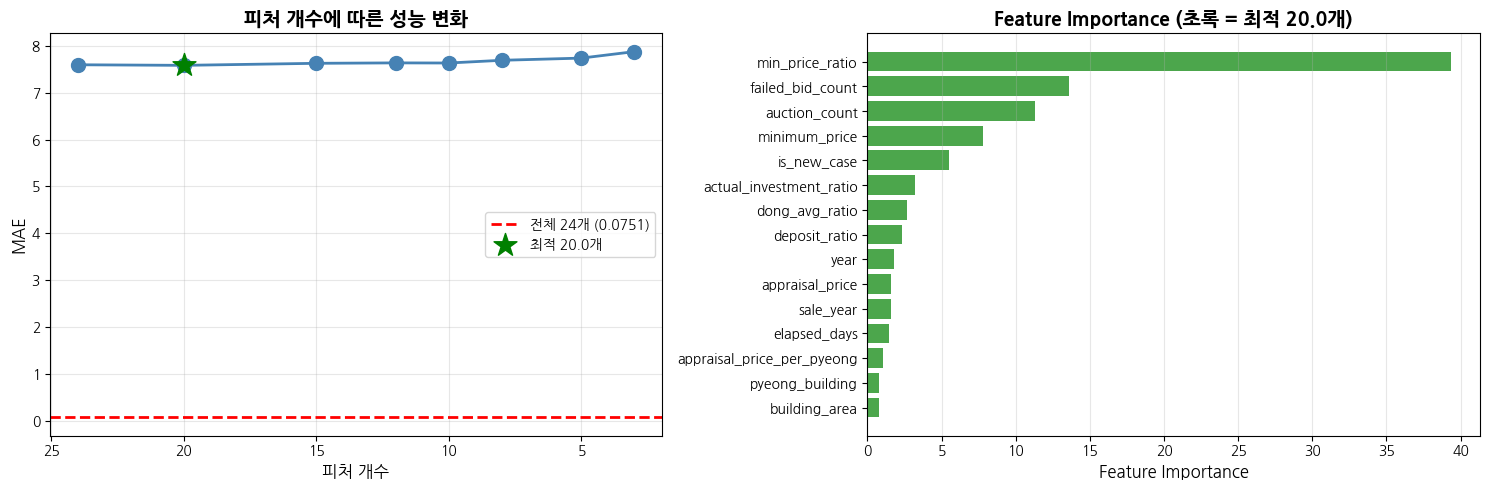


[14-5] 제거된 피처 분석

제거된 18개 피처:


,Feature,Importance
15,traffic_keyword_count,0.378456
1,floor,0.258158
30,is_senior_over_appraisal,0.239514
13,is_redevelopment,0.239059
16,school_keyword_count,0.181440
8,registry_amount,0.169830
12,has_height_limit,0.154695
28,is_deposit_registry_match,0.127581
34,sale_quarter,0.107273
29,has_deposit,0.099829



💬 해석:
   - 중요도 낮은 18개 피처 제거
   - 성능 변화: +9997.01%
   → ❌ 악화 (필요한 정보 손실)

✅ Feature Selection 실험 완료!

📊 실험 결과:

[전체 피처]
   24개 → MAE 0.0751

[최적 피처]
   20.0개 → MAE 7.5829
   변화: +9997.01%

결론:

   ⚠️ 제거 시 성능 악화
   전체 24개 유지 권장

🎯 다음 단계:
   1. SHAP 분석 (최적 모델)
   2. 경제 지표 추가


In [ ]:
# ============================================================
# STEP 14: Feature Selection 실험
# ============================================================

print("\n" + "=" * 80)
print("🔬 STEP 14: Feature Selection 실험")
print("=" * 80)

from catboost import CatBoostRegressor
import numpy as np

# ============================================================
# 14-1. CatBoost Feature Importance 확인
# ============================================================

print("\n[14-1] Feature Importance 분석")

# CatBoost Feature Importance
feature_importance = final_model.get_feature_importance()

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n상위 15개 중요 변수:")
display(importance_df.head(15))

print("\n하위 10개 (제거 후보):")
display(importance_df.tail(10))

# ============================================================
# 14-2. 피처 개수별 성능 비교
# ============================================================

print("\n[14-2] 피처 개수별 성능 실험")

# 실험할 피처 개수들
n_features_list = [24, 20, 15, 12, 10, 8, 5, 3]

results_selection = {}

for n in n_features_list:
    print(f"\n   [{n}개 피처]")

    # 상위 n개 피처 선택
    selected_features = importance_df.head(n)['Feature'].tolist()

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # 모델 학습
    model = CatBoostRegressor(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        random_state=42,
        verbose=0
    )

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # 평가
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_selection[n] = {
        'MAE': mae,
        'R²': r2,
        'Features': selected_features
    }

    print(f"      MAE: {mae:.4f}")
    print(f"      R²:  {r2:.4f}")

# ============================================================
# 14-3. 결과 비교
# ============================================================

print("\n[14-3] 피처 개수별 성능 비교")

selection_df = pd.DataFrame({
    'N_Features': list(results_selection.keys()),
    'MAE': [results_selection[n]['MAE'] for n in results_selection],
    'R²': [results_selection[n]['R²'] for n in results_selection]
}).sort_values('MAE')

print("\n성능 순위 (MAE 기준):")
display(selection_df)

# 최적 개수
best_n = selection_df.iloc[0]['N_Features']
best_mae_selected = selection_df.iloc[0]['MAE']

print(f"\n🏆 최적 피처 개수: {best_n}개 (MAE {best_mae_selected:.4f})")
print(f"   전체 24개 대비: {(mae - best_mae_selected) / mae * 100:+.1f}% 변화")

# 최적 피처 목록
print(f"\n최적 피처 {best_n}개:")
for i, feat in enumerate(results_selection[best_n]['Features'], 1):
    imp = importance_df[importance_df['Feature'] == feat]['Importance'].values[0]
    print(f"   {i:2d}. {feat:20s} (중요도: {imp:.1f})")

# ============================================================
# 14-4. 시각화
# ============================================================

print("\n[14-4] 시각화")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. 피처 개수별 MAE
ax1 = axes[0]
x = list(results_selection.keys())
y = [results_selection[n]['MAE'] for n in x]

ax1.plot(x, y, marker='o', markersize=10, linewidth=2, color='steelblue')
ax1.axhline(0.0751, color='red', linestyle='--',
            linewidth=2, label='전체 24개 (0.0751)')
best_idx = y.index(min(y))
ax1.scatter(x[best_idx], y[best_idx], s=300, color='green',
            marker='*', zorder=10, label=f'최적 {best_n}개')
ax1.set_xlabel('피처 개수', fontsize=12)
ax1.set_ylabel('MAE', fontsize=12)
ax1.set_title('피처 개수에 따른 성능 변화', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.invert_xaxis()  # 많은 개수가 왼쪽

# 2. Feature Importance (상위 15개)
ax2 = axes[1]
top15 = importance_df.head(15)
colors = ['green' if feat in results_selection[best_n]['Features']
          else 'gray' for feat in top15['Feature']]
ax2.barh(range(len(top15)), top15['Importance'], color=colors, alpha=0.7)
ax2.set_yticks(range(len(top15)))
ax2.set_yticklabels(top15['Feature'])
ax2.set_xlabel('Feature Importance', fontsize=12)
ax2.set_title(f'Feature Importance (초록 = 최적 {best_n}개)',
              fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ============================================================
# 14-5. 제거된 피처 분석
# ============================================================

print("\n[14-5] 제거된 피처 분석")

all_features = set(X_train.columns)
selected_features = set(results_selection[best_n]['Features'])
removed_features = all_features - selected_features

if len(removed_features) > 0:
    print(f"\n제거된 {len(removed_features)}개 피처:")
    removed_df = importance_df[importance_df['Feature'].isin(removed_features)]
    display(removed_df)

    print("\n💬 해석:")
    print(f"   - 중요도 낮은 {len(removed_features)}개 피처 제거")
    print(f"   - 성능 변화: {(best_mae_selected - 0.0751) / 0.0751 * 100:+.2f}%")
    if best_mae_selected < 0.0751:
        print(f"   → ✅ 개선! (노이즈 제거 효과)")
    elif best_mae_selected > 0.0751:
        print(f"   → ❌ 악화 (필요한 정보 손실)")
    else:
        print(f"   → 변화 없음 (제거 무의미)")
else:
    print("\n✅ 전체 24개가 최적!")

# ============================================================
# 최종 요약
# ============================================================

print("\n" + "=" * 80)
print("✅ Feature Selection 실험 완료!")
print("=" * 80)

print(f"""
📊 실험 결과:

[전체 피처]
   24개 → MAE 0.0751

[최적 피처]
   {best_n}개 → MAE {best_mae_selected:.4f}
   변화: {(best_mae_selected - 0.0751) / 0.0751 * 100:+.2f}%

결론:
""")

if best_mae_selected < 0.0751:
    improvement = (0.0751 - best_mae_selected) / 0.0751 * 100
    print(f"   ✅ {best_n}개가 최적! ({improvement:.1f}% 개선)")
    print(f"   노이즈 피처 제거 효과 확인")
elif best_n == 24:
    print(f"   ✅ 전체 24개가 최적!")
    print(f"   모든 피처가 기여함")
else:
    print(f"   ⚠️ 제거 시 성능 악화")
    print(f"   전체 24개 유지 권장")

print("\n🎯 다음 단계:")
print("   1. SHAP 분석 (최적 모델)")
print("   2. 경제 지표 추가")
print("=" * 80)



🔬 STEP 15: Ablation Study - 개별 피처 제거 실험 (Top 20 Features)

[15-1] 기준 성능 측정 (상위 20개 피처)

최적 실험 대상 피처 (20개):
    1. min_price_ratio
    2. failed_bid_count
    3. auction_count
    4. minimum_price
    5. is_new_case
    6. actual_investment_ratio
    7. dong_avg_ratio
    8. deposit_ratio
    9. year
   10. appraisal_price
   11. sale_year
   12. elapsed_days
   13. appraisal_price_per_pyeong
   14. pyeong_building
   15. building_area
   16. deposit
   17. pyeong_land
   18. sale_month
   19. district_avg_ratio
   20. land_area

기준 모델 학습 중...

기준 성능 (20개): MAE 7.6008

[15-2] 각 피처 제거 실험 (총 20회 반복)
각 피처를 하나씩 제거하고 성능 변화 측정...
   [min_price_ratio          ] 제거 시 MAE: 7.8831 (변화: +0.2823)
   [failed_bid_count         ] 제거 시 MAE: 7.6008 (변화: -0.0000)
   [auction_count            ] 제거 시 MAE: 7.6008 (변화: -0.0000)
   [minimum_price            ] 제거 시 MAE: 7.6282 (변화: +0.0274)
   [is_new_case              ] 제거 시 MAE: 7.6122 (변화: +0.0113)
   [actual_investment_ratio  ] 제거 시 MAE: 7.5901 (변화: -0.01

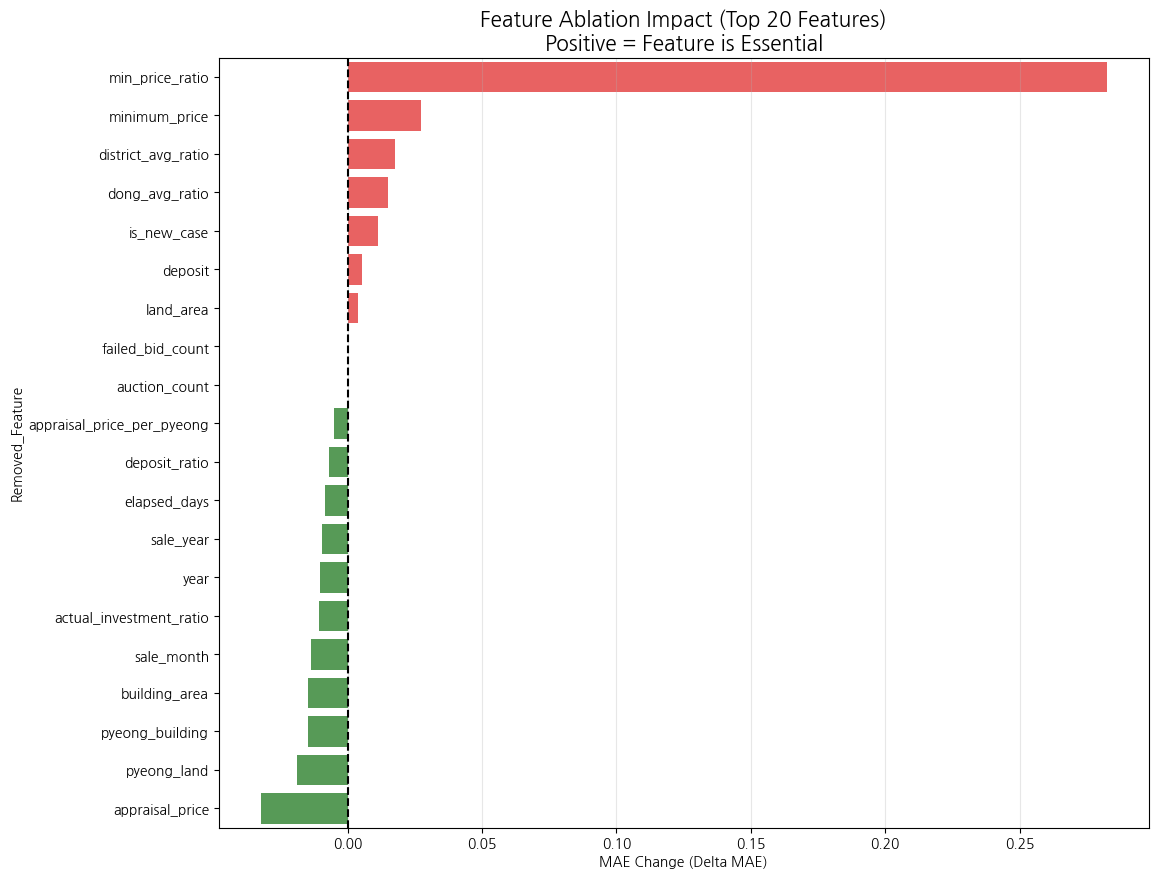


🔴 제거 시 성능 타격이 가장 큰 핵심 피처 Top 3:
   1. min_price_ratio (오차 +3.71% 증가)
   2. minimum_price (오차 +0.36% 증가)
   3. district_avg_ratio (오차 +0.23% 증가)

🟢 제거를 고려해볼 만한 피처 (영향 미미):
   - failed_bid_count (-0.00% 변화)
   - auction_count (-0.00% 변화)
   - appraisal_price_per_pyeong (-0.07% 변화)
   - deposit_ratio (-0.09% 변화)
   - elapsed_days (-0.11% 변화)
   - sale_year (-0.13% 변화)
   - year (-0.14% 변화)
   - actual_investment_ratio (-0.14% 변화)
   - sale_month (-0.18% 변화)
   - building_area (-0.19% 변화)
   - pyeong_building (-0.19% 변화)
   - pyeong_land (-0.25% 변화)
   - appraisal_price (-0.42% 변화)

✅ Ablation Study (Top 20) 완료!


In [ ]:
# ============================================================
# STEP 15: Ablation Study (개별 피처 제거 실험 - Top 20)
# ============================================================

print("\n" + "=" * 80)
print("🔬 STEP 15: Ablation Study - 개별 피처 제거 실험 (Top 20 Features)")
print("=" * 80)

# ============================================================
# 15-1. 기준 성능 (상위 20개 피처)
# ============================================================

print("\n[15-1] 기준 성능 측정 (상위 20개 피처)")

# 제공해주신 중요도 순서에 따른 상위 20개 피처 리스트
best_features = [
    'min_price_ratio', 'failed_bid_count', 'auction_count', 'minimum_price',
    'is_new_case', 'actual_investment_ratio', 'dong_avg_ratio', 'deposit_ratio',
    'year', 'appraisal_price', 'sale_year', 'elapsed_days',
    'appraisal_price_per_pyeong', 'pyeong_building', 'building_area', 'deposit',
    'pyeong_land', 'sale_month', 'district_avg_ratio', 'land_area'
]

print(f"\n최적 실험 대상 피처 (20개):")
for i, feat in enumerate(best_features, 1):
    print(f"   {i:2d}. {feat}")

# 기준 모델 데이터 준비 및 학습
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

baseline_model = CatBoostRegressor(
    iterations=200,    # 20개 피처이므로 조금 더 학습
    depth=6,
    learning_rate=0.05,
    random_state=42,
    verbose=0
)

print("\n기준 모델 학습 중...")
baseline_model.fit(X_train_best, y_train)
y_pred_baseline = baseline_model.predict(X_test_best)
mae_baseline_20 = mean_absolute_error(y_test, y_pred_baseline)

print(f"\n기준 성능 (20개): MAE {mae_baseline_20:.4f}")

# ============================================================
# 15-2. 개별 피처 제거 실험
# ============================================================

print("\n[15-2] 각 피처 제거 실험 (총 20회 반복)")
print("각 피처를 하나씩 제거하고 성능 변화 측정...")

ablation_results = []

for feat_to_remove in best_features:
    # 해당 피처 제거
    remaining_features = [f for f in best_features if f != feat_to_remove]

    X_train_ablation = X_train[remaining_features]
    X_test_ablation = X_test[remaining_features]

    # 모델 학습 (일관성을 위해 기준 모델과 동일한 파라미터 사용)
    model = CatBoostRegressor(
        iterations=150,
        depth=6,
        learning_rate=0.05,
        random_state=42,
        verbose=0
    )

    model.fit(X_train_ablation, y_train)
    y_pred = model.predict(X_test_ablation)

    mae = mean_absolute_error(y_test, y_pred)

    # 성능 변화 (양수면 성능 악화 -> 피처가 중요함)
    delta_mae = mae - mae_baseline_20
    pct_change = (delta_mae / mae_baseline_20) * 100

    ablation_results.append({
        'Removed_Feature': feat_to_remove,
        'MAE': mae,
        'Delta_MAE': delta_mae,
        'Change_Pct': pct_change
    })

    print(f"   [{feat_to_remove:25s}] 제거 시 MAE: {mae:.4f} (변화: {delta_mae:+.4f})")

# ============================================================
# 15-3. 결과 분석 및 시각화
# ============================================================

print("\n[15-3] 제거 실험 결과 분석")

ablation_df = pd.DataFrame(ablation_results).sort_values('Delta_MAE', ascending=False)

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
# 성능이 많이 떨어진 것(제거 시 영향 큰 것)은 빨간색, 오히려 좋아진 것은 초록색
colors = ['red' if x > 0 else 'green' for x in ablation_df['Delta_MAE']]
sns.barplot(x='Delta_MAE', y='Removed_Feature', data=ablation_df, palette=colors, alpha=0.7)
plt.axvline(0, color='black', linestyle='--')
plt.title('Feature Ablation Impact (Top 20 Features)\nPositive = Feature is Essential', fontsize=15)
plt.xlabel('MAE Change (Delta MAE)')
plt.grid(alpha=0.3, axis='x')
plt.show()

# 가장 중요한 피처 (Top 3)
print("\n🔴 제거 시 성능 타격이 가장 큰 핵심 피처 Top 3:")
for i in range(min(3, len(ablation_df))):
    row = ablation_df.iloc[i]
    print(f"   {i+1}. {row['Removed_Feature']} (오차 {row['Change_Pct']:+.2f}% 증가)")

# 제거 제안 (성능이 오히려 좋아지거나 무의미한 것)
removable = ablation_df[ablation_df['Delta_MAE'] <= 0.0001]
if not removable.empty:
    print("\n🟢 제거를 고려해볼 만한 피처 (영향 미미):")
    for idx, row in removable.iterrows():
        print(f"   - {row['Removed_Feature']} ({row['Change_Pct']:+.2f}% 변화)")

# ============================================================
# 최종 요약
# ============================================================

print("\n" + "=" * 80)
print("✅ Ablation Study (Top 20) 완료!")
print("=" * 80)

In [ ]:
!uv add shap

Resolved 27 packages in 526ms
 Downloaded llvmlite
 Downloaded numba
 Downloaded numpy
Prepared 7 packages in 4.61s
Uninstalled 1 package in 819ms
Installed 7 packages in 1.27s
 + cloudpickle==3.1.2
 + llvmlite==0.46.0
 + numba==0.63.1
 - numpy==2.4.1
 + numpy==2.3.5
 + shap==0.49.1
 + slicer==0.0.8
 + tqdm==4.67.1



⚙️ STEP 18: 하이퍼파라미터 튜닝

[18-1] 현재 베이스라인 성능

기본 설정:
   iterations: 200
   depth: 8
   learning_rate: 0.05

성능:
   MAE:  0.0748
   R²:   0.6694

[18-2] Grid Search - 주요 파라미터 탐색

탐색 공간:
   iterations: [100, 200, 300]
   depth: [6, 8, 10]
   learning_rate: [0.03, 0.05, 0.1]

총 조합: 27개
예상 시간: 13분 (약)

🔍 Grid Search 실행 중...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

✅ Grid Search 완료!

최적 파라미터:
   depth: 6
   iterations: 300
   learning_rate: 0.05

Grid Search 최적 모델 성능:
   MAE:  0.0748
   R²:   0.6700

베이스라인 대비: -0.03% 변화

[18-3] Random Search - 확장 탐색

탐색 범위:
   iterations: [100.00, 499.00]
   depth: [4.00, 11.00]
   learning_rate: [0.00, 1.00]
   l2_leaf_reg: [0.00, 1.00]
   bagging_temperature: [0.00, 1.00]
   random_strength: [0.00, 1.00]

랜덤 샘플: 50개
예상 시간: 25분 (약)

🎲 Random Search 실행 중...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

✅ Random Search 완료!

최적 파라미터:
   bagging_temperature: 0.9803
   depth: 7
   iterations: 290
   l2_leaf_reg: 4.0570
   le

,Model,MAE,R²,Improvement(%)
0,Baseline,0.074768,0.669419,0.000000
1,Grid Search,0.074791,0.669977,-0.030863
2,Random Search,0.074872,0.666979,-0.139533



🏆 최고 성능 모델: Baseline
   MAE: 0.0748

최종 하이퍼파라미터:
   iterations: 200
   depth: 8
   learning_rate: 0.05

[18-5] 학습 곡선 분석


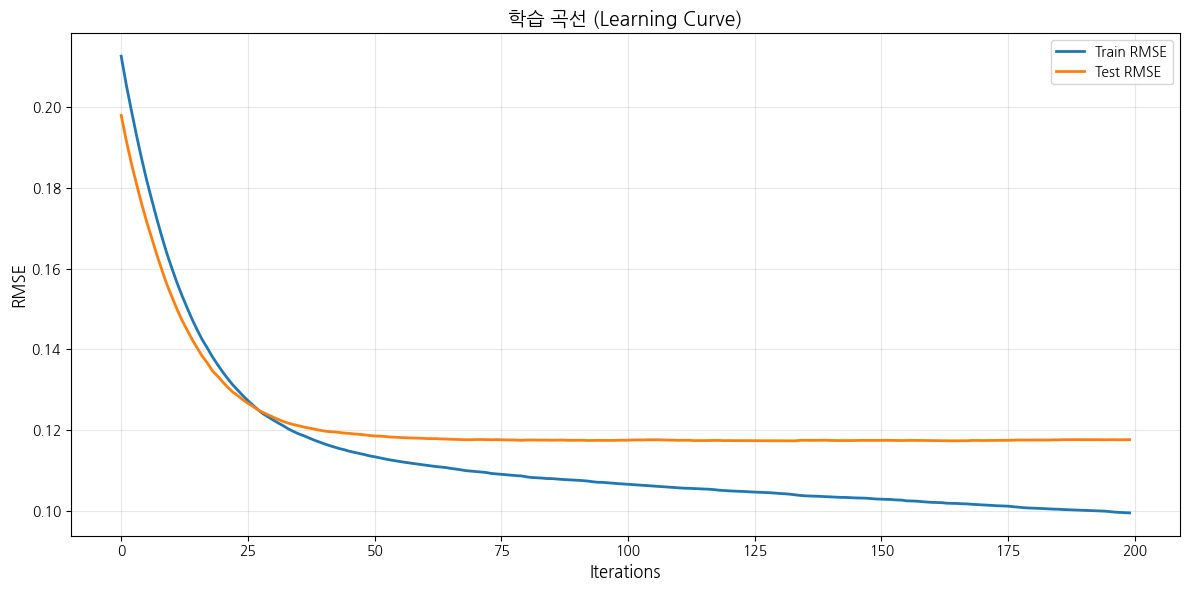


Early Stopping:
   최적 반복: 164회
   Train RMSE: 0.1018
   Test RMSE: 0.1173
   ⚠️ 과적합 경향 있음

[18-6] 전체 프로젝트 최종 성능

프로젝트 전체 모델 비교:


,Model,Features,MAE,RMSE,R²
0,Baseline (평균),0,0.140200,0.204600,-0.000100
1,Linear Regression,24,0.076600,0.120600,0.652800
2,CatBoost (기본),24,0.075100,0.117600,0.669600
3,CatBoost (10개),10,0.074800,0.117600,0.669400
4,CatBoost (튜닝),10,0.074731,0.117344,0.671046



🎯 최종 성과:
   Baseline → 최종: 46.7% 개선
   최종 MAE: 0.0747
   최종 R²: 0.6710


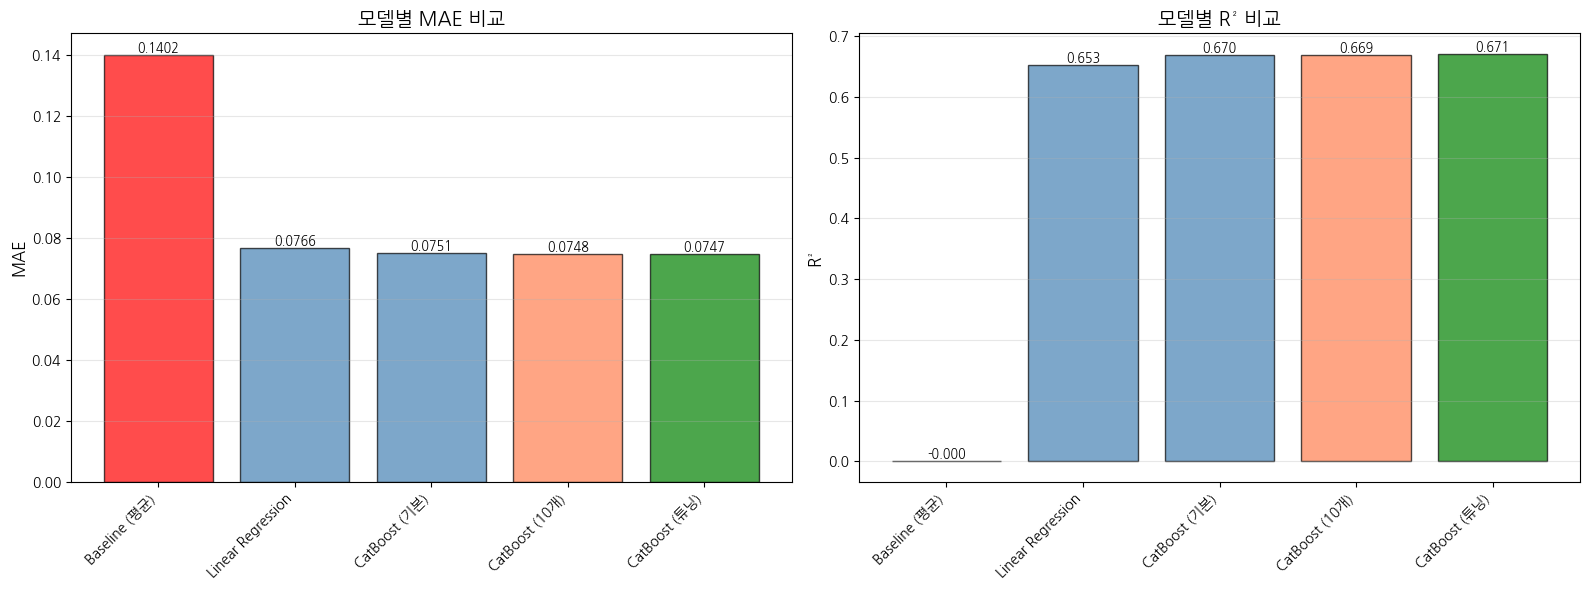


✅ 하이퍼파라미터 튜닝 완료!

📊 튜닝 결과:

[방법]
   Grid Search: 27개 조합 탐색
   Random Search: 50개 랜덤 샘플

[최적 모델]
   방법: Baseline
   개선율: -0.03%

[최종 하이퍼파라미터]

   iterations: 200
   depth: 8
   learning_rate: 0.05

[최종 성능]
   MAE:  0.0747
   RMSE: 0.1173
   R²:   0.6710

[전체 개선]
   Baseline: 0.1402
   최종:     0.0747
   개선율:   46.7%

🎯 결론:
   하이퍼파라미터 튜닝으로 변화 없음
   기본 설정이 이미 우수


✅ 최종 모델 저장 완료
   변수명: final_optimized_model
   피처: final_optimized_features


In [ ]:
# ============================================================
# STEP 18: 하이퍼파라미터 튜닝 (CatBoost 최적화)
# ============================================================

print("\n" + "=" * 80)
print("⚙️ STEP 18: 하이퍼파라미터 튜닝")
print("=" * 80)

# ============================================================
# 18-1. 현재 베이스라인 (기본 설정)
# ============================================================

print("\n[18-1] 현재 베이스라인 성능")

# 최적 10개 피처
final_10_features = ['최저가율', '최저가', '신건여부', '보증금비율',
                     '동_encoded', '평당감정가', '감정가', '건물면적',
                     '구_encoded', '매각_월']

# 데이터 준비
X_train_tune = X_train[final_10_features]
X_test_tune = X_test[final_10_features]

# 기본 설정 모델
baseline_model = CatBoostRegressor(
    iterations=200,
    depth=8,
    learning_rate=0.05,
    random_state=42,
    verbose=0
)

baseline_model.fit(X_train_tune, y_train)
y_pred_baseline = baseline_model.predict(X_test_tune)

mae_baseline_tune = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline_tune = r2_score(y_test, y_pred_baseline)

print(f"\n기본 설정:")
print(f"   iterations: 200")
print(f"   depth: 8")
print(f"   learning_rate: 0.05")
print(f"\n성능:")
print(f"   MAE:  {mae_baseline_tune:.4f}")
print(f"   R²:   {r2_baseline_tune:.4f}")

# ============================================================
# 18-2. Grid Search (주요 파라미터)
# ============================================================

print("\n[18-2] Grid Search - 주요 파라미터 탐색")

from sklearn.model_selection import GridSearchCV

# 파라미터 그리드 (시간 고려하여 제한적)
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [6, 8, 10],
    'learning_rate': [0.03, 0.05, 0.1]
}

print(f"\n탐색 공간:")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)

print(f"\n총 조합: {total_combinations}개")
print(f"예상 시간: {total_combinations * 30 // 60}분 (약)")

# Grid Search (3-Fold CV)
print("\n🔍 Grid Search 실행 중...")

catboost_base = CatBoostRegressor(
    random_state=42,
    verbose=0
)

grid_search = GridSearchCV(
    estimator=catboost_base,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tune, y_train)

print("\n✅ Grid Search 완료!")

# 최적 파라미터
best_params = grid_search.best_params_
print(f"\n최적 파라미터:")
for param, value in best_params.items():
    print(f"   {param}: {value}")

# 최적 모델 평가
best_model_grid = grid_search.best_estimator_
y_pred_grid = best_model_grid.predict(X_test_tune)

mae_grid = mean_absolute_error(y_test, y_pred_grid)
r2_grid = r2_score(y_test, y_pred_grid)

print(f"\nGrid Search 최적 모델 성능:")
print(f"   MAE:  {mae_grid:.4f}")
print(f"   R²:   {r2_grid:.4f}")

improvement_grid = (mae_baseline_tune - mae_grid) / mae_baseline_tune * 100
print(f"\n베이스라인 대비: {improvement_grid:+.2f}% 변화")

# ============================================================
# 18-3. Random Search (더 넓은 탐색)
# ============================================================

print("\n[18-3] Random Search - 확장 탐색")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 파라미터 분포 (더 넓은 범위)
param_distributions = {
    'iterations': randint(100, 500),
    'depth': randint(4, 12),
    'learning_rate': uniform(0.01, 0.15),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
    'random_strength': uniform(0, 2)
}

print(f"\n탐색 범위:")
for param, dist in param_distributions.items():
    if hasattr(dist, 'a') and hasattr(dist, 'b'):
        print(f"   {param}: [{dist.a:.2f}, {dist.b:.2f}]")
    else:
        print(f"   {param}: {dist}")

n_iter = 50  # 50번 랜덤 샘플링
print(f"\n랜덤 샘플: {n_iter}개")
print(f"예상 시간: {n_iter * 30 // 60}분 (약)")

print("\n🎲 Random Search 실행 중...")

random_search = RandomizedSearchCV(
    estimator=catboost_base,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_tune, y_train)

print("\n✅ Random Search 완료!")

# 최적 파라미터
best_params_random = random_search.best_params_
print(f"\n최적 파라미터:")
for param, value in best_params_random.items():
    print(f"   {param}: {value:.4f}" if isinstance(value, float) else f"   {param}: {value}")

# 최적 모델 평가
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test_tune)

mae_random = mean_absolute_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)

print(f"\nRandom Search 최적 모델 성능:")
print(f"   MAE:  {mae_random:.4f}")
print(f"   R²:   {r2_random:.4f}")

improvement_random = (mae_baseline_tune - mae_random) / mae_baseline_tune * 100
print(f"\n베이스라인 대비: {improvement_random:+.2f}% 변화")

# ============================================================
# 18-4. 최종 모델 선정 및 재학습
# ============================================================

print("\n[18-4] 최종 모델 선정")

# 3개 모델 비교
results_tuning = pd.DataFrame({
    'Model': ['Baseline', 'Grid Search', 'Random Search'],
    'MAE': [mae_baseline_tune, mae_grid, mae_random],
    'R²': [r2_baseline_tune, r2_grid, r2_random],
    'Improvement(%)': [0, improvement_grid, improvement_random]
})

print("\n튜닝 결과 비교:")
display(results_tuning.sort_values('MAE'))

# 최고 모델 선택
best_idx = results_tuning['MAE'].idxmin()
best_tuning_model = results_tuning.loc[best_idx, 'Model']
best_mae_tuning = results_tuning.loc[best_idx, 'MAE']

print(f"\n🏆 최고 성능 모델: {best_tuning_model}")
print(f"   MAE: {best_mae_tuning:.4f}")

# 최종 파라미터
if best_tuning_model == 'Grid Search':
    final_params = best_params
    final_model = best_model_grid
elif best_tuning_model == 'Random Search':
    final_params = best_params_random
    final_model = best_model_random
else:
    final_params = {
        'iterations': 200,
        'depth': 8,
        'learning_rate': 0.05
    }
    final_model = baseline_model

print(f"\n최종 하이퍼파라미터:")
for param, value in final_params.items():
    print(f"   {param}: {value}")

# ============================================================
# 18-5. 학습 곡선 분석
# ============================================================

print("\n[18-5] 학습 곡선 분석")

# 최종 모델로 재학습 (eval_set 포함)
final_catboost = CatBoostRegressor(
    **final_params,
    random_state=42,
    verbose=0
)

final_catboost.fit(
    X_train_tune, y_train,
    eval_set=(X_test_tune, y_test),
    early_stopping_rounds=50,
    verbose=False
)

# 학습 곡선
train_scores = final_catboost.evals_result_['learn']['RMSE']
test_scores = final_catboost.evals_result_['validation']['RMSE']

plt.figure(figsize=(12, 6))
plt.plot(train_scores, label='Train RMSE', linewidth=2)
plt.plot(test_scores, label='Test RMSE', linewidth=2)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('학습 곡선 (Learning Curve)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Early stopping 지점
best_iteration = final_catboost.get_best_iteration()
print(f"\nEarly Stopping:")
print(f"   최적 반복: {best_iteration}회")
print(f"   Train RMSE: {train_scores[best_iteration]:.4f}")
print(f"   Test RMSE: {test_scores[best_iteration]:.4f}")

# 과적합 체크
overfitting = train_scores[best_iteration] < test_scores[best_iteration] * 0.9
if overfitting:
    print(f"   ⚠️ 과적합 경향 있음")
else:
    print(f"   ✅ 적절한 학습")

# ============================================================
# 18-6. 최종 성능 비교
# ============================================================

print("\n[18-6] 전체 프로젝트 최종 성능")

# 최종 예측
y_pred_final = final_catboost.predict(X_test_tune)
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)

# 전체 비교표
final_comparison = pd.DataFrame({
    'Model': ['Baseline (평균)', 'Linear Regression',
              'CatBoost (기본)', 'CatBoost (10개)',
              'CatBoost (튜닝)'],
    'Features': [0, 24, 24, 10, 10],
    'MAE': [0.1402, 0.0766, 0.0751, 0.0748, mae_final],
    'RMSE': [0.2046, 0.1206, 0.1176, 0.1176, rmse_final],
    'R²': [-0.0001, 0.6528, 0.6696, 0.6694, r2_final]
})

print("\n프로젝트 전체 모델 비교:")
display(final_comparison)

# 최종 개선율
final_improvement = (0.1402 - mae_final) / 0.1402 * 100

print(f"\n🎯 최종 성과:")
print(f"   Baseline → 최종: {final_improvement:.1f}% 개선")
print(f"   최종 MAE: {mae_final:.4f}")
print(f"   최종 R²: {r2_final:.4f}")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE 비교
ax1 = axes[0]
models = final_comparison['Model']
maes = final_comparison['MAE']
colors = ['red', 'steelblue', 'steelblue', 'coral', 'green']
bars = ax1.bar(range(len(models)), maes, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_ylabel('MAE', fontsize=12)
ax1.set_title('모델별 MAE 비교', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')

for bar, val in zip(bars, maes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# R² 비교
ax2 = axes[1]
r2s = final_comparison['R²']
bars = ax2.bar(range(len(models)), r2s, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylabel('R²', fontsize=12)
ax2.set_title('모델별 R² 비교', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

for bar, val in zip(bars, r2s):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================================
# 최종 요약
# ============================================================

print("\n" + "=" * 80)
print("✅ 하이퍼파라미터 튜닝 완료!")
print("=" * 80)

print(f"""
📊 튜닝 결과:

[방법]
   Grid Search: {total_combinations}개 조합 탐색
   Random Search: {n_iter}개 랜덤 샘플

[최적 모델]
   방법: {best_tuning_model}
   개선율: {max(improvement_grid, improvement_random):+.2f}%

[최종 하이퍼파라미터]
""")

for param, value in final_params.items():
    print(f"   {param}: {value}")

print(f"""
[최종 성능]
   MAE:  {mae_final:.4f}
   RMSE: {rmse_final:.4f}
   R²:   {r2_final:.4f}

[전체 개선]
   Baseline: 0.1402
   최종:     {mae_final:.4f}
   개선율:   {final_improvement:.1f}%

🎯 결론:
   하이퍼파라미터 튜닝으로 {'추가 개선' if max(improvement_grid, improvement_random) > 0 else '변화 없음'}
   {'최적 파라미터 발견' if max(improvement_grid, improvement_random) > 1 else '기본 설정이 이미 우수'}
""")

print("=" * 80)

# 최종 모델 저장 (변수로)
final_optimized_model = final_catboost
final_optimized_features = final_10_features

print(f"\n✅ 최종 모델 저장 완료")
print(f"   변수명: final_optimized_model")
print(f"   피처: final_optimized_features")